# **PROJET TIME SERIES**

### Introduction : Prédiction des Ventes pour une Gestion Optimisée  

Dans le cadre de ce projet, nous visons à prédire les ventes hebdomadaires d'une chaîne de supermarchés en nous basant sur le jeu de données [Superstore Sales Dataset](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting). Cette prévision s’appuie sur quatre années de données historiques, incluant des informations sur les produits, les clients et les régions géographiques.  

#### *Objectif et Cadrage du Forecast*  
L’objectif principal est de prévoir les ventes pour les 30 jours suivant la dernière date du jeu de données, afin de soutenir des décisions stratégiques et opérationnelles, notamment :  

•⁠  ⁠*Optimisation des stocks* : éviter les ruptures ou les surplus.  
•⁠  ⁠*Planification logistique et budgétaire* : allouer efficacement les ressources.  
•⁠  ⁠*Amélioration des stratégies marketing* : cibler les régions et segments les plus prometteurs.  

Le projet se concentre sur une *granularité temporelle mensuelle*.
---

#### *Coût des Erreurs de Forecast*  
Une sous-estimation ou une surestimation des ventes peut avoir des impacts financiers significatifs sur l'entreprise :  

•⁠  ⁠*Sous-estimation* :  
  - Risque de rupture de stock, entraînant une perte de revenus et une insatisfaction client.  
  - Difficulté à répondre à la demande dans les régions en forte croissance.  

•⁠  ⁠*Surestimation* :  
  - Coûts supplémentaires liés à la gestion des stocks excédentaires.  
  - Immobilisation de capital pouvant être mieux utilisé ailleurs.  

Ces implications renforcent la nécessité d’un modèle précis et fiable.  

---

#### *Choix de la Fonction de Perte*  
Étant donné l’importance des grandes erreurs dans le contexte commercial, une *fonction de coût symétrique* comme la Mean Squared Error (MSE) est privilégiée. Elle punit sévèrement les erreurs importantes, cruciales pour minimiser les répercussions stratégiques sur les ventes et les stocks. Toutefois, une analyse pourrait aussi envisager des fonctions asymétriques si les erreurs dans une direction sont plus coûteuses.  

---

#### *Horizon de Prévision*  
Le modèle doit prévoir les ventes à court terme (30 jours), garantissant des ajustements dynamiques. Des prévisions pour des horizons plus longs (trimestriels ou annuels) pourraient être explorées pour des objectifs stratégiques, mais avec une précision réduite à mesure que l’horizon s’éloigne.  

---

#### *Sélection et Analyse des Features*  
Une analyse approfondie des données identifie les prédicteurs les plus pertinents :  

1.⁠ ⁠*Caractéristiques temporelles* :  
   - ⁠ Order Date ⁠ et ⁠ Ship Date ⁠ pour analyser les cycles de ventes et la saisonnalité. ⁠ Order Date ⁠ est utilisé en priorité dans le cadre de ce projet.

2.⁠ ⁠*Caractéristiques des produits* :  
   - ⁠ Category ⁠, ⁠ Sub-Category ⁠, et ⁠ Product ID ⁠ pour des analyses détaillées des tendances de vente par produit. Ces variables servent surtout pour l'analyse exploratoire des données. Les prévisions temporelles sont basées sur les ventes agrégées par jour, toutes catégories de produits confondues.

3.⁠ ⁠*Informations géographiques* :  
   - ⁠ Country ⁠, ⁠ City ⁠, et ⁠ State ⁠ pour cibler les régions à fort potentiel.

4.⁠ ⁠*Comportement client* :  
   - ⁠ Customer Segment ⁠ pour explorer les habitudes d’achat des catégories de clients.

Une attention particulière sera accordée à la qualité des données et à leur transformation, comme la normalisation des ventes pour limiter l’influence des valeurs extrêmes.  

---

#### *Méthodologie et Évaluation*  
Les prévisions seront effectuées à l'aide de techniques adaptées, comparées via une méthodologie rigoureuse à l'aide de métriques d'évaluation.
Le Root Mean Squared Error (RMSE) et le Mean Squared Error (MSE) sont utilisés pour évaluer la performance des modèles testés.


En conclusion, ce projet mettra en œuvre une approche analytique complète pour répondre aux besoins stratégiques et opérationnels du supermarché, tout en s’assurant que les modèles sont précis, fiables et alignés sur les objectifs commerciaux.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # pour un graphique
import statsmodels.api as sm
import folium
import pywt
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import holidays
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, acf, pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import ParameterGrid


from math import sqrt
from sklearn.base import clone

In [ ]:
df=pd.read_csv("data/train.csv")

In [ ]:
df.head(3)

In [ ]:
df.columns

In [ ]:
df=df.drop(columns=["Row ID", "Customer Name","Country"], axis=1)

In [ ]:
df.shape

On voit que notre dataframe contient 9800 lignes et 18 variables. Certaines d'entre elles ne présentent pas une grande utilité, notamment 'Row ID', 'Customer Name', 'Country' (car c'est toujours USA). Cependant d'autres seront très utiles notamment pour l'analyse exploratoire des données. L'unique variable numérique c'est 'Sales' qui représente le montant de vente. Cette variable est centrale pour les prévisions de vente.

A noter qu'une ligne ne veut pas forcément dire une commande, parfois une commande est répartie entre plusieurs lignes du DF car les produits achetés sont différents.

In [ ]:
df.dtypes

### Types de variables

In [ ]:
df['Order Date']= pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date']= pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')
df["Postal Code"]=df["Postal Code"].astype("object")

In [ ]:
date_debut=df["Order Date"].min()
date_fin=df["Order Date"].max()
print("date de début de nos données :", date_debut, "et date de fin de nos données :", date_fin)

Nos données couvrent une période de presque 4 ans : de 03/01/2015 jusqu'au 30/12/2018.

In [ ]:
df.dtypes

## **EDA**

### Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order ID      9800 non-null   object        
 1   Order Date    9800 non-null   datetime64[ns]
 2   Ship Date     9800 non-null   datetime64[ns]
 3   Ship Mode     9800 non-null   object        
 4   Customer ID   9800 non-null   object        
 5   Segment       9800 non-null   object        
 6   City          9800 non-null   object        
 7   State         9800 non-null   object        
 8   Postal Code   9789 non-null   object        
 9   Region        9800 non-null   object        
 10  Product ID    9800 non-null   object        
 11  Category      9800 non-null   object        
 12  Sub-Category  9800 non-null   object        
 13  Product Name  9800 non-null   object        
 14  Sales         9800 non-null   float64       
dtypes: datetime64[ns](2), float64(1), obje

Sur les 9800 lignes de notre base de données, on a uniquement 793 clients uniques et 4922 commandes uniques placées.

In [ ]:
unique_counts= df.nunique()
unique_counts

Order ID        4922
Order Date      1230
Ship Date       1326
Ship Mode          4
Customer ID      793
Segment            3
City             529
State             49
Postal Code      626
Region             4
Product ID      1861
Category           3
Sub-Category      17
Product Name    1849
Sales           5757
dtype: int64

In [ ]:
pd.set_option('display.max_colwidth', None)

table_data=[]
for column in df.columns:
    unique_values = df[column].unique()
    unique_count = len(unique_values)

    if unique_count <= 20:
        table_data.append([column, unique_count, ", ".join(map(str, unique_values))])

# Dataframe pour une meilleure visualisation des modalités pour les variables catégorielles à peu de modalités
unique_values_df = pd.DataFrame(table_data, columns=["Colonne", "Nb valeurs uniques", "Valeurs uniques"])

unique_values_df

Colonne  Nb valeurs uniques  \
0     Ship Mode                   4   
1       Segment                   3   
2        Region                   4   
3      Category                   3   
4  Sub-Category                  17   

                                                                                                                                                    Valeurs uniques  
0                                                                                                               Second Class, Standard Class, First Class, Same Day  
1                                                                                                                                  Consumer, Corporate, Home Office  
2                                                                                                                                        South, West, Central, East  
3                                                                                                                            Furniture, Office Supplies, Technology  
4  Bookcases, Chairs, Labels, Tables, Storage, Furnishings, Art, Phones, Binders, Appliances, Paper, Accessories, Envelopes, Fasteners, Supplies, Machines, Copiers

### Valeurs manquantes

In [ ]:
print("Nombre de valeurs manquantes par colonne :")
missing_values = df.isnull().sum()
missing_values

Nombre de valeurs manquantes par colonne :


Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Segment          0
City             0
State            0
Postal Code     11
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

Les 11 observations manquantes dans la colonne "Postal Code" sont des commandes placées par des clients de la même ville, dont le code postal est 05041.

In [ ]:
df["Postal Code"] = df["Postal Code"].fillna("05401")


### Outliers

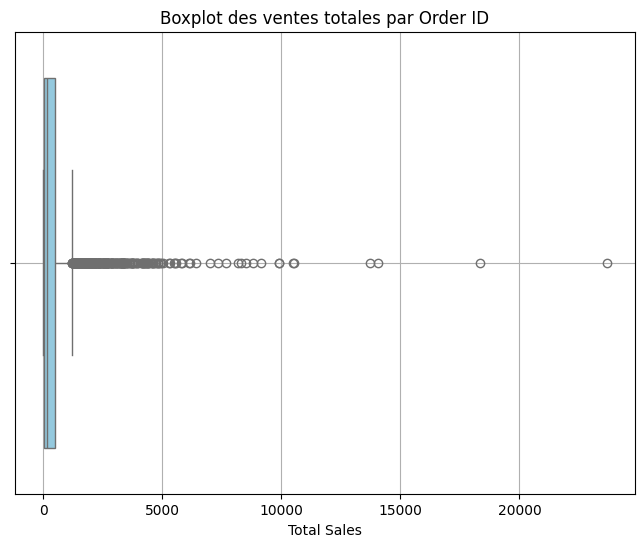

In [ ]:
# On regroupe le montant de vente par commande pour les statistiques descriptives.
df_grouped = df.groupby("Order ID").agg({"Sales": "sum"}).reset_index()

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_grouped, x="Sales", color='skyblue')
plt.title("Boxplot des ventes totales par Order ID")
plt.xlabel("Total Sales")
plt.grid(True)
plt.show()

In [ ]:
# Statistiques sur le montant des ventes par commande unique
stats = {
    "Moyenne": df_grouped["Sales"].mean(),
    "Médiane": df_grouped["Sales"].median(),
    "Écart-type": df_grouped["Sales"].std(),
    "Min": df_grouped["Sales"].min(),
    "Max": df_grouped["Sales"].max(),
    "1er Quartile (Q1)": df_grouped["Sales"].quantile(0.25),
    "3e Quartile (Q3)": df_grouped["Sales"].quantile(0.75),
    "IQR (Q3 - Q1)": df_grouped["Sales"].quantile(0.75) - df_grouped["Sales"].quantile(0.25)
}

# Conversion en DataFrame
df_stats = pd.DataFrame(stats, index=["Statistiques"])

df_stats


Moyenne  Médiane  Écart-type    Min        Max  \
Statistiques  459.475169  151.875  958.666378  0.556  23661.228   

              1er Quartile (Q1)  3e Quartile (Q3)  IQR (Q3 - Q1)  
Statistiques             37.272           513.514        476.242

On observe une forte volatilité dans le montant des ventes par commande. De plus, la moyenne est beaucoup plus élevée que la médiane, ce qui reflète un grand nombre d'outliers à droite, comme présenté sur le graphique ci-dessus. Il y a donc quelques commandes dont les montants sont très élevés et qui tirent la moyenne vers le haut.

### Création des variables pour la vizualisation


In [ ]:
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day']=df['Order Date'].dt.day
df['Day of Week'] = df['Order Date'].dt.day_name()

df['Shipping Time']= df['Ship Date'] - df['Order Date']
df['Shipping Time (days)']= df['Shipping Time'].dt.days

In [ ]:
df.head()

Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
1  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
2  CA-2017-138688 2017-06-12 2017-06-16    Second Class    DV-13045   
3  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   
4  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   

     Segment             City       State Postal Code Region  ...  \
0   Consumer        Henderson    Kentucky     42420.0  South  ...   
1   Consumer        Henderson    Kentucky     42420.0  South  ...   
2  Corporate      Los Angeles  California     90036.0   West  ...   
3   Consumer  Fort Lauderdale     Florida     33311.0  South  ...   
4   Consumer  Fort Lauderdale     Florida     33311.0  South  ...   

          Category Sub-Category  \
0        Furniture    Bookcases   
1        Furniture       Chairs   
2  Office Supplies       Labels   
3        Furniture       Tables   
4  Office Supplies      Storage   

                                                  Product Name     Sales  \
0                            Bush Somerset Collection Bookcase  261.9600   
1  Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back  731.9400   
2    Self-Adhesive Address Labels for Typewriters by Universal   14.6200   
3                Bretford CR4500 Series Slim Rectangular Table  957.5775   
4                               Eldon Fold 'N Roll Cart System   22.3680   

   Year  Month  Day  Day of Week Shipping Time Shipping Time (days)  
0  2017     11    8    Wednesday        3 days                    3  
1  2017     11    8    Wednesday        3 days                    3  
2  2017      6   12       Monday        4 days                    4  
3  2016     10   11      Tuesday        7 days                    7  
4  2016     10   11      Tuesday        7 days                    7  

[5 rows x 21 columns]

In [ ]:
# Temps d'expédition
average_shipping_time= df['Shipping Time (days)'].mean()
print(f"Temps moyen entre commande et expédition : {average_shipping_time:.2f} jours")

Temps moyen entre commande et expédition : 3.96 jours


In [ ]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Segment', 'City', 'State', 'Postal Code', 'Region', 'Product ID',
       'Category', 'Sub-Category', 'Product Name', 'Sales', 'Year', 'Month',
       'Day', 'Day of Week', 'Shipping Time', 'Shipping Time (days)'],
      dtype='object')

In [ ]:
df.dtypes

Order ID                         object
Order Date               datetime64[ns]
Ship Date                datetime64[ns]
Ship Mode                        object
Customer ID                      object
Segment                          object
City                             object
State                            object
Postal Code                      object
Region                           object
Product ID                       object
Category                         object
Sub-Category                     object
Product Name                     object
Sales                           float64
Year                              int32
Month                             int32
Day                               int32
Day of Week                      object
Shipping Time           timedelta64[ns]
Shipping Time (days)              int64
dtype: object

### Statistiques descriptives

### Data vizualisation

#### Count vizualisation

On regarde le nombre de commandes par année et le montant moyen de commande par année. On observe que le nombre de commandes a presque doublé entre 2015 et 2018 mais le montant moyen de commande présente une légère tendance à la baisse.

In [ ]:
unique_orders = df.groupby('Order ID').first()
orders_per_year = unique_orders['Year'].value_counts().sort_index()
total_sales_per_order = df.groupby('Order ID')['Sales'].sum()
avg_sales_per_year = total_sales_per_order.groupby(unique_orders['Year']).mean().sort_index()

# Créer un DataFrame avec les résultats
df_avg_sales_per_year = pd.DataFrame({
    'Year': orders_per_year.index,
    'Number of Orders': orders_per_year.values,
    'Average Order Amount': avg_sales_per_year.values
})

# Afficher le DataFrame
df_avg_sales_per_year


Year  Number of Orders  Average Order Amount
0  2015               947            506.711941
1  2016              1019            450.869485
2  2017              1295            463.469151
3  2018              1661            434.709223

On regarde le profil des clients. Plus de 50% des clients font partie du segment "Customer", environ 30% sont des entreprise.

In [ ]:
# On veut regarder quel est le profil des clients
unique_customers = df[["Customer ID", "Segment"]].drop_duplicates()
customer_counts = unique_customers["Segment"].value_counts()/len(unique_customers)
customer_counts_df = customer_counts.reset_index()
customer_counts_df.columns = ["Segment", "Nombre de clients uniques"]
customer_counts_df

Segment  Nombre de clients uniques
0     Consumer                   0.515763
1    Corporate                   0.297604
2  Home Office                   0.186633

In [ ]:
# Analyse des proportions des ventes par modalité des variables catégoriques

def analyse_pourcentage_ventes_par_categorie(year):
    cols_to_plot = ['Ship Mode', 'Segment', 'Region', 'Category', 'Month', 'Day of Week']
    total_sales = df[df["Year"] == year]['Sales'].sum()

    n_cols = 2
    n_rows = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows),gridspec_kw={'hspace': 0.4})
    axes = axes.flatten()

    for i, column in enumerate(cols_to_plot):
        sales_by_category = df[df["Year"] == year].groupby(column)['Sales'].sum().sort_values()
        sales_percentage = (sales_by_category / total_sales) * 100

        ax = axes[i]
        sns.barplot(x=sales_percentage.index, y=sales_percentage.values, palette='Blues', ax=ax)
        ax.set_title(f'Proportion des ventes par {column}')
        ax.set_ylabel('Pourcentage des ventes (%)')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}%',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        fontsize=10, color='black',
                        xytext=(0, 5), textcoords='offset points')

    plt.show()


<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

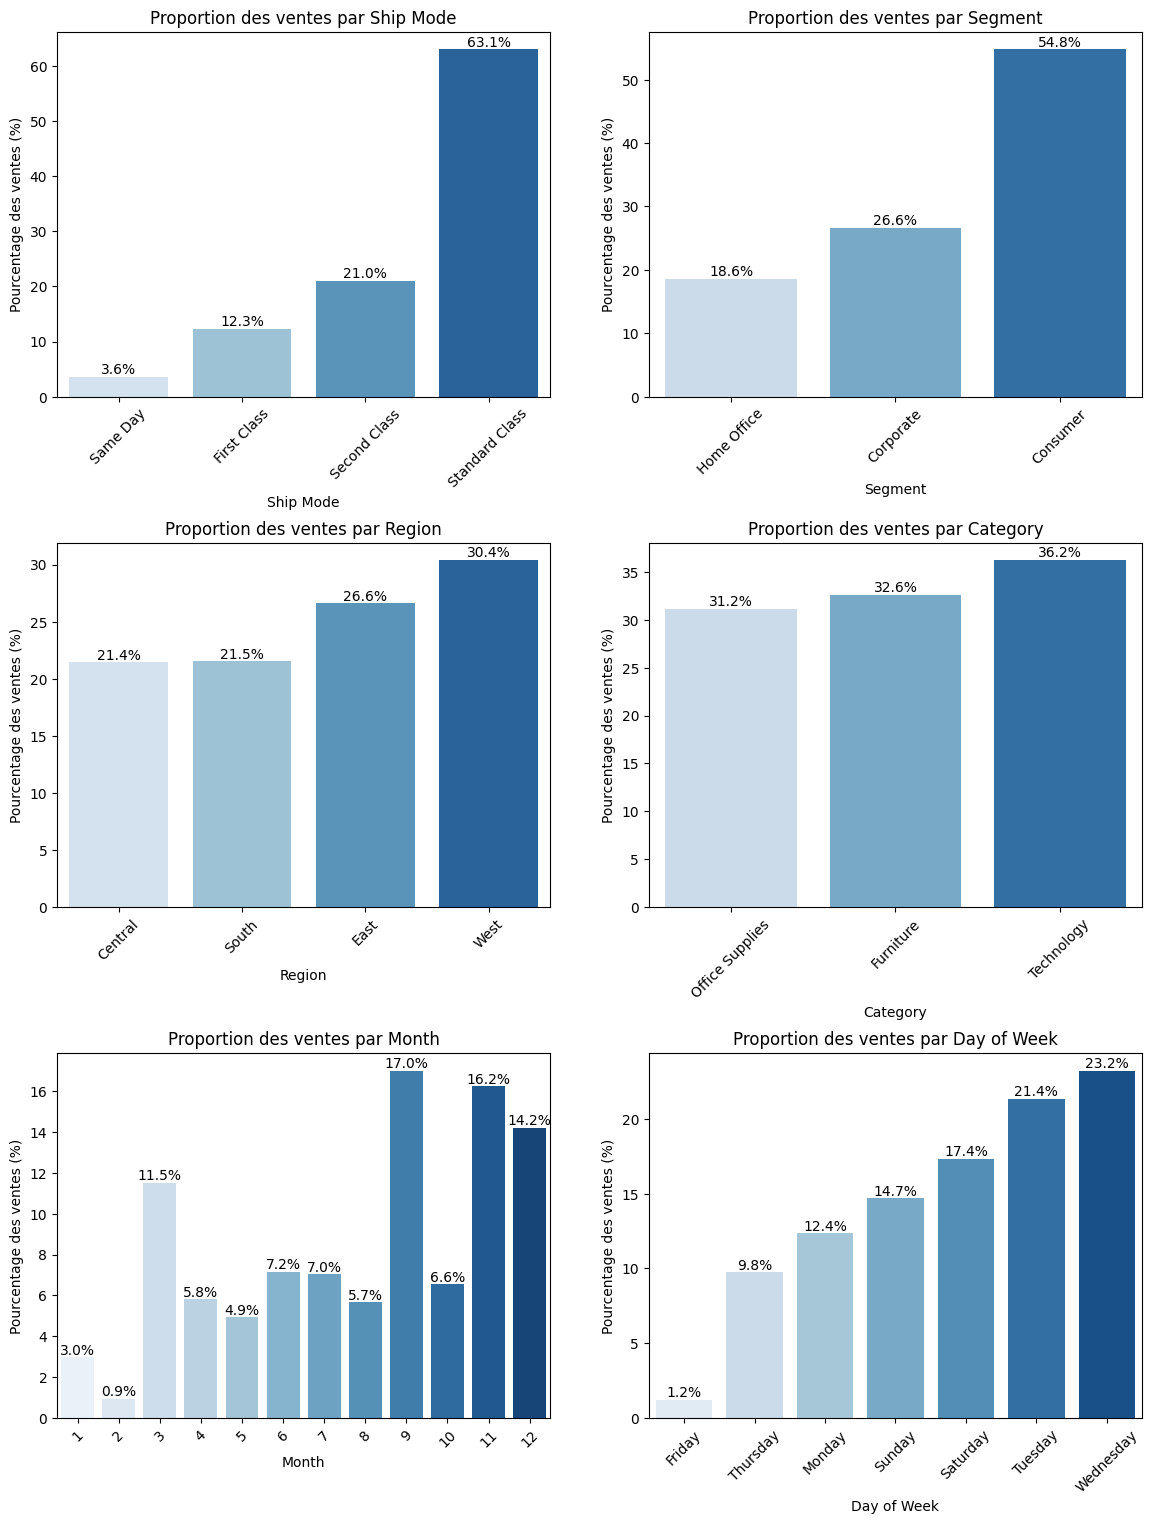

In [ ]:
analyse_pourcentage_ventes_par_categorie(2015)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()  # Crée une nouvelle figure
analyse_pourcentage_ventes_par_categorie(2016)
plt.savefig("ventes_par_categorie_2016.png", dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

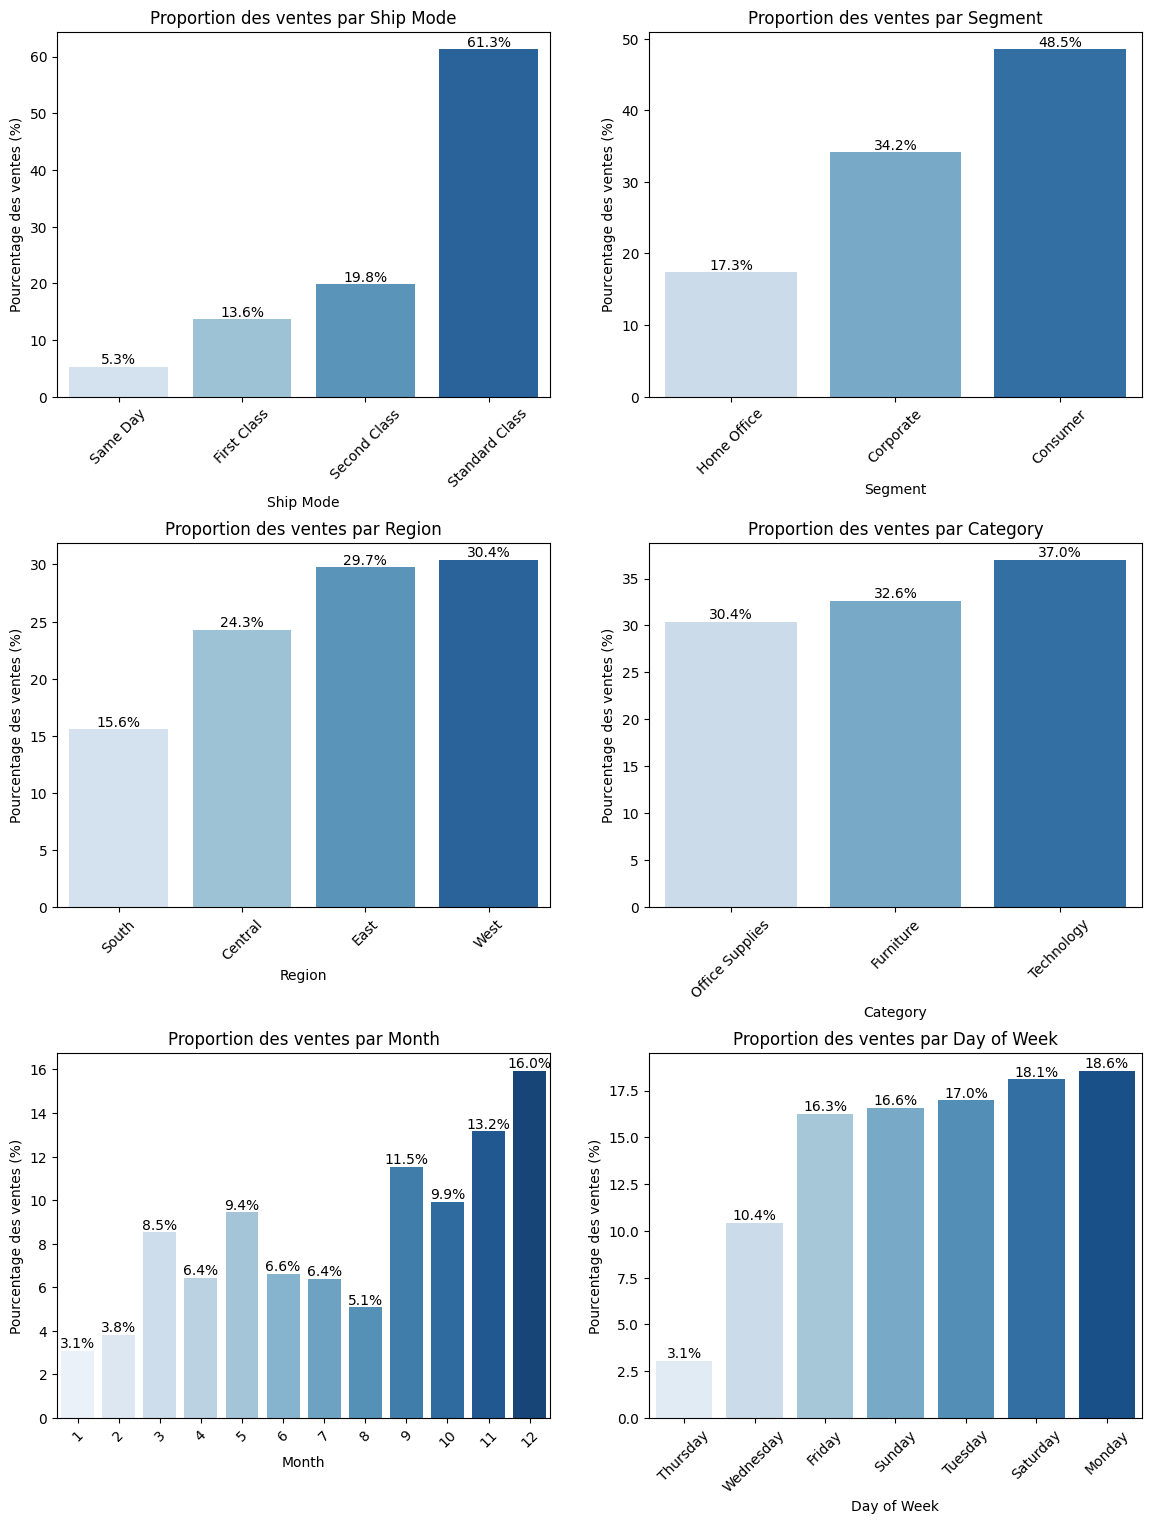

In [ ]:
analyse_pourcentage_ventes_par_categorie(2017)


<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-61-ab1374a5aa46>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

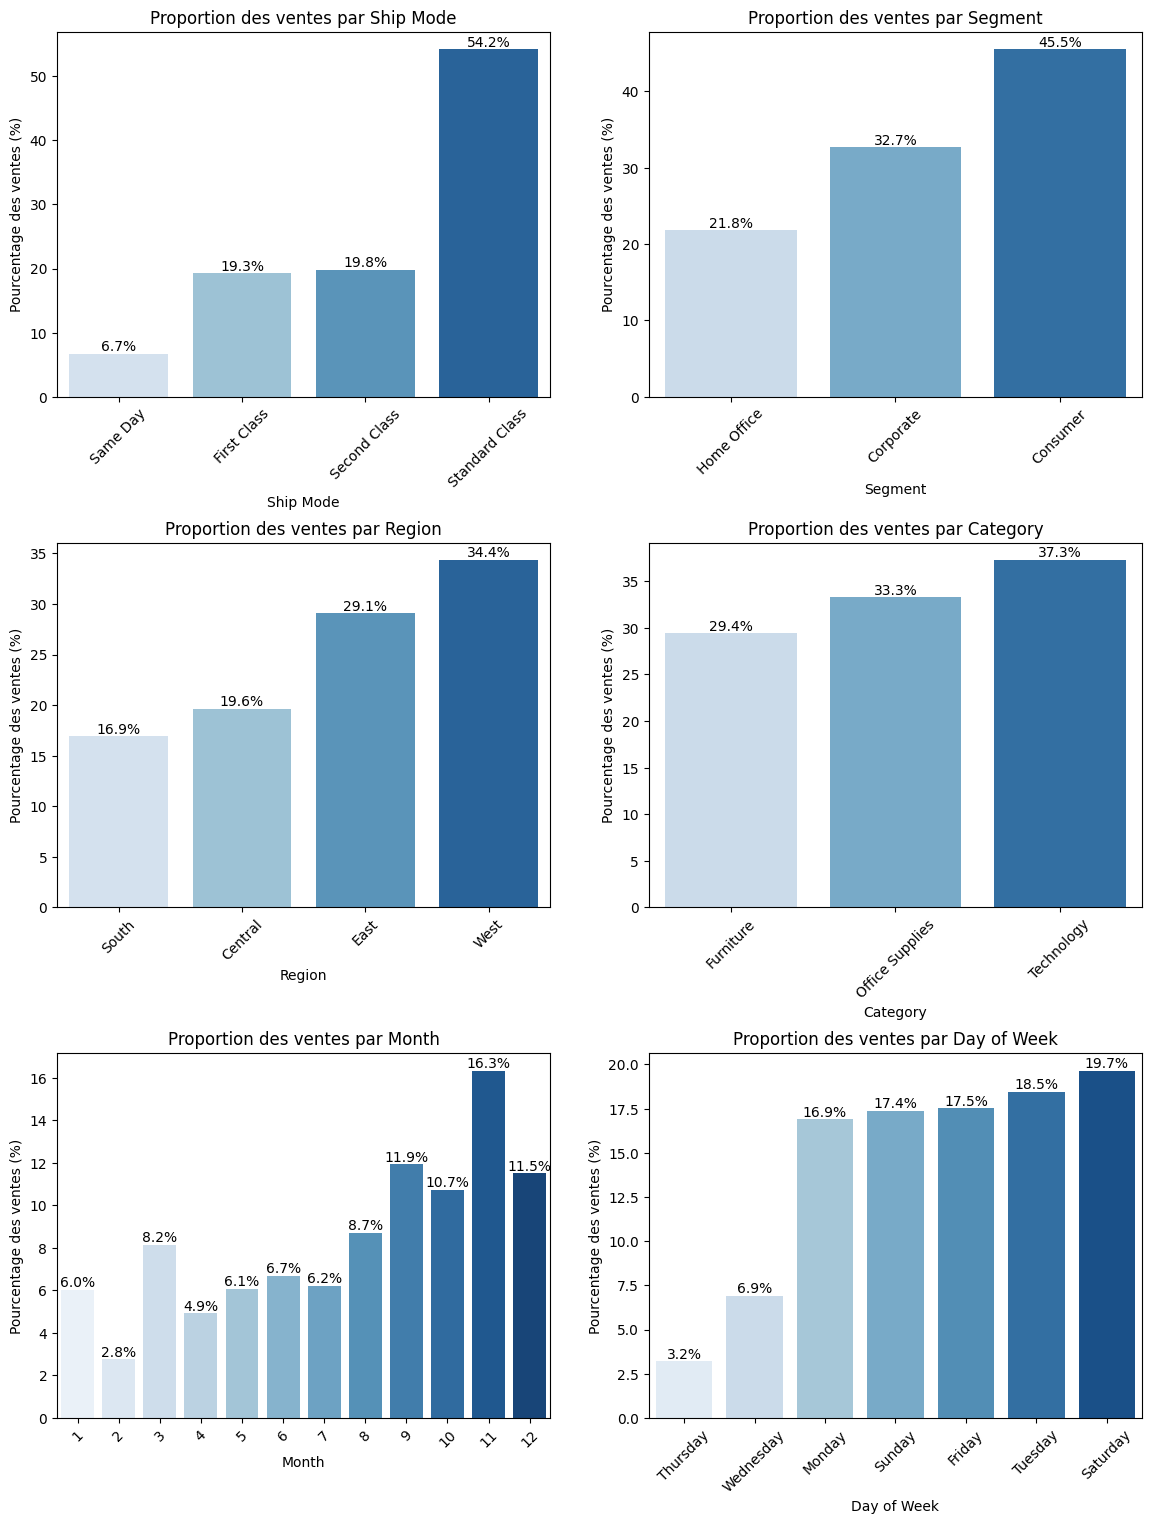

In [ ]:
analyse_pourcentage_ventes_par_categorie(2018)

In [ ]:
# On veut voir quels produits sont plus demandés en fonction des mois, s'il y a des patterns saisonniers
def categories_produits_par_mois_annee(year):
    plt.figure(figsize=(12, 6))
    df_year = df[df['Year'] == year]

    # Calcul des ventes totales par mois et par catégorie de produit selon l'année choisie
    sales_by_month_product = df_year.groupby(['Month', 'Category'])['Sales'].sum().unstack()

    sales_by_month_product.plot(kind='bar', stacked=True, colormap='Set2', width=0.7, ax=plt.gca())

    plt.title(f'Ventes par mois en {year} avec détail par catégorie')
    plt.ylabel('Total des ventes (€)')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.legend(title='Category')

    plt.show()


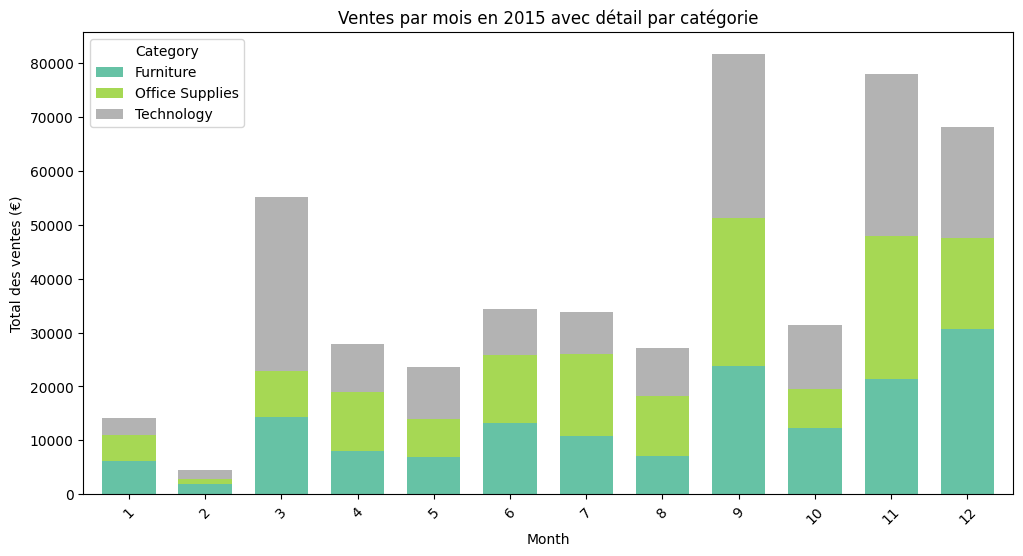

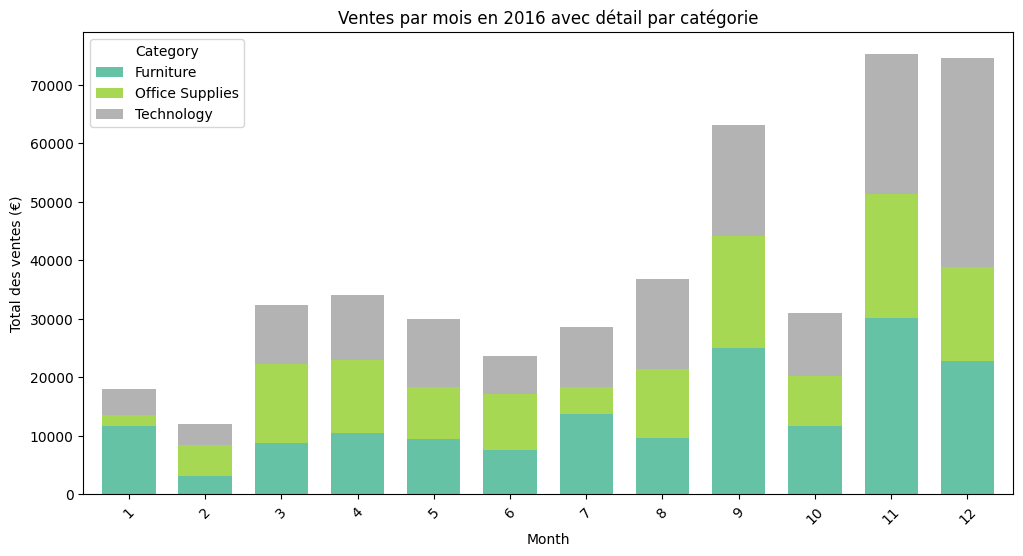

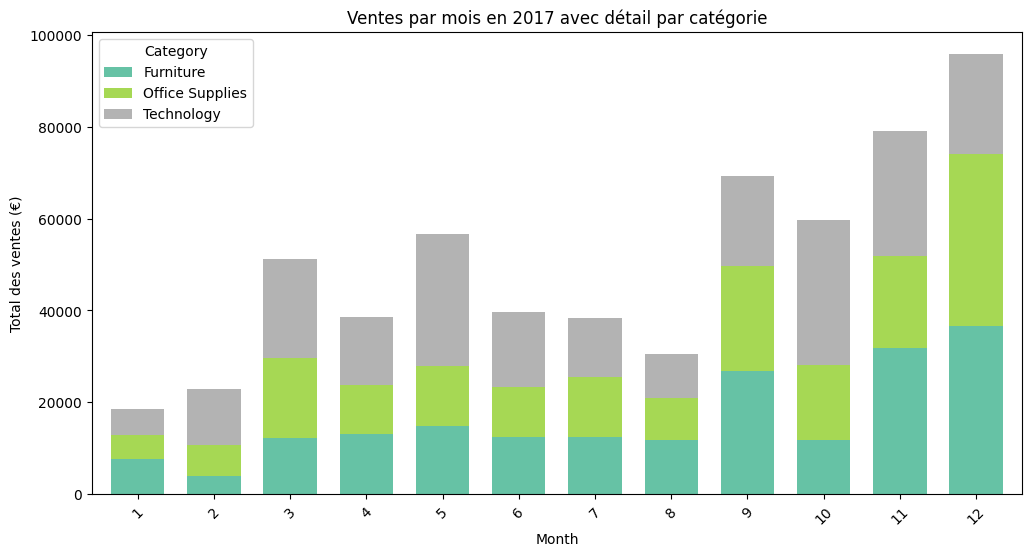

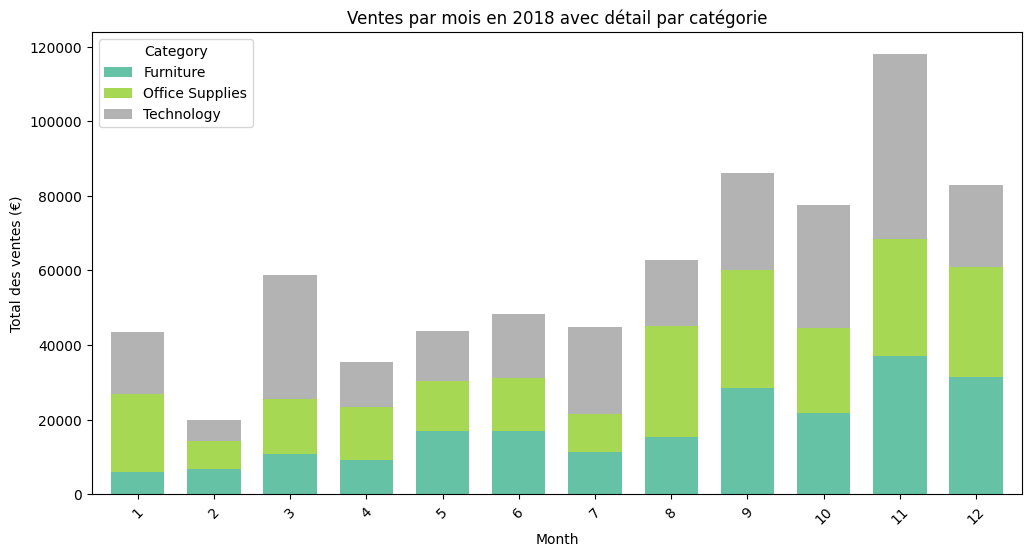

In [ ]:
years=[2015,2016,2017,2018]
for year in years:
  categories_produits_par_mois_annee(year)

Pour toutes les années on observe que les ventes s'accroissent considérablement vers la fin de l'année, notamment à partir de septembre. On pourrait supposer que c'est dû aux réductions en liaison avec le Black Friday ou les réductions de fin d'année, ainsi que les besoin accrus de technologies et fournitures pour la rentrée scolaire. Une fois on a observé une demande plus importante vers la fin de l'année on veut afficher la répartition des catégories de produits par mois en base 100% pour voir si les clients ont tendance à acheter des catégories de produits spécifiques à des périodes particulières de l'année.

<Figure size 1200x600 with 0 Axes>

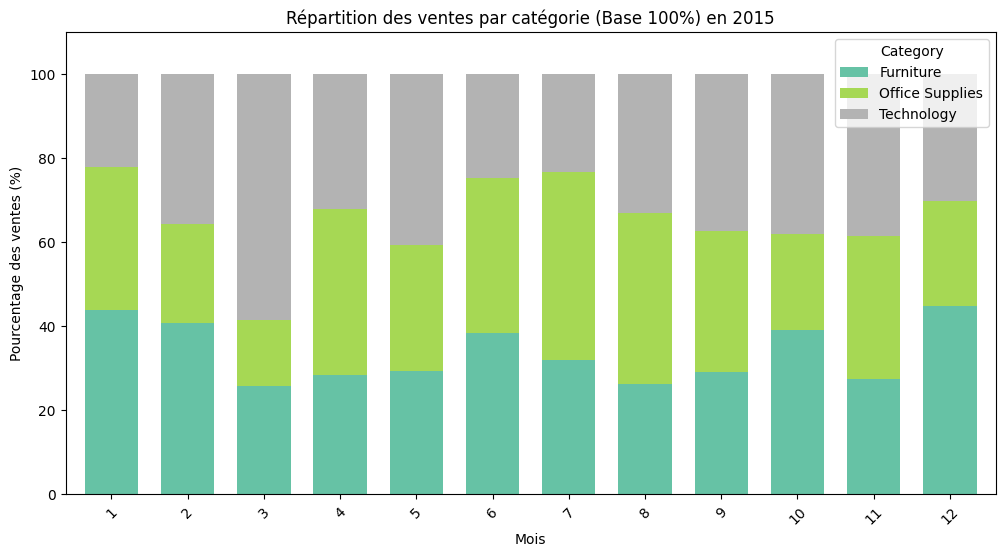

<Figure size 1200x600 with 0 Axes>

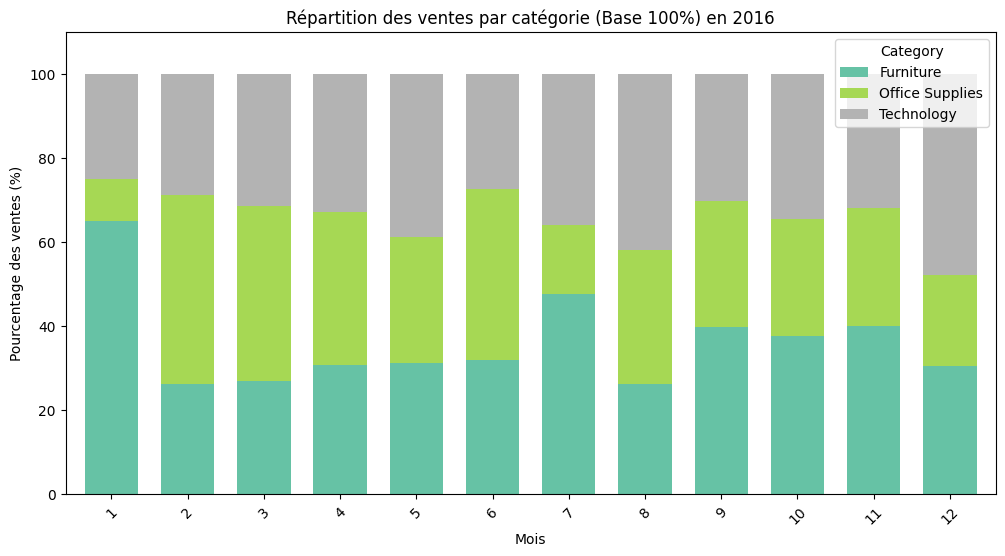

<Figure size 1200x600 with 0 Axes>

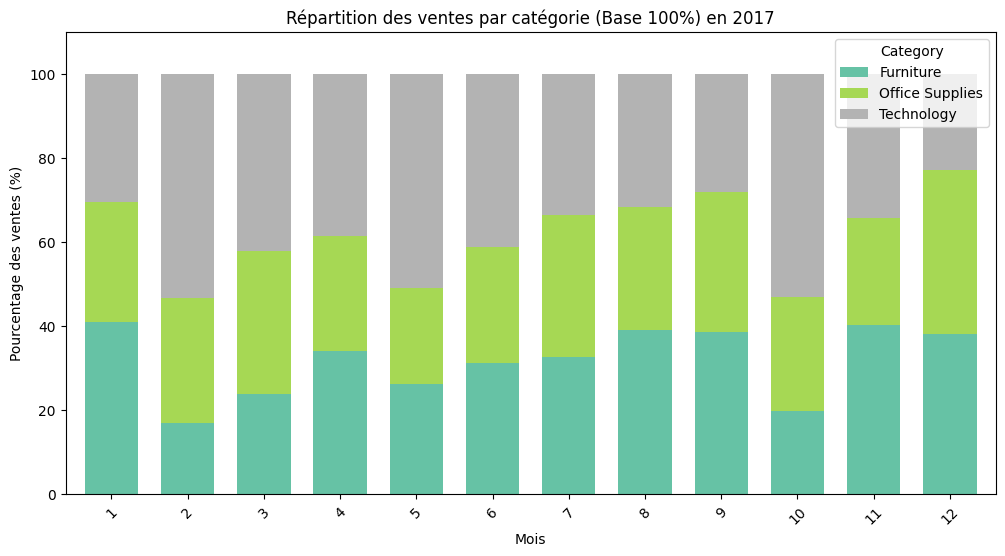

<Figure size 1200x600 with 0 Axes>

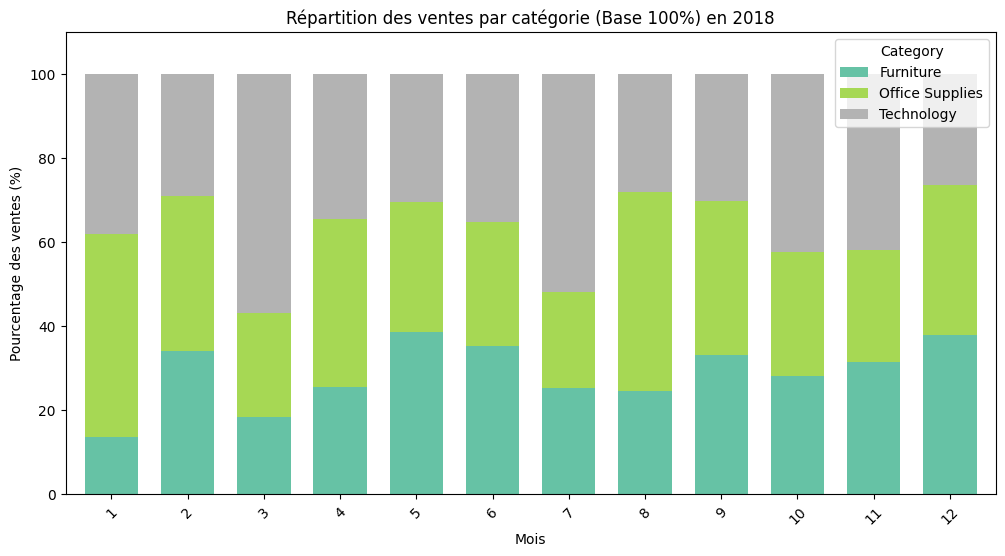

In [ ]:
def categories_de_produits_par_mois_base_100(year):
    plt.figure(figsize=(12, 6))
    df_year = df[df['Year'] == year]

    # Calcul des ventes totales par mois et par catégorie de produit selon l'année choisie
    sales_by_month_product = df_year.groupby(['Month', 'Category'])['Sales'].sum().unstack()

    # Chaque mois = base 100
    sales_percentage = sales_by_month_product.div(sales_by_month_product.sum(axis=1), axis=0) * 100

    ax = sales_percentage.plot(kind='bar', stacked=True, colormap='Set2', width=0.7, figsize=(12, 6))

    plt.title(f'Répartition des ventes par catégorie (Base 100%) en {year}')
    plt.ylabel('Pourcentage des ventes (%)')
    plt.xlabel('Mois')
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.ylim(0, 110)

    plt.show()

for year in years:
    categories_de_produits_par_mois_base_100(year)


On veut maintenant savoir si la granularité des clients de l'entreprise est importante ou si, au contraire, les ventes reposent sur quelques clients qui sont responsables pour une grande majorité du chiffre d'affaires.

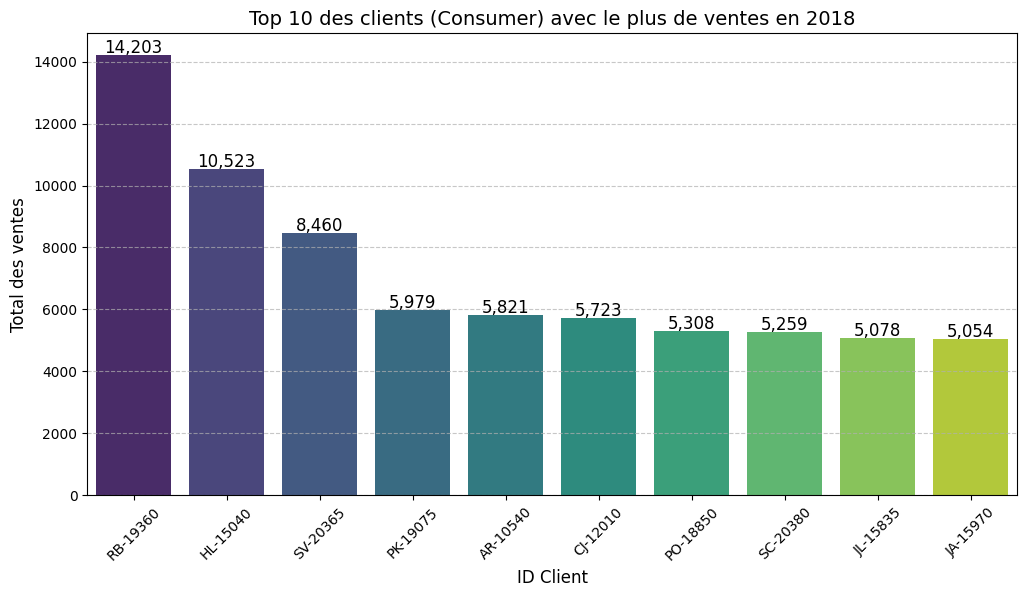

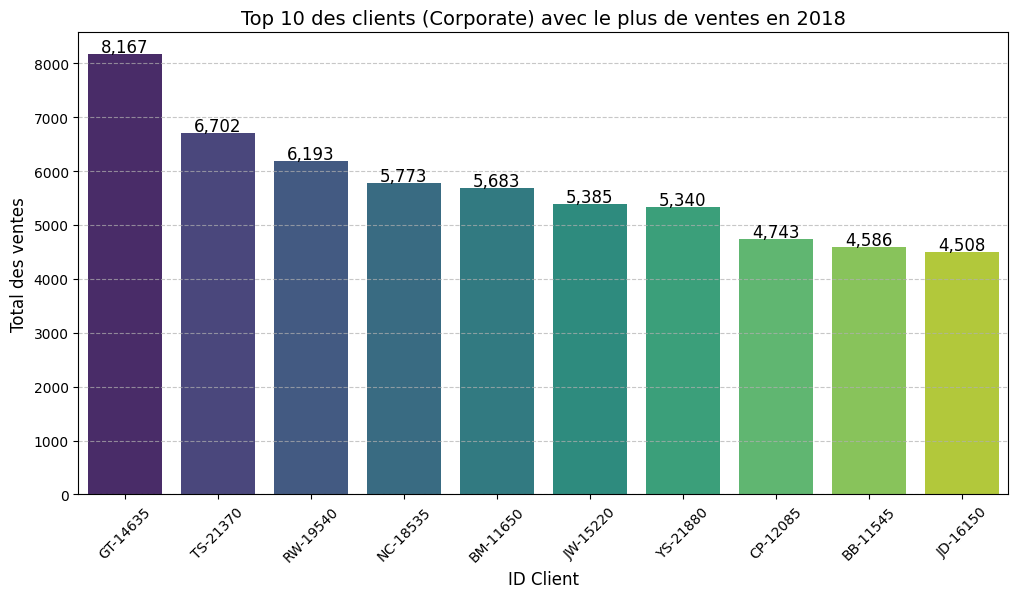

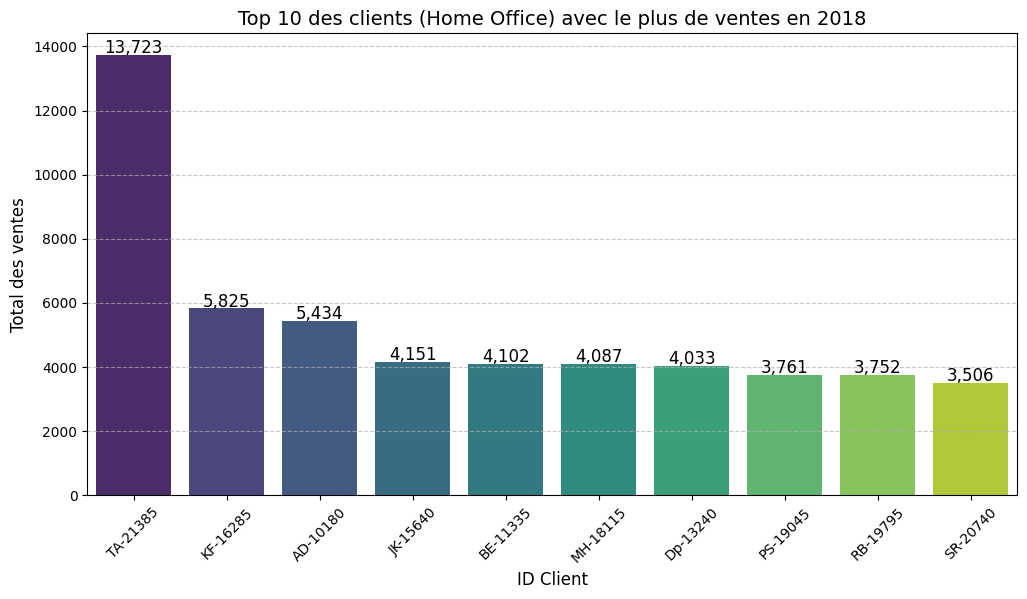

In [ ]:
def top_clients_par_segment(segment_name, year):
    df_segment = df[(df["Segment"] == segment_name) & (df["Year"] == year)]
    ventes_par_client = df_segment.groupby(['Customer ID'])['Sales'].sum().reset_index(name='Total des ventes')
    ventes_par_client_sorted = ventes_par_client.sort_values(by='Total des ventes', ascending=False)
    top_10_clients_ventes = ventes_par_client_sorted.head(10)

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Customer ID', y='Total des ventes', data=top_10_clients_ventes, palette='viridis')


    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')

    # Mise en forme
    plt.title(f'Top 10 des clients ({segment_name}) avec le plus de ventes en {year}', fontsize=14)
    plt.xlabel('ID Client', fontsize=12)
    plt.ylabel('Total des ventes', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    plt.show()

# Regardons pour l'année 2018 si on a des clients très importants ou  bien une forte granularité
top_clients_par_segment("Consumer", 2018)
top_clients_par_segment("Corporate", 2018)
top_clients_par_segment("Home Office", 2018)


La conclusion est que certes il y a quelques clients avec des montants de commande importants, cependant le chiffre d'affaires repose sur un grand nombre de petits clients plutôt qu'un petit nombre de gros clients.

#### Tendance des ventes par semaine, mois, année

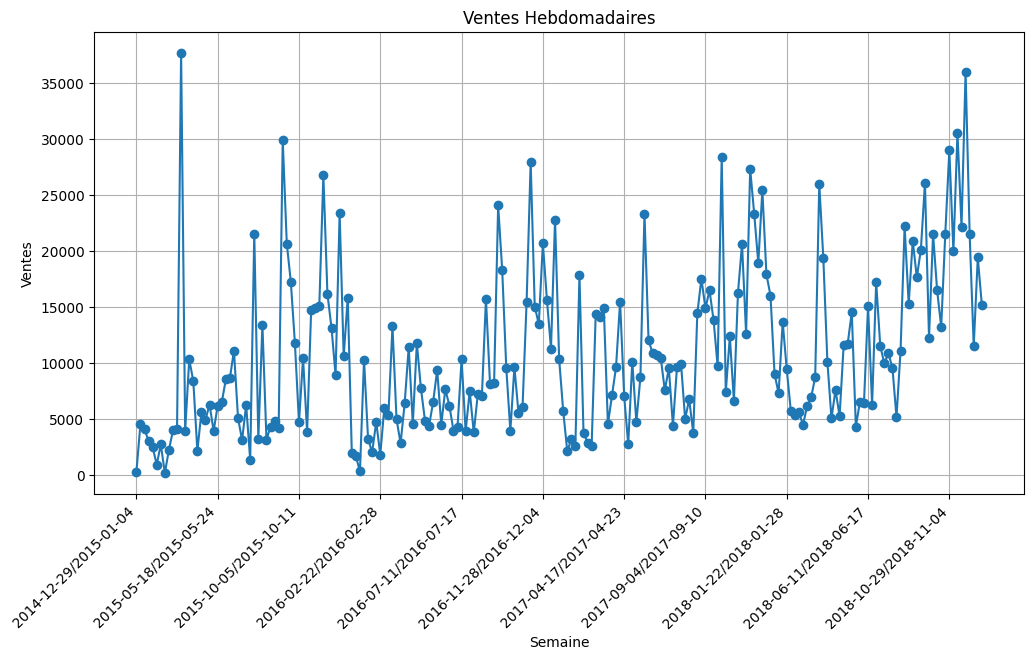

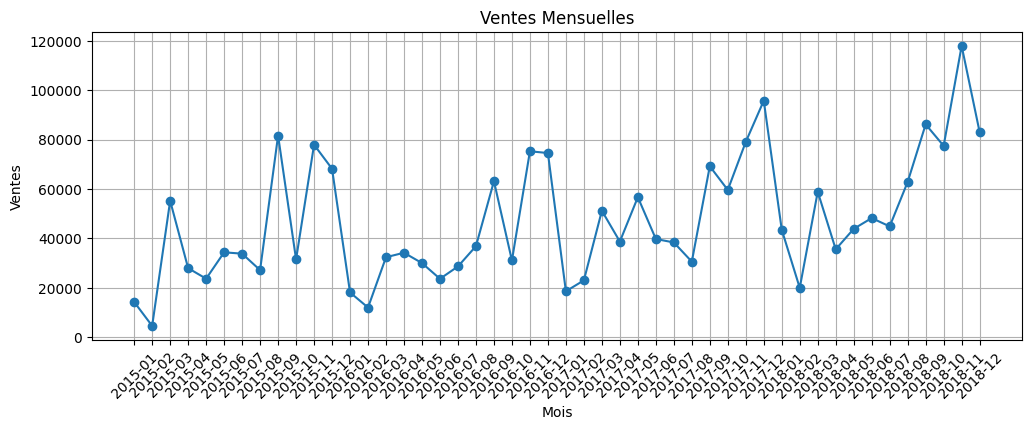

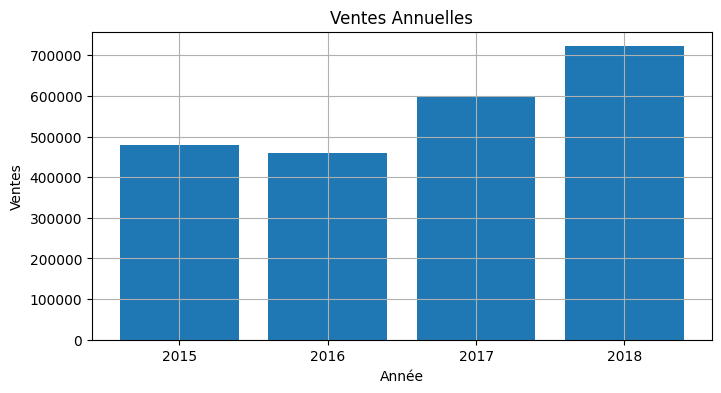

In [ ]:
# On crée un nouveau DF uniquement pour ce graphique pour ne pas alourdir le DF principal
df_graphique=df.copy()

df_graphique['Month_Year'] = df_graphique['Order Date'].dt.to_period('M')  # Format AAAA-MM
df_graphique['Week_year'] = df_graphique['Order Date'].dt.to_period('W')   # Format AAAA-WNN

# Agrégation des ventes
weekly_sales = df_graphique.groupby('Week_year')['Sales'].sum()
monthly_sales = df_graphique.groupby('Month_Year')['Sales'].sum()
annual_sales = df_graphique.groupby('Year')['Sales'].sum()

# Graphes
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales.index.astype(str), weekly_sales.values, marker='o', linestyle='-')
plt.xticks(ticks=range(0, len(weekly_sales), max(1, len(weekly_sales) // 10)), labels=weekly_sales.index.astype(str)[::max(1, len(weekly_sales) // 10)],rotation=45, ha='right')
plt.title('Ventes Hebdomadaires')
plt.xlabel('Semaine')
plt.ylabel('Ventes')
plt.grid()

plt.show()

plt.figure(figsize=(12, 4))
plt.plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.title('Ventes Mensuelles')
plt.xlabel('Mois')
plt.ylabel('Ventes')
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(annual_sales.index.astype(str), annual_sales.values)
plt.title('Ventes Annuelles')
plt.xlabel('Année')
plt.ylabel('Ventes')
plt.grid()
plt.show()


#### Ventes par jour de la semaine

In [ ]:

def heatmap_ventes_par_jour(df):
    total_sales = df["Sales"].sum()
    sales_by_day = df.groupby('Day of Week')['Sales'].sum()
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sales_by_day = sales_by_day.reindex(ordered_days) / total_sales * 100
    sales_df = pd.DataFrame({'Day': sales_by_day.index, 'Sales': sales_by_day.values})

    # Heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(sales_df[['Sales']].T, annot=True, fmt='.2f', cmap='Blues', cbar=True,
                      xticklabels=sales_df['Day'], yticklabels=['Ventes'])

    for text in ax.texts:
        text.set_text(f'{float(text.get_text()):.2f}%')
    plt.xticks(rotation=45)

    plt.title('Ventes par jour de la semaine')
    plt.xlabel('Jour de la semaine')
    plt.ylabel('')
    plt.show()

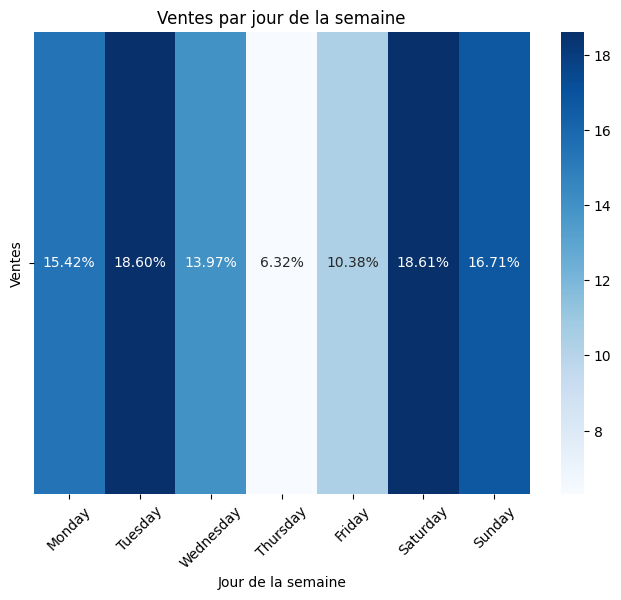

In [ ]:
heatmap_ventes_par_jour(df)

#### Ventes par région/segment

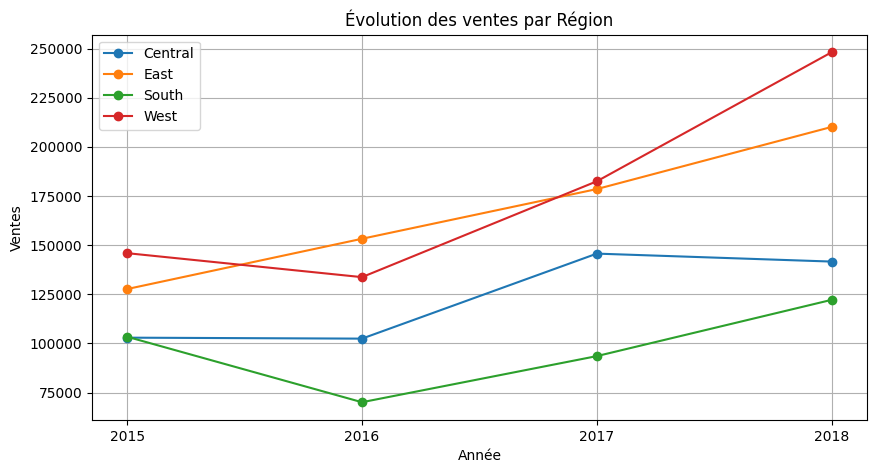

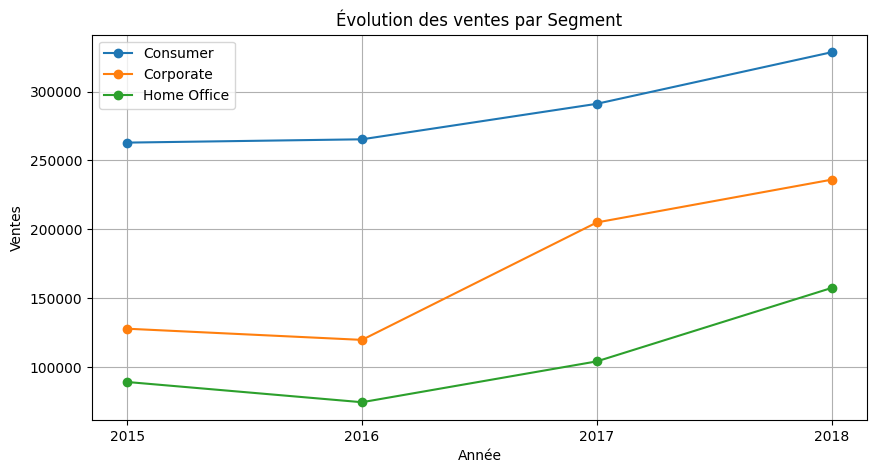

In [ ]:
# Agrégation les ventes par année et par région
region_sales = df.groupby(['Year', 'Region'])['Sales'].sum().reset_index()

# Graphique des ventes par région
plt.figure(figsize=(10, 5))
for region in region_sales['Region'].unique():
    data = region_sales[region_sales['Region'] == region]
    plt.plot(data['Year'], data['Sales'], marker='o', linestyle='-', label=region)

plt.xlabel("Année")
plt.ylabel("Ventes")
plt.title("Évolution des ventes par Région")
plt.legend()
plt.grid()
plt.xticks(region_sales['Year'].unique())  # Affichage des années
plt.show()

# Agrégation les ventes par année et par segment
segment_sales = df.groupby(['Year', 'Segment'])['Sales'].sum().reset_index()

# Graphique des ventes par segment
plt.figure(figsize=(10, 5))
for segment in segment_sales['Segment'].unique():
    data = segment_sales[segment_sales['Segment'] == segment]
    plt.plot(data['Year'], data['Sales'], marker='o', linestyle='-', label=segment)

plt.xlabel("Année")
plt.ylabel("Ventes")
plt.title("Évolution des ventes par Segment")
plt.legend()
plt.grid()
plt.xticks(segment_sales['Year'].unique())
plt.show()


#### Filtrage par moyenne mobile

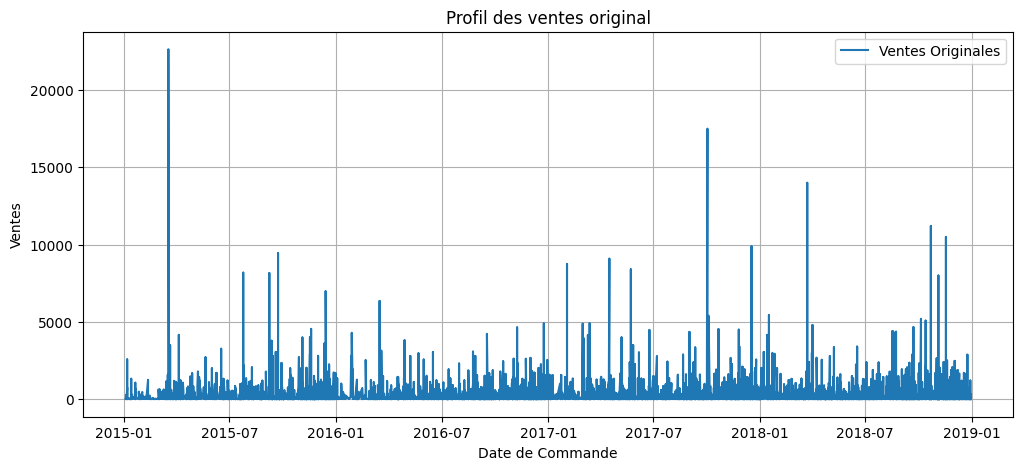

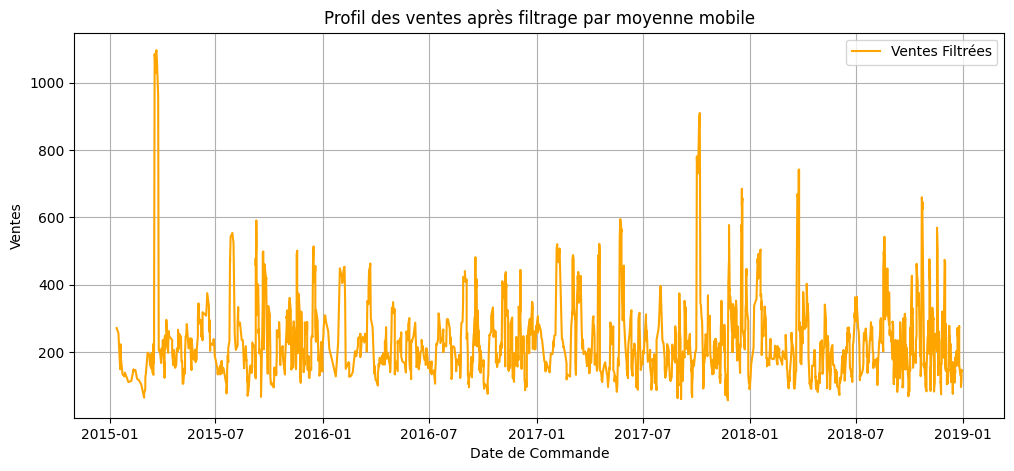

In [ ]:
df = df.sort_values(by='Order Date')

plt.figure(figsize=(12, 5))
plt.plot(df['Order Date'], df['Sales'], linestyle='-', label='Ventes Originales')
plt.xlabel("Date de Commande")
plt.ylabel("Ventes")
plt.title("Profil des ventes original")
plt.grid()
plt.legend()
plt.show()

# Appliquer la moyenne mobile avec une fenêtre de 30 jours et un pas de 5 jours
window_size = 30
stride = 5
df['Sales_Smoothed'] = df['Sales'].rolling(window=window_size).mean()[::stride]

# Supprimer les NaN (au début à cause du rolling)
df_filtered = df.dropna(subset=['Sales_Smoothed'])

# Profil des ventes après filtrage
plt.figure(figsize=(12, 5))
plt.plot(df_filtered['Order Date'], df_filtered['Sales_Smoothed'], linestyle='-', label='Ventes Filtrées', color='orange')
plt.xlabel("Date de Commande")
plt.ylabel("Ventes")
plt.title("Profil des ventes après filtrage par moyenne mobile")
plt.grid()
plt.legend()
plt.show()


**1. Profil des ventes original :**





*   Données brutes des ventes affichées sur la période 2015-2019.
*   Variabilité élevée avec des pics très marqués, indiquant des ventes irrégulières.
*   Présence de valeurs extrêmes (pics de vente), probablement dus à des événements saisonniers ou promotions.
*   Difficile d’observer une tendance claire à cause du bruit et de la forte dispersion.


**2. Profil des ventes après filtrage par moyenne mobile :**


*   Lissage des variations brusques, ce qui permet de voir la tendance générale des ventes
*   Atténuation des pics : les grandes variations extrêmes sont réduites, mettant en évidence une tendance plus stable.
*   Tendance légèrement descendante dans les premières années, puis une stabilisation des ventes.
*   Les pics restent visibles mais plus adoucis, ce qui permet de mieux comprendre le comportement des ventes sans être perturbé par le bruit.








### Décomposition de la série temporelle des ventes

In [ ]:
def wavelet_ventes_par_jour(df, wavelet='db4', level=5, threshold_factor=1.5, threshold_mode='soft'):
    df_wavelet = df.groupby('Order Date')['Sales'].sum().reset_index()
    df_wavelet['Order Date'] = pd.to_datetime(df_wavelet['Order Date'], format="%d/%m/%Y")
    df_wavelet.set_index('Order Date', inplace=True)
    df_wavelet = df_wavelet.sort_index()

    # Décomposition en ondelettes
    sales_series = df_wavelet['Sales'].values
    coeffs = pywt.wavedec(sales_series, wavelet=wavelet, mode='sym', level=level)

    # Filtrage par seuil
    sigma = np.std(coeffs[1])
    threshold = threshold_factor * sigma * np.sqrt(2 * np.log(len(sales_series)))
    coeffs_denoised = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode=threshold_mode) for c in coeffs[1:]]

    # Reconstruction du signal après filtrage
    sales_wavelet_denoised = pywt.waverec(coeffs_denoised, wavelet=wavelet, mode='sym')
    sales_wavelet_denoised = sales_wavelet_denoised[:len(sales_series)]

    # Affichage des ventes originales vs celles filtrées
    plt.figure(figsize=(14, 7))
    plt.plot(df_wavelet.index, sales_series, label="Ventes originales", color='blue', alpha=0.5)
    plt.plot(df_wavelet.index, sales_wavelet_denoised, label="Ventes filtrées (ondelettes)", color='red')
    plt.title("Données de ventes avant et après le filtrage par ondelettes")
    plt.xlabel("Date")
    plt.ylabel("Ventes")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
ventes_par_jour = df.groupby('Order Date')['Sales'].sum().reset_index()
wavelet_ventes_par_jour(ventes_par_jour)


## Analyse de la série

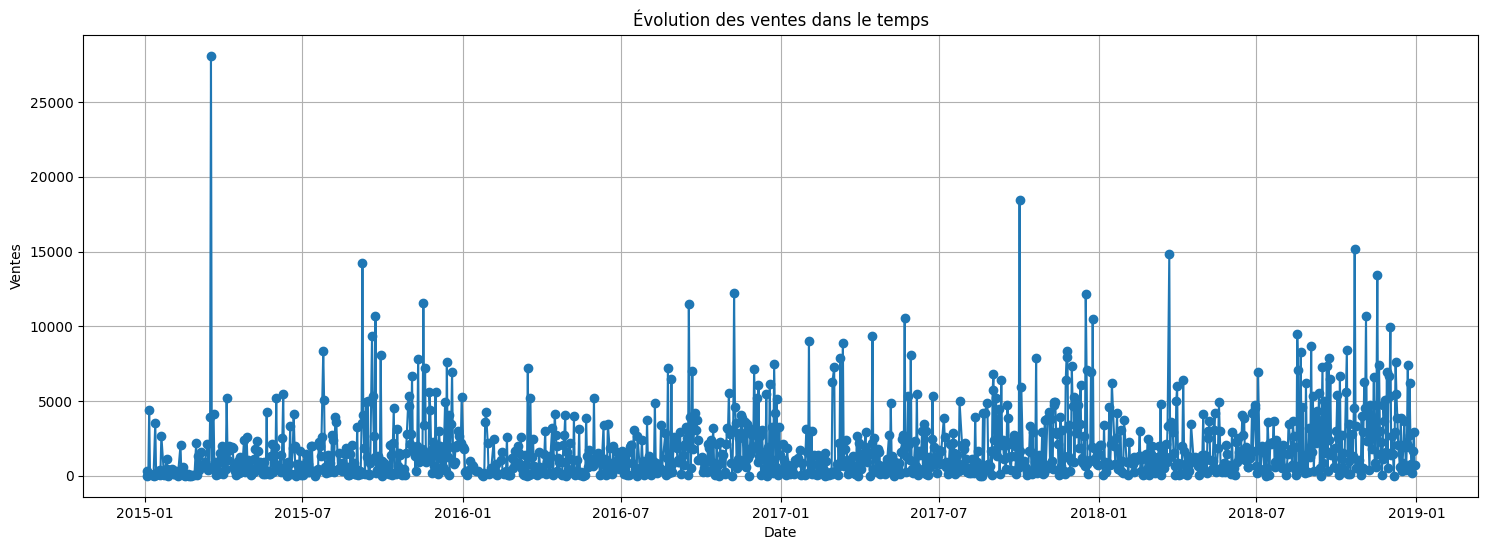

In [ ]:
#  Graphique
plt.figure(figsize=(18, 6))
plt.plot(ventes_par_jour['Order Date'], ventes_par_jour['Sales'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.title('Évolution des ventes dans le temps')
plt.grid()
plt.show()

In [ ]:
# Statistiques concernant les ventes agrégées par jour
ventes_par_jour["Sales"].describe()

count     1230.000000
mean      1838.647791
std       2295.418267
min          2.025000
25%        378.519000
50%       1058.397000
75%       2382.217000
max      28106.716000
Name: Sales, dtype: float64

On observe que la volatilité des ventes par jour est très importante au vu de l'écart-type. La moyenne est aussi beacoup plus élevée que la médiane => on a des outliers à droite, des jours avec des ventes très importantes.

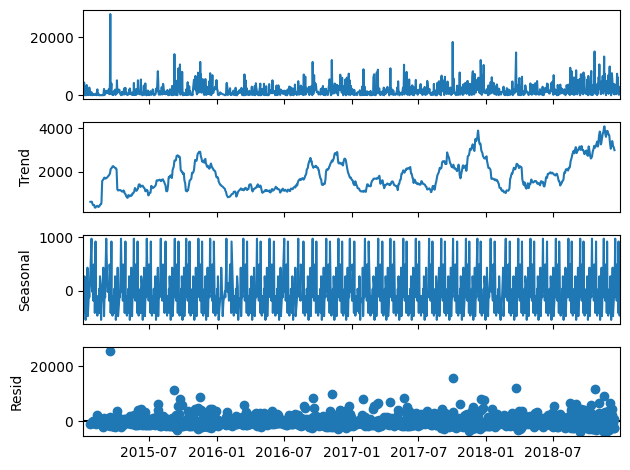

In [ ]:
# Décomposition de la série temporelle, on a supposé ici un modèle additif y(t)=Trend(t)+Seasonality(t)+Residuals(t) et une période de saisonnalité d'un mois
result = seasonal_decompose(ventes_par_jour.set_index('Order Date'), model='additive', period=30)
result.plot()
plt.show()

Une légère saisonnalité est visible. On pourrait dire également qu'une tendance à la hausse se distingue mais elle n'est pas très marquée.

In [ ]:
# Test de stationnarité (Dickey-Fuller)
dickey_fuller = adfuller(ventes_par_jour['Sales'])
print(f'ADF Statistic: {dickey_fuller[0]}')
print(f'p-value: {dickey_fuller[1]}')
if dickey_fuller[1] < 0.05:
    print("La série est stationnaire")
else:
    print("La série n'est pas stationnaire")


ADF Statistic: -5.761112092918489
p-value: 5.669526815779762e-07
La série est stationnaire


Une série chronologique est dite stationnaire lorsque ses propriétés statistiques restent constantes dans le temps.

Les séries non stationnaires présentent généralement des tendances, des saisonnalités ou d’autres motifs qui varient dans le temps, rendant les prévisions plus complexes.  


De nombreuses caractéristiques des séries temporelles, telles que la moyenne, la variance ou l’autocorrélation, présupposent que les données sont stationnaires. Si ce n’est pas le cas, ces mesures peuvent perdre leur pertinence ou être trompeuses.

Nous avons donc vérifié la stationnarité de notre série temporelle à l’aide du test d’Augmented Dickey-Fuller (ADF), et les résultats montrent que notre série est stationnaire (p-value < 0.05). Cela signifie que ses propriétés statistiques sont constantes dans le temps, ce qui nous permet de l’utiliser dans des modèles et des analyses qui nécessitent cette condition.

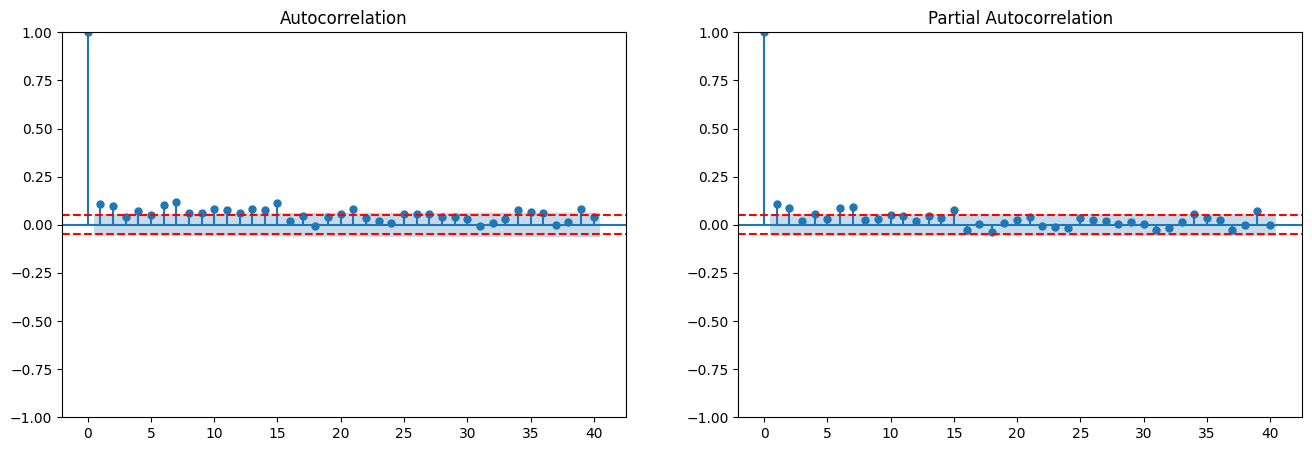

In [ ]:
# ACF et PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
acf_plot = sm.graphics.tsa.plot_acf(ventes_par_jour['Sales'], lags=40, ax=axes[0])
pacf_plot = sm.graphics.tsa.plot_pacf(ventes_par_jour['Sales'], lags=40, ax=axes[1])

for ax in axes:
    ax.axhline(y=0.05, color='red', linestyle='--')
    ax.axhline(y=-0.05, color='red', linestyle='--')

plt.show()


Le graphique ACF montre une forte corrélation au premier lag (lag(0)), ce qui est normal, puis une décroissance rapide des valeurs. La majorité des points restent dans les bandes de confiance, indiquant une faible autocorrélation sur plusieurs périodes. Cela suggère que la série est relativement stationnaire et ne présente pas de dépendance temporelle marquée. Cela rejoint la conclusion du test Dickey-Fuller.

## Prophet

Prophet https://facebook.github.io/prophet/

Prophet est une méthode de prévision des séries temporelles basée sur un modèle additif où les tendances non linéaires sont ajustées en tenant compte de la saisonnalité annuelle, hebdomadaire et quotidienne, ainsi que des effets des jours fériés.  

Il fonctionne particulièrement bien avec des séries temporelles présentant de forts effets saisonniers et disposant de plusieurs saisons de données historiques.  

Prophet est robuste aux données manquantes, aux changements de tendance et gère généralement bien les valeurs aberrantes.

In [ ]:
#  Données pour Prophet
df_prophet = ventes_par_jour.rename(columns={"Order Date": "ds", "Sales": "y"})
m = Prophet()
m.fit(df_prophet)

# On choisit de prédire pour 90j
future = m.make_future_dataframe(periods=90)
future.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5jaznlrn/s8g1rvf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5jaznlrn/lbfq4nlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4798', 'data', 'file=/tmp/tmp5jaznlrn/s8g1rvf7.json', 'init=/tmp/tmp5jaznlrn/lbfq4nlz.json', 'output', 'file=/tmp/tmp5jaznlrn/prophet_modele8_4mmhw/prophet_model-20250219230642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
1315 2019-03-26
1316 2019-03-27
1317 2019-03-28
1318 2019-03-29
1319 2019-03-30

In [ ]:
# Génération des prévisions
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
1315 2019-03-26  2911.201857    39.426020  5619.425410
1316 2019-03-27  2381.586910  -745.127280  5024.216258
1317 2019-03-28  1742.875743 -1008.019635  4400.853090
1318 2019-03-29  2304.271014  -369.342102  5229.904471
1319 2019-03-30  2681.807144   -85.260648  5363.331543

  En effet, on voit que l'intervalle de confiance est très étendu. Les prévisions ont l'air d'être assez imprécises, il y a une forte incertitude. Cela pourrait être dû au fait que nos données ne présentent pas une saisonnalité très prononcée; En plus nos données présentent une forte variabilité (on l'a vu sur l'écart-type très important).

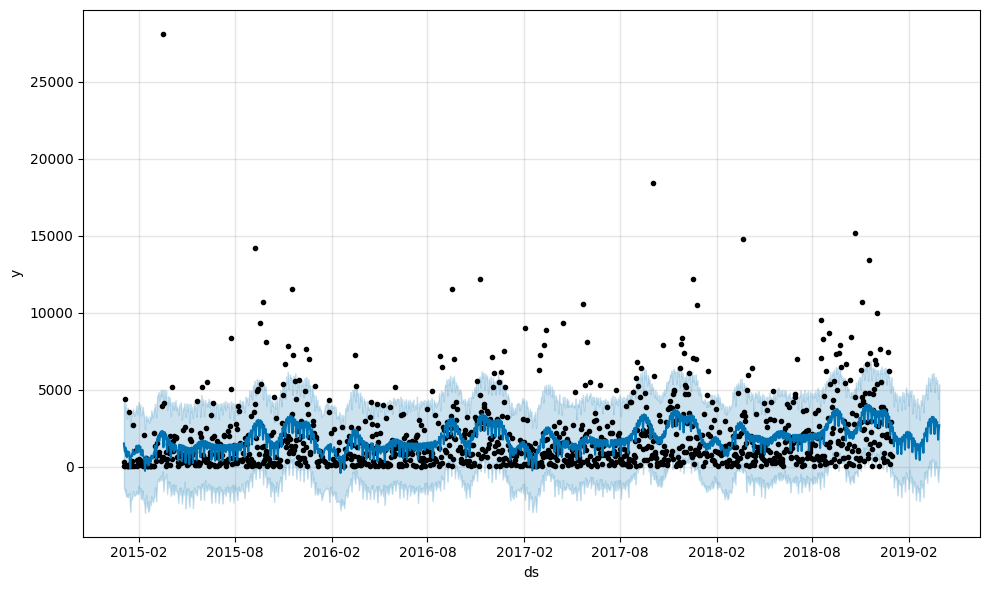

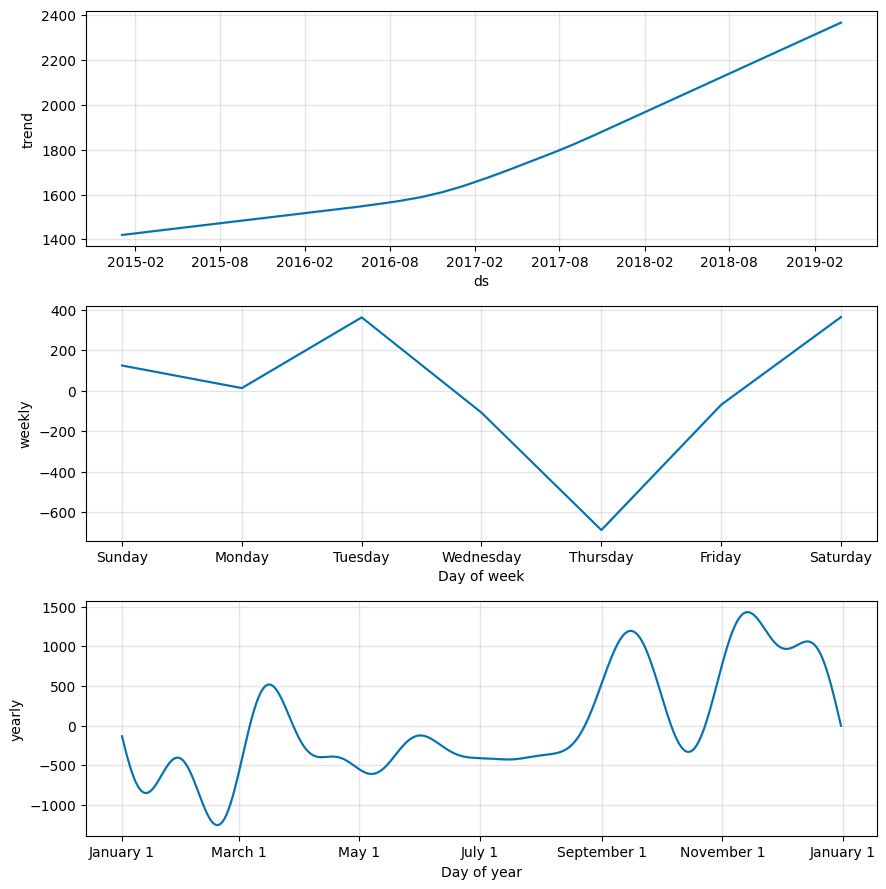

In [ ]:
# Prévisions
fig1 = m.plot(forecast)
# Décomposition
fig2 = m.plot_components(forecast)

Ce graphique montre plusieus choses qu'on a pu déduire dans la partie EDA. Une tendance générale à la hausse a été observée au niveau des ventes par année depuis 2015. Cela se voit sur le graphique "trend". De plus, on a vu à l'aide du heatmap que jeudi il y a le moins de ventes (il faudrait davantage analyser le cas de ce magasin pour comprendre les raisons derrière) : uniquement 6% des commandes ont été passées le jeudi sur ces 4 ans.
Dernièrement, on a également observé qu'il y a une tendance à la hausse des ventes vers la fin de l'année. Cela pourrait être dû à la rentrée scolaire ou aux réductions liées aux fêtes de fin d'année par exemple. Ce pattern se reflète sur le dernier graphique "yearly".

In [ ]:
# Graphique intéractif
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



# Feature Engineering

### Création des lags

Dans une prédiction multi-horizon, l’utilisation des lags permet de capturer les dépendances temporelles et les effets saisonniers. Cependant, tous les lags ne sont pas utilisables selon l’horizon de prédiction.

Lorsqu’on cherche à prédire les ventes sur une période d'un mois (30 jours), il est crucial de vérifier si les lags sont disponibles. Les lags inférieurs à 30 jours ne peuvent pas être utilisés, car ils correspondent à des données futures qui ne seront pas accessibles au moment de la prédiction. En effet, si nous voulons prédire à un horizon de 30 jours ou plus, ces lags n’ont pas de valeur historique à fournir dans le cadre de notre modèle.

Nous avons donc décidé d’intégrer les lags supérieurs à 30 jours. Cela permet de capturer des dépendances à long terme, en nous concentrant sur des périodes significatives de trois à cinq mois en arrière. En analysant la Partial Autocorrelation Function (PACF), plusieurs lags se sont révélés particulièrement significatifs :
34, 39, 70, 89, 104, 109 jours.

Ces lags seront ajoutés comme nouvelles variables explicatives dans la série temporelle. Ils sont essentiels pour améliorer la qualité des prédictions, car ils permettent au modèle de prendre en compte des comportements cycliques ou des tendances passées qui influencent les ventes actuelles.

Cette approche garantit également que le modèle ne dépendra pas de données inaccessibles, tout en capturant des patterns temporels essentiels pour une prédiction robuste.


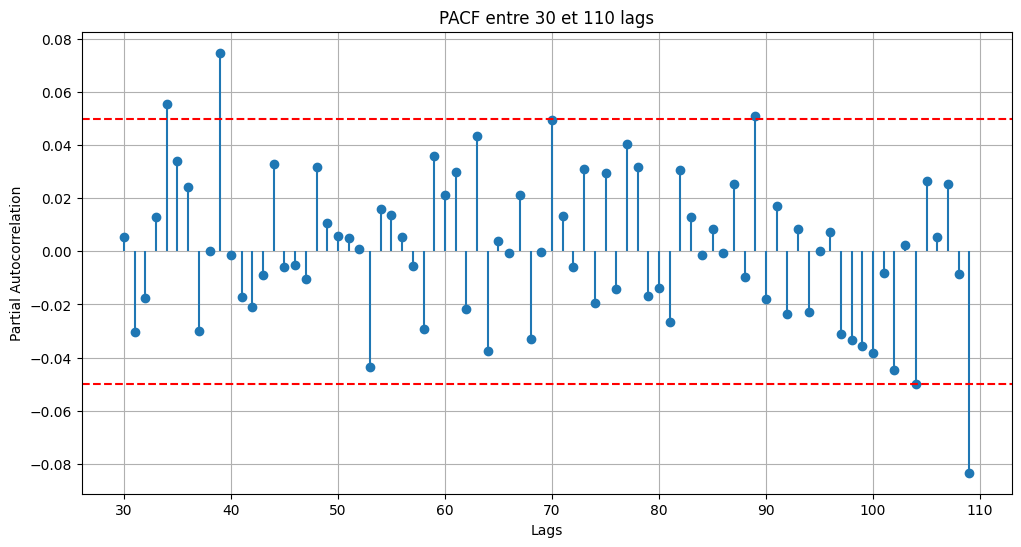

In [ ]:
# Calcul des valeurs PACF jusqu'à 110 lags
pacf_values = sm.tsa.pacf(ventes_par_jour['Sales'], nlags=110)

# Visualisation uniquement entre les lags 30 et 110
plt.figure(figsize=(12, 6))
plt.stem(range(30, 110), pacf_values[30:110], basefmt=" ")
plt.axhline(y=0.05, color='red', linestyle='--')
plt.axhline(y=-0.05, color='red', linestyle='--')
plt.title("PACF entre 30 et 110 lags")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.grid(True)
plt.show()

In [ ]:
def creer_lags_jours(df, colonne, lags, colonne_date='Order Date'):
    # Créez une copie du DataFrame pour éviter de modifier l'original
    df_copy = df.copy()

    # Créez les décalages
    for lag in lags:
        nom_colonne_lag = f"{colonne}_lag_{lag}_jour"
        df_copy[nom_colonne_lag] = df_copy[colonne].shift(lag)

    return df_copy

# Utilisation
lags = [34, 39,50, 70, 89, 104, 109]
df_daily = creer_lags_jours(ventes_par_jour, colonne='Sales', lags=lags)

## rolling windows

L’utilisation des fenêtres glissantes est une méthode essentielle pour explorer et analyser des séries temporelles. Elle permet de calculer des statistiques locales sur des sous-ensembles glissants de données, révélant ainsi des tendances locales, des périodes de volatilité et des points extrêmes sur différentes échelles temporelles.

Dans notre analyse, nous avons appliqué des fenêtres glissantes de tailles 31, 38, 45, 60, 90 jours sur la colonne des ventes en se basant sur le même principe de disponibilité des informations que aec les lags. Chaque taille de fenêtre est choisie pour analyser les données à différentes échelles temporelles. Pour chaque fenêtre, nous avons calculé :

- Moyenne glissante (mean) : permet d’atténuer les fluctuations journalières et d’identifier la tendance à court, moyen ou long terme.
- Minimum glissant (min) : met en évidence les baisses importantes des ventes, ce qui peut être utile pour détecter des périodes de faible demande.
- Maximum glissant (max) : identifie les pics de ventes sur différentes périodes, utile pour repérer les événements saisonniers ou exceptionnels.
- Écart-type glissant (std) : mesure la volatilité des ventes, reflétant la variabilité autour de la moyenne. Une augmentation de l’écart-type peut signaler une instabilité ou une anomalie dans les données.


In [ ]:
def appliquer_fenetre_roulante(df, colonne, tailles_fenetre):

    for taille in tailles_fenetre:
        nom_fenetre = f"{taille}_jours"
        df[f'{colonne}_moyenne_{nom_fenetre}'] = df[colonne].rolling(window=taille).mean()
        df[f'{colonne}_min_{nom_fenetre}'] = df[colonne].rolling(window=taille).min()
        df[f'{colonne}_max_{nom_fenetre}'] = df[colonne].rolling(window=taille).max()
        df[f'{colonne}_ecart_type_{nom_fenetre}'] = df[colonne].rolling(window=taille).std()
    return df

tailles_fenetre = [31, 38, 45, 60, 90]
df_fenetre = appliquer_fenetre_roulante(df_daily, colonne='Sales', tailles_fenetre=tailles_fenetre)

In [ ]:
df = df_fenetre.copy()

### Variable Week-End

In [ ]:
df['is_weekend'] = df['Order Date'].dt.dayofweek.isin([5, 6]).astype(int)
df

Order Date      Sales  Sales_lag_34_jour  Sales_lag_39_jour  \
0    2015-01-03    16.4480                NaN                NaN   
1    2015-01-04   288.0600                NaN                NaN   
2    2015-01-05    19.5360                NaN                NaN   
3    2015-01-06  4407.1000                NaN                NaN   
4    2015-01-07    87.1580                NaN                NaN   
...         ...        ...                ...                ...   
1225 2018-12-26   814.5940           2236.184          4755.2340   
1226 2018-12-27   177.6360             35.712         13408.7928   
1227 2018-12-28  1657.3508           1153.109          1469.7560   
1228 2018-12-29  2915.5340           4736.061          7397.2720   
1229 2018-12-30   713.7900           3666.157          2988.2740   

      Sales_lag_50_jour  Sales_lag_70_jour  Sales_lag_89_jour  \
0                   NaN                NaN                NaN   
1                   NaN                NaN                NaN   
2                   NaN                NaN                NaN   
3                   NaN                NaN                NaN   
4                   NaN                NaN                NaN   
...                 ...                ...                ...   
1225           2355.064           134.3320           2395.786   
1226           4288.750          1017.9400           6450.462   
1227           2413.378          3473.5970           1412.213   
1228            384.100           126.3520           1486.576   
1229           4751.492          2781.8702            559.271   

      Sales_lag_104_jour  Sales_lag_109_jour  Sales_moyenne_31_jours  ...  \
0                    NaN                 NaN                     NaN  ...   
1                    NaN                 NaN                     NaN  ...   
2                    NaN                 NaN                     NaN  ...   
3                    NaN                 NaN                     NaN  ...   
4                    NaN                 NaN                     NaN  ...   
...                  ...                 ...                     ...  ...   
1225            2184.327            8652.334             3288.670161  ...   
1226            4356.061            1595.849             3176.137226  ...   
1227            2506.646            5360.202             3066.755897  ...   
1228            5564.006             327.044             3108.603639  ...   
1229             491.550            3848.565             2908.630929  ...   

      Sales_ecart_type_45_jours  Sales_moyenne_60_jours  Sales_min_60_jours  \
0                           NaN                     NaN                 NaN   
1                           NaN                     NaN                 NaN   
2                           NaN                     NaN                 NaN   
3                           NaN                     NaN                 NaN   
4                           NaN                     NaN                 NaN   
...                         ...                     ...                 ...   
1225                2901.890636             3359.931617               10.68   
1226                2932.291374             3344.786883               10.68   
1227                2942.602382             3365.597297               10.68   
1228                2899.715438             3413.406863               10.68   
1229                2902.059102             3358.207863               10.68   

      Sales_max_60_jours  Sales_ecart_type_60_jours  Sales_moyenne_90_jours  \
0                    NaN                        NaN                     NaN   
1                    NaN                        NaN                     NaN   
2                    NaN                        NaN                     NaN   
3                    NaN                        NaN                     NaN   
4                    NaN                        NaN                     NaN   
...                  ...                        ...        

### Variable jour férié

In [ ]:
us_holidays = holidays.UnitedStates()
df['is_holiday'] = df['Order Date'].apply(lambda x: 1 if x in us_holidays else 0)
df['is_holiday'].value_counts()

is_holiday
0    1192
1      38
Name: count, dtype: int64

## Création des colonnes semaine, mois, jour et application de l'encodage cyclique


 Encodage cyclique à l'aide de synus pour une variale "Month". Il est incorrect de traiter cette variable comme une variable ordinale, car cela introduit une fausse distance (par exemple entre janvier et décembre).

In [ ]:
# créer des variables semaine, mois, année
df.set_index('Order Date', inplace=True)

df['Month'] = df.index.month
df['Year'] = df.index.year
df['Week'] = df.index.isocalendar().week

# encodage cyclique
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)


# **Modélisation**

Dans cette section, nous nous concentrons sur la mise en œuvre et la comparaison de différents modèles de prévision des ventes pour une période de 30 jours consécutifs, correspondant à environ un mois. Ce nombre est défini comme l’horizon de prévision que nous utilisons pour tester la performance du modèle sur une période continue. L’objectif principal est d’évaluer la performance de chaque modèle en termes de précision prédictive afin de sélectionner la meilleure approche.


In [ ]:
num_rows = len(df)

df_ventes_jours = df.dropna().copy()

# Ratios de découpage
train_size = 0.7

# Indice de séparation
idx_train = int(num_rows * train_size)

# Découpage des données
train = df_ventes_jours.iloc[:idx_train]
test = df_ventes_jours.iloc[idx_train:]

features = [col for col in df_ventes_jours.columns if col not in ['Sales']]  # Toutes les colonnes sauf "Sales"
X_train = train[features]
y_train = train["Sales"]

X_test = test[features]
y_test = test["Sales"]


Pour évaluer et comparer les performances du modèle, nous utilisons plusieurs modèles naïfs comme benchmarks :

- Modèle naïf simple :
La prévision pour chaque jour est égale à la dernière valeur observée du jeu de données d’entraînement. Ce modèle est un bon point de départ pour mesurer la performance de modèles plus avancés.
- Modèle naïf benchmark basé sur la moyenne :
La prévision est constante sur toute la période de test et égale à la moyenne des ventes des 60 derniers jours du jeu d’entraînement.
- Modèle naïf benchmark saisonnier :
Ce modèle suppose que les valeurs futures seront similaires à celles observées lors des périodes précédentes équivalentes dans le cycle saisonnier. Il introduit une certaine prise en compte des variations saisonnières.

Après les modèles de référence, nous explorons des modèles de machine learning plus complexes pour améliorer les prévisions :

- Régression linéaire
- Random Forest
- XGBoost
- Gradient Boosting
- LightGBM

Chacun de ces modèles peut capturer des relations complexes entre les variables explicatives et la variable cible (ventes). Ils sont particulièrement efficaces pour les jeux de données contenant des non-linéarités ou des interactions entre variables.

A la fin, pour exploiter pleinement les forces des différents modèles, nous mettons en place une approche hybride, combinant à la fois des modèles statistiques et des modèles de machine learning.
L’objectif est de tirer parti de la précision des modèles de machine learning tout en conservant la robustesse des modèles statistiques traditionnels.

Nous utilisons ainsi un modèle de stacking, combinant :

- ARMA (modèle statistique) pour capturer les dynamiques linéaires et les tendances temporelles.
- LGBM (modèle machine learning) pour capturer les non-linéarités et les effets des variables explicatives supplémentaires.

Cette approche hybride améliore la robustesse et la performance globale des prévisions.


**Métriques**

Dans le cadre de l’évaluation de nos modèles, il est essentiel de choisir les bonnes métriques de performance. Parmi les plus courantes, on trouve la MAE (Mean Absolute Error), le MSE (Mean Squared Error) et le RMSE (Root Mean Squared Error).

Cependant, la MAE présente certaines limites : elle minimise l’erreur absolue et entraîne une prévision qui tend vers la médiane des valeurs observées, ce qui peut induire un biais important lorsque la distribution des ventes est asymétrique. Dans notre cas, la moyenne des ventes est supérieure à la médiane, ce qui rend la MAE moins adaptée pour capturer les dynamiques réelles du comportement des ventes.

En comparaison, le MSE et le RMSE cherchent à minimiser les erreurs au carré, ce qui oriente les prévisions vers la moyenne des ventes plutôt que vers la médiane. Cela permet d’obtenir une estimation plus représentative de la tendance globale.

## Benchmark naif simple

MSE benchmark naïf simple = 7276731.55
RMSE benchmark naïf simple = 2697.54


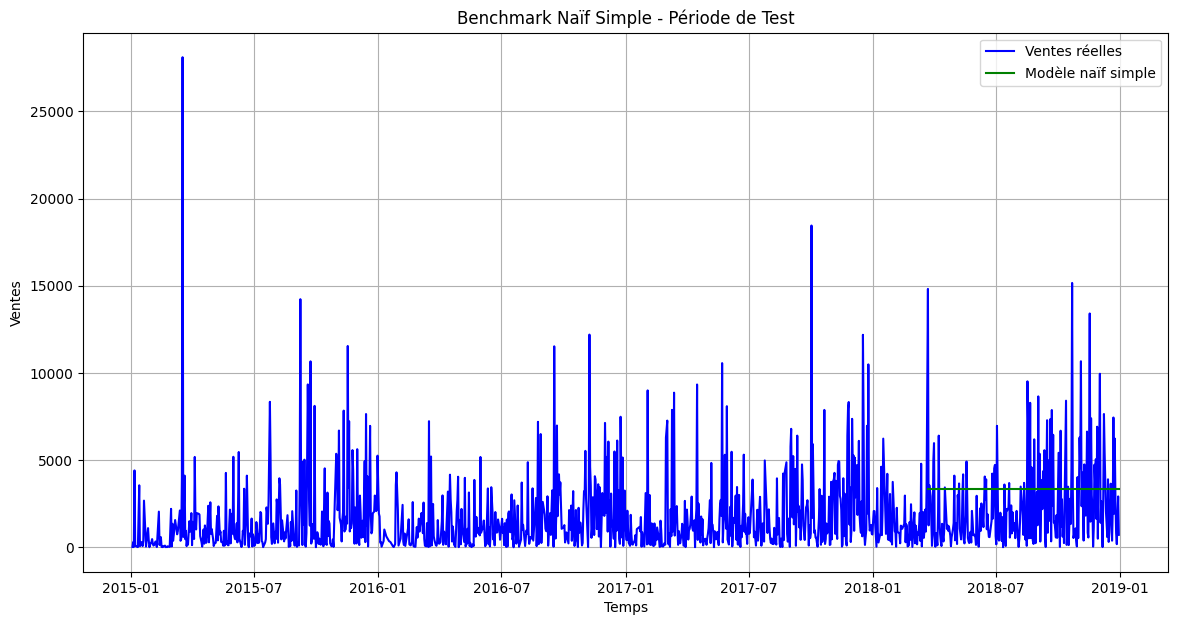

In [ ]:

y_pred_naive_simple = np.ones(len(y_test)) * y_train.iloc[-1]

# sauvgarde des métriques pour la comparaison
perf_mse = {}
perf_rmse = {}

# Calcul du MSE et RMSE pour le benchmark naïf
MSE_naive_simple = mean_squared_error(y_test, y_pred_naive_simple)
RMSE_naive_simple = np.sqrt(MSE_naive_simple)

print(f"MSE benchmark naïf simple = {MSE_naive_simple:.2f}")
print(f"RMSE benchmark naïf simple = {RMSE_naive_simple:.2f}")

perf_mse['benchmark naïf simple'] = MSE_naive_simple
perf_rmse['benchmark naïf simple'] = RMSE_naive_simple

# Visualisation des résultats
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_naive_simple, label='Modèle naïf simple', color='g')
plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Benchmark Naïf Simple - Période de Test')
plt.legend()
plt.grid(True)
plt.show()

## Benchmark naif moyenne

MSE benchmark naïf (moyenne 60 jours) = 7482275.31
RMSE benchmark naïf (moyenne 60 jours) = 2735.37


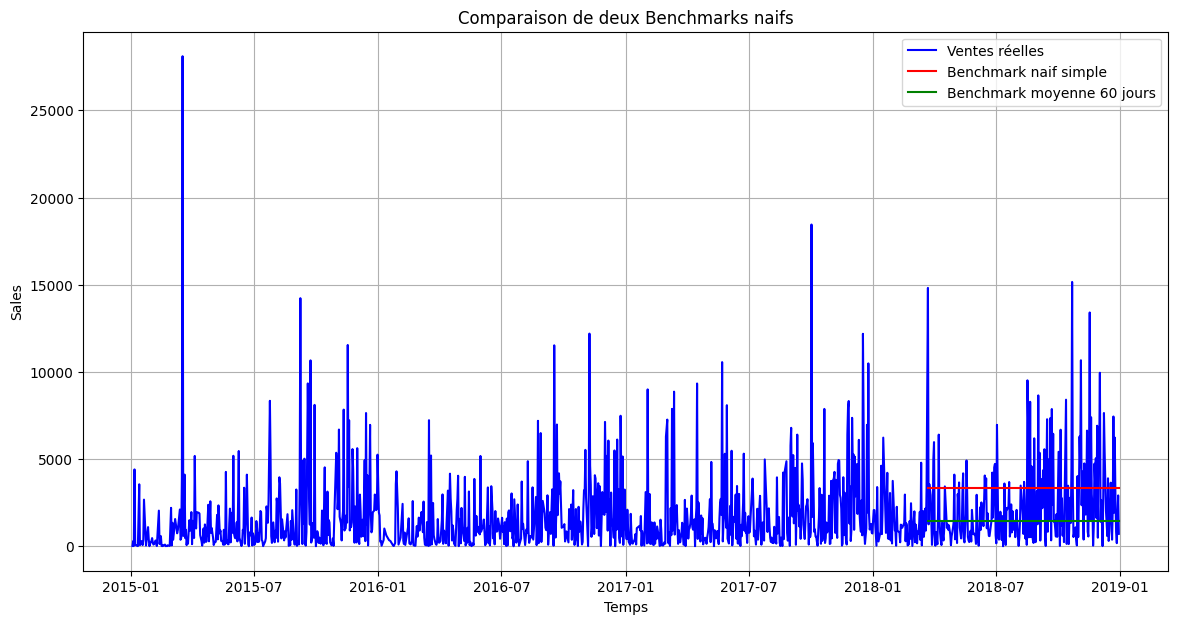

In [ ]:
# Benchmark naïf : moyenne des 60 derniers jours
forecast = np.mean(train['Sales'][-60:])
y_pred_mean = np.ones(len(y_test)) * forecast  # Prévision constante sur toute la période de test

# Calcul du MSE pour le benchmark naïf
MSE_naive_mean = mean_squared_error(y_test, y_pred_mean)
RMSE_naive_mean = root_mean_squared_error(y_test, y_pred_mean)

print("MSE benchmark naïf (moyenne 60 jours) = %.2f" % MSE_naive_mean)
print("RMSE benchmark naïf (moyenne 60 jours) = %.2f" % RMSE_naive_mean)

perf_mse['Naive mean'] = MSE_naive_mean
perf_rmse['Naive mean'] = RMSE_naive_mean


# Visualisation des résultats
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_naive_simple, c='r', label='Benchmark naif simple')
plt.plot(X_test.index, y_pred_mean, c='g', label='Benchmark moyenne 60 jours')
plt.xlabel('Temps')
plt.ylabel('Sales')
plt.title('Comparaison de deux Benchmarks naifs')
plt.legend()
plt.grid(True)
plt.show()

## Benchmark saisonnier naif

MSE benchmark seasonal naive = 10574909.04
RMSE benchmark seasonal naive = 3251.91


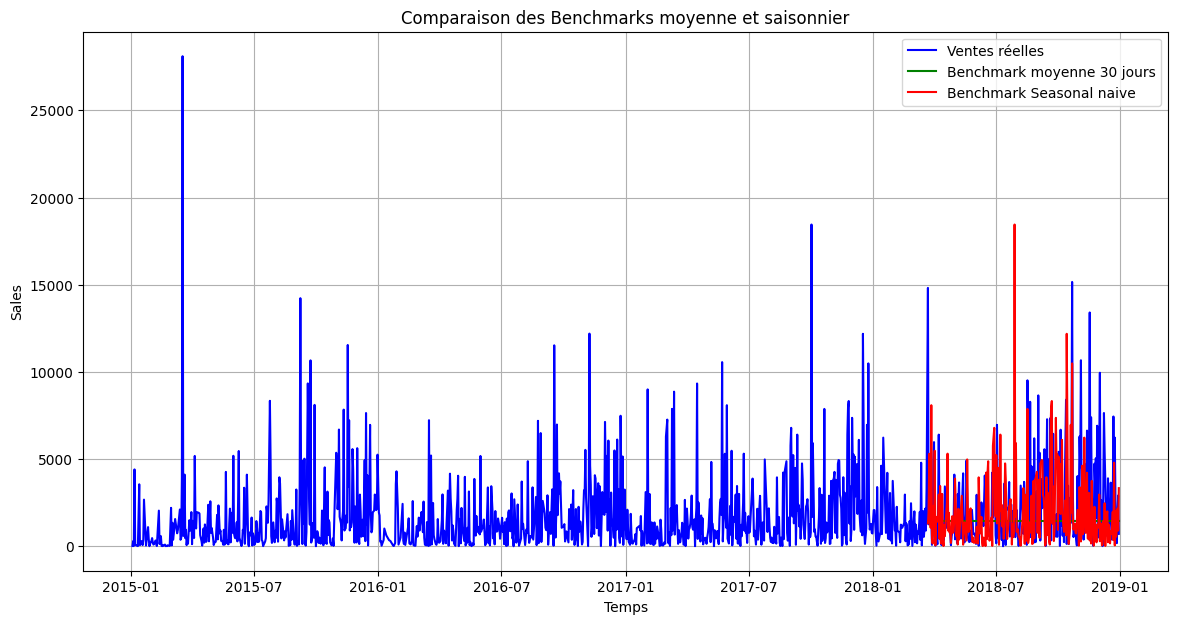

In [ ]:
# Benchmark saisonnier naïf
y_pred_seas = train['Sales'][-260:]

# Calcul du MSE pour le benchmark saisonnier naïf
MSE_seasonal = mean_squared_error(y_test, y_pred_seas)
RMSE_seasonal = root_mean_squared_error(y_test, y_pred_seas)

print("MSE benchmark seasonal naive = %.2f" % MSE_seasonal)
print("RMSE benchmark seasonal naive = %.2f" % RMSE_seasonal)

perf_mse['Seasonal naive'] = MSE_seasonal
perf_rmse['Seasonal naive'] = RMSE_seasonal


# Visualisation des résultats
plt.figure(figsize=(14, 7))

plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_mean, c='g', label='Benchmark moyenne 30 jours')
plt.plot(X_test.index, y_pred_seas, c='r', label='Benchmark Seasonal naive')
plt.xlabel('Temps')
plt.ylabel('Sales')
plt.title('Comparaison des Benchmarks moyenne et saisonnier')
plt.legend()
plt.grid(True)
plt.show()

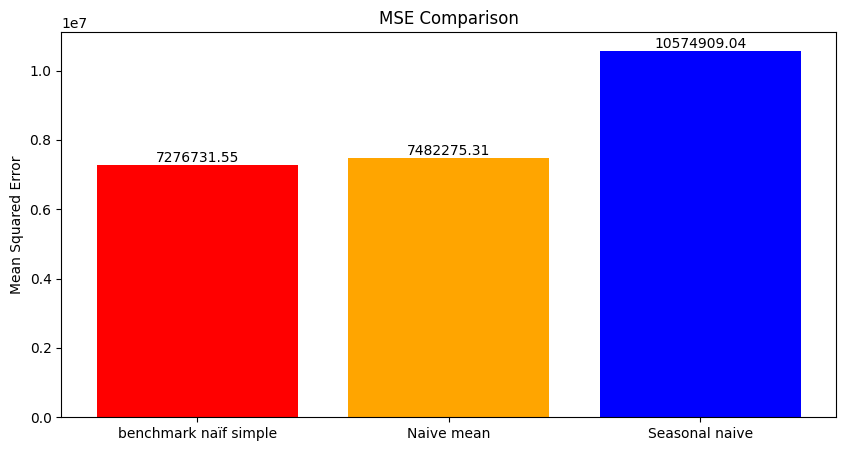

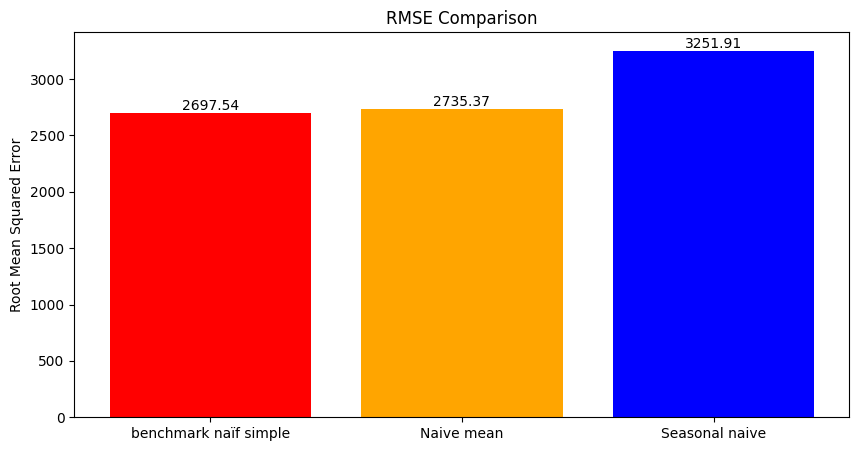

In [ ]:
# MSE Comparison
plt.figure(figsize=(10, 5))
bars = plt.bar(perf_mse.keys(), perf_mse.values(), color=['red', 'orange', 'blue'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

plt.show()

# RMSE Comparison
plt.figure(figsize=(10, 5))
bars = plt.bar(perf_rmse.keys(), perf_rmse.values(), color=['red', 'orange', 'blue'])
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

plt.show()

## Regression linéaire

Avant de construire le modèle de régression linéaire, nous suivons deux étapes essentielles pour garantir la performance et la stabilité : le scaling des données et la sélection des variables. Cette préparation permet de réduire la complexité, d'améliorer la robustesse et de prévenir les biais liés à l'échelle des variables.

1. **Scaling (Mise à l’Échelle des Données)**

La régression linéaire est sensible à l’échelle des variables, car les coefficients associés à chaque variable sont directement influencés par leur magnitude. Si les variables sont sur des échelles très différentes, cela peut :

Fausser l’interprétation des coefficients, car ils seront biaisés vers les variables ayant les valeurs les plus élevées.
Rendre l’optimisation plus difficile, ce qui ralentit la convergence du modèle.
Pour résoudre ce problème, nous utilisons le StandardScaler pour standardiser les variables :
Chaque variable est transformée pour avoir une moyenne de 0 et un écart-type de 1, garantissant que toutes les variables sont sur la même échelle.

2. **Sélection des Variables avec RFE (Recursive Feature Elimination)**

Après le scaling, nous effectuons la sélection des variables pour identifier les plus pertinentes et éliminer celles qui n’apportent que peu d’informations utiles.

Nous utilisons la méthode Recursive Feature Elimination (RFE), qui élimine les variables de manière itérative, en réentraînant un modèle de régression linéaire à chaque étape. Elle permet de sélectionner automatiquement les variables les plus importantes et minimise le risque de surajustement.

Dans notre cas, nous sélectionnons les 10 variables les plus significatives en fonction de leur importance dans le modèle. Ces variables sont ensuite utilisées pour entraîner le modèle de régression linéaire.


In [ ]:
# 1. Scaling

# Initialiser le scaler
scaler = StandardScaler()

# Appliquer le scaling sur X_train et X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir les données scalées en DataFrame pour conserver les noms des colonnes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:

# 2. RFE et la régression linéaire

# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Appliquer Recursive Feature Elimination
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)

# Récupérer les noms des variables sélectionnées
selected_features = X_train_scaled.columns[rfe.support_]
print("Variables sélectionnées par RFE :", selected_features)

X_train_rfe = X_train_scaled[selected_features]
X_test_rfe = X_test_scaled[selected_features]

# Ajouter une constante
X_train_rfe = sm.add_constant(X_train_rfe)
X_test_rfe = sm.add_constant(X_test_rfe)


# Entraîner le modèle OLS avec statsmodels
ols_model = sm.OLS(y_train, X_train_rfe).fit()

# Afficher le résumé du modèle
print(ols_model.summary())

# Prédictions sur le jeu de test
y_pred_ols = ols_model.predict(X_test_rfe)

# Calcul du MSE et du RMSE sur le jeu de test
MSE_ols = mean_squared_error(y_test, y_pred_ols)
RMSE_ols = np.sqrt(MSE_ols)

print(f"MSE sur le jeu de test : {MSE_ols:.2f}")
print(f"RMSE sur le jeu de test : {RMSE_ols:.2f}")

perf_mse["MSE_OLS"]=MSE_ols
perf_rmse["RMSE_OLS"]=RMSE_ols



Variables sélectionnées par RFE : Index(['Sales_moyenne_31_jours', 'Sales_max_31_jours',
       'Sales_ecart_type_31_jours', 'Sales_moyenne_45_jours',
       'Sales_max_45_jours', 'Sales_ecart_type_45_jours', 'Sales_max_60_jours',
       'Sales_ecart_type_60_jours', 'Month', 'Month_sin'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     7.705
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           7.13e-12
Time:                        23:06:55   Log-Likelihood:                -7768.0
No. Observations:                 861   AIC:                         1.556e+04
Df Residuals:                     850   BIC:                         1.561e+04
Df Model:                          10                   

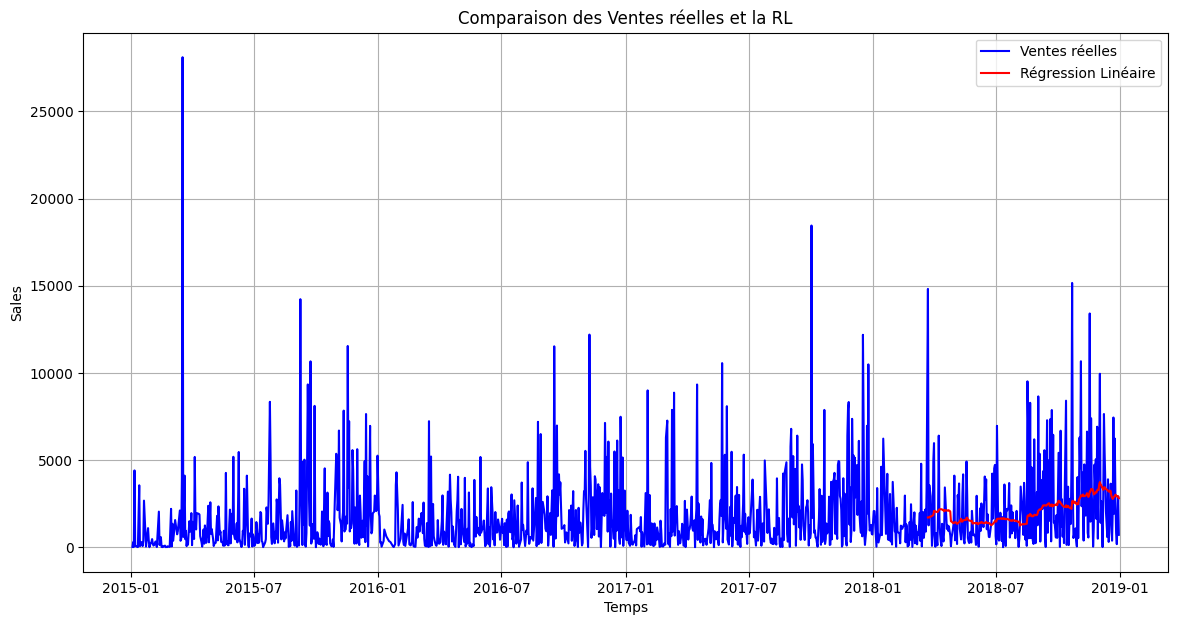

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 7))

plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_ols, c='r', label='Régression Linéaire')
plt.xlabel('Temps')
plt.ylabel('Sales')
plt.title('Comparaison des Ventes réelles et la RL')
plt.legend()
plt.grid(True)
plt.show()

## RandomForest

Avant de faire les prédictions, nous effectuons d’abord la sélection des variables afin de simplifier le modèle, réduire la complexité et améliorer la robustesse des résultats. Cette étape est cruciale pour éliminer les variables redondantes ou peu pertinentes qui pourraient introduire du bruit dans le modèle.

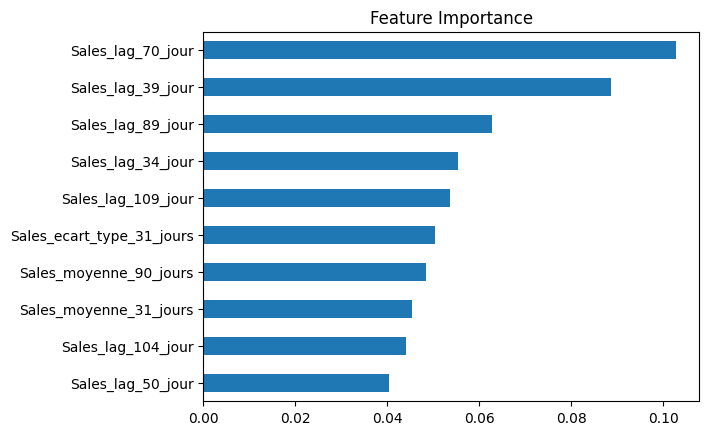

In [ ]:

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', title='Feature Importance');
selected_features = feat_importances.nlargest(10).index

In [ ]:
X_train_rf= X_train[selected_features]
X_test_rf = X_test[selected_features]

train_rf= train[selected_features]
test_rf=test[selected_features]

MSE = 7348469.41
RMSE = 2710.81


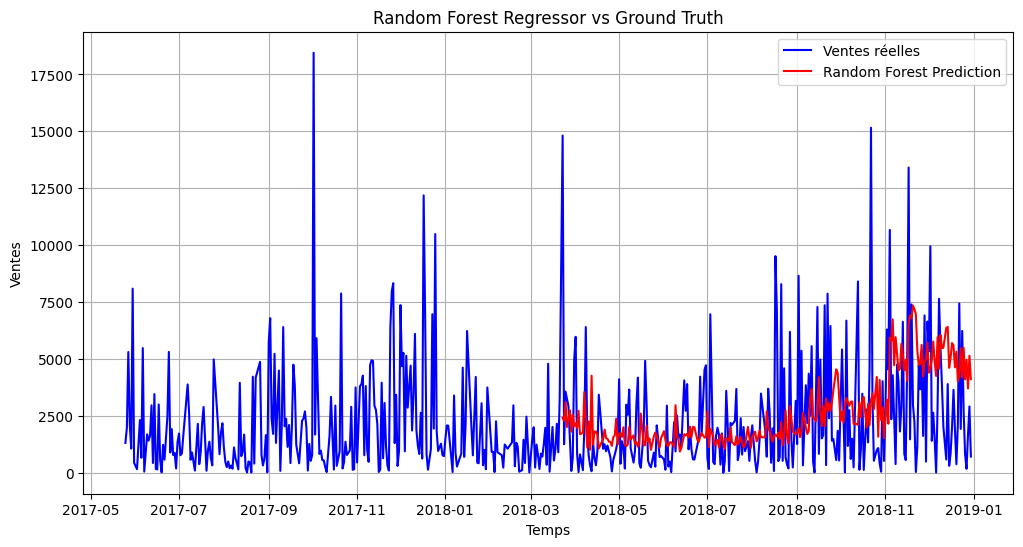

In [ ]:

# Entraînement du modèle Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train_rf, y_train)

# Prédiction sur les données de test
y_pred_rf = model.predict(X_test_rf)

# Évaluation des performances
MSE_rf = mean_squared_error(y_test, y_pred)
RMSE_rf = root_mean_squared_error(y_test, y_pred)
print("MSE = %.2f" % MSE_rf)
print("RMSE = %.2f" % RMSE_rf)

perf_mse['RF modèle'] = MSE_rf
perf_rmse['RF modèle'] = RMSE_rf

# Visualisation de la série temporelle réelle et prédite
plt.figure(figsize=(12, 6))
plt.plot(df.index[-520:], df['Sales'].iloc[-520:], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_rf, c='r', label='Random Forest Prediction')
plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Random Forest Regressor vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

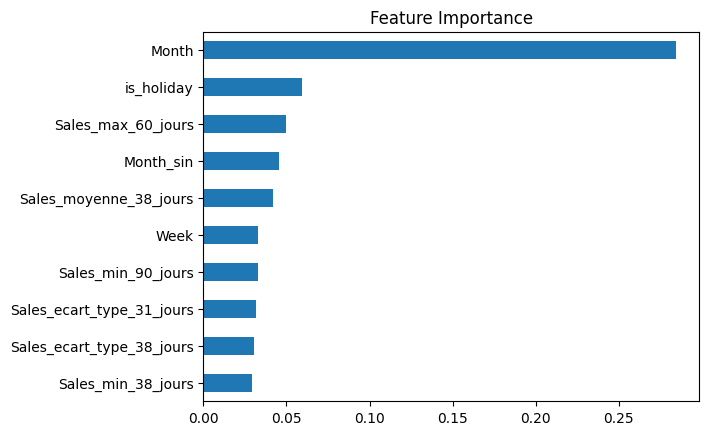

In [ ]:
# selection des variables
model = xgb.XGBRegressor(random_state=42,objective='reg:squarederror')
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', title='Feature Importance');
selected_features = feat_importances.nlargest(10).index

In [ ]:
X_train_xgb= X_train[selected_features]
X_test_xgb = X_test[selected_features]

train_xgb= train[selected_features]
test_xgb=test[selected_features]

MSE XGBoost = 9767840.64
RMSE XGBoost = 3125.35


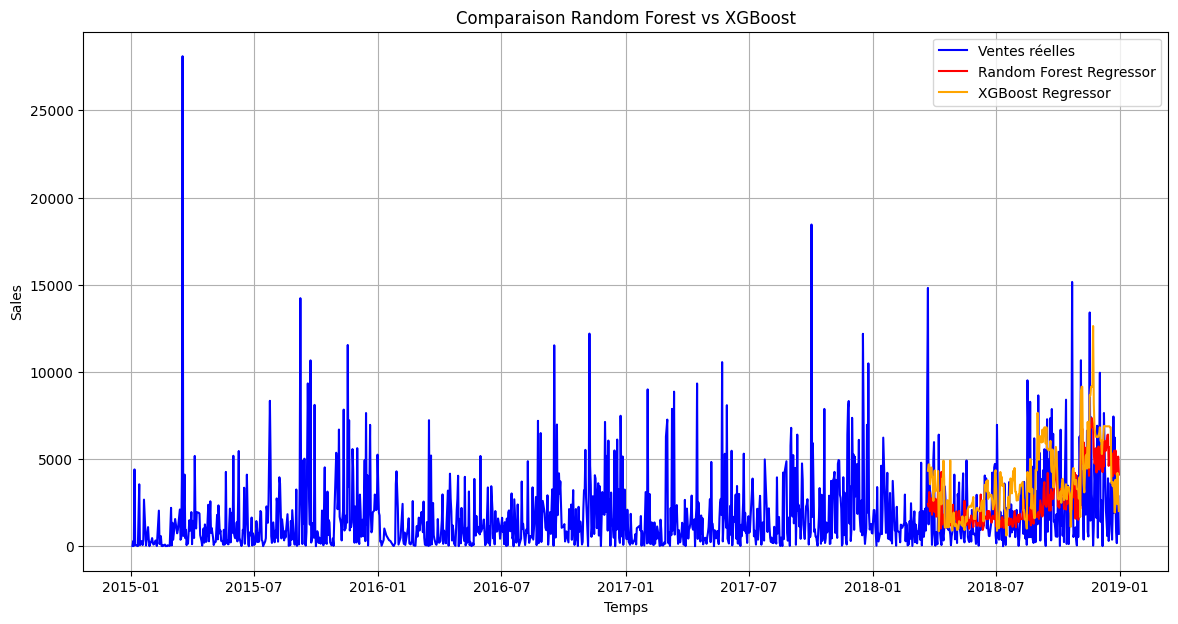

In [ ]:

# Entraînement du modèle XGBoost
xgboost_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
xgboost_model.fit(X_train_xgb, y_train)
y_pred_xgb = xgboost_model.predict(X_test_xgb)

# Calcul des MSE pour les deux modèles
MSE_xgb = mean_squared_error(y_test, y_pred_xgb)
RMSE_xgb = root_mean_squared_error(y_test, y_pred_xgb)

print("MSE XGBoost = %.2f" % MSE_xgb)
print("RMSE XGBoost = %.2f" % RMSE_xgb)


perf_mse['XGBoost'] = MSE_xgb
perf_rmse['XGBoost'] = RMSE_xgb


 #Visualisation des résultats
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_rf, label='Random Forest Regressor', color='r')
plt.plot(X_test.index, y_pred_xgb, label='XGBoost Regressor', color='orange')
plt.xlabel('Temps')
plt.ylabel('Sales')
plt.title('Comparaison Random Forest vs XGBoost')
plt.legend()
plt.grid(True)
plt.show()



## Gradient Boosting

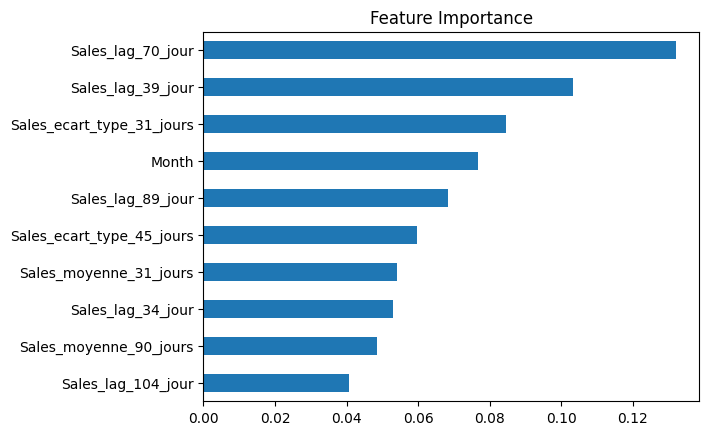

In [ ]:
# selection des variables
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', title='Feature Importance');
selected_features = feat_importances.nlargest(10).index

In [ ]:
X_train_gb= X_train[selected_features]
X_test_gb = X_test[selected_features]

train_gb= train[selected_features]
test_gb=test[selected_features]

MSE Gradient Boosting = 12597148.98
RMSE Gradient Boosting = 3549.25


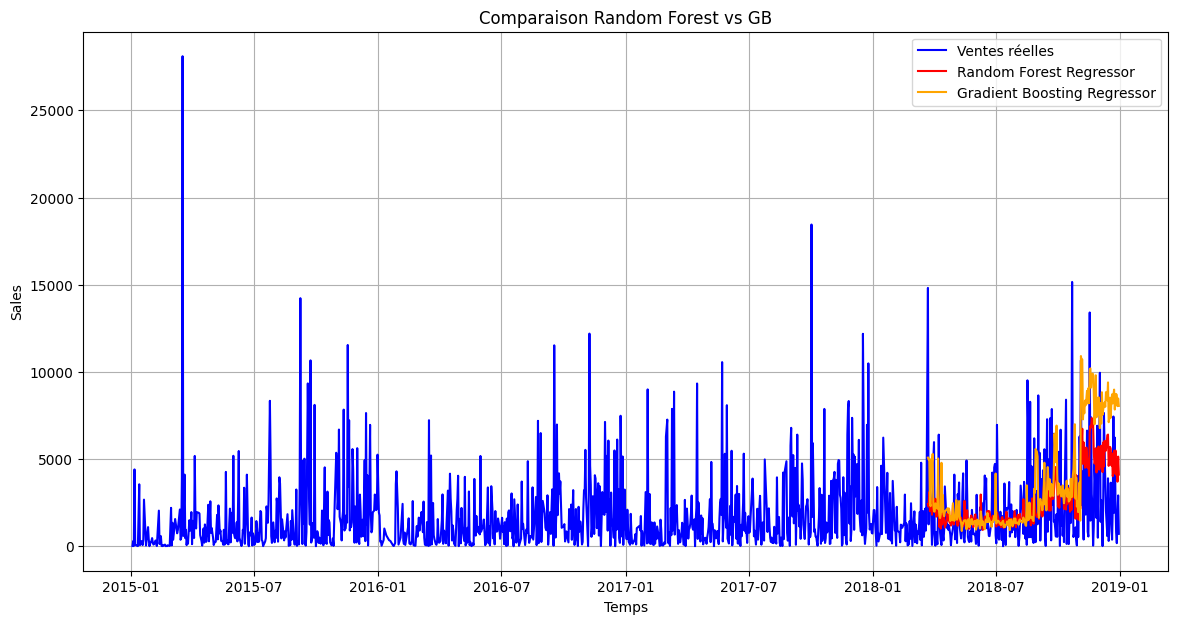

In [ ]:
# Entraînement du modèle Gradient Boosting avec les mêmes features
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_gb, y_train)

# Prédictions avec Gradient Boosting
y_pred_gb = gb_model.predict(X_test_gb)

# Calcul du MSE et du RMSE
MSE_gb = mean_squared_error(y_test, y_pred_gb)
RMSE_gb = root_mean_squared_error(y_test, y_pred_gb)

print("MSE Gradient Boosting = %.2f" % MSE_gb)
print("RMSE Gradient Boosting = %.2f" % RMSE_gb)

perf_mse['Gradient Boosting'] = MSE_gb
perf_rmse['Gradient Boosting'] = RMSE_gb

#Visualisation des résultats
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_rf, label='Random Forest Regressor', color='r')
plt.plot(X_test.index, y_pred_gb, label='Gradient Boosting Regressor', color='orange')
plt.xlabel('Temps')
plt.ylabel('Sales')
plt.title('Comparaison Random Forest vs GB')
plt.legend()
plt.grid(True)
plt.show()

## LGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4787
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 33
[LightGBM] [Info] Start training from score 1753.603132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


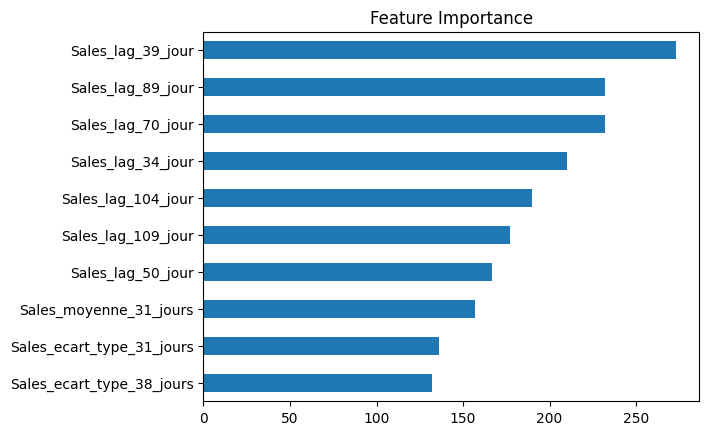

In [ ]:
# selection des variables
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', title='Feature Importance');
selected_features = feat_importances.nlargest(10).index

In [ ]:
X_train_lgb= X_train[selected_features]
X_test_lgb = X_test[selected_features]

train_lgb= train[selected_features]
test_lgb=test[selected_features]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 10
[LightGBM] [Info] Start training from score 1753.603132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MSE LGBM = 7068353.46
RMSE LGBM = 2658.64


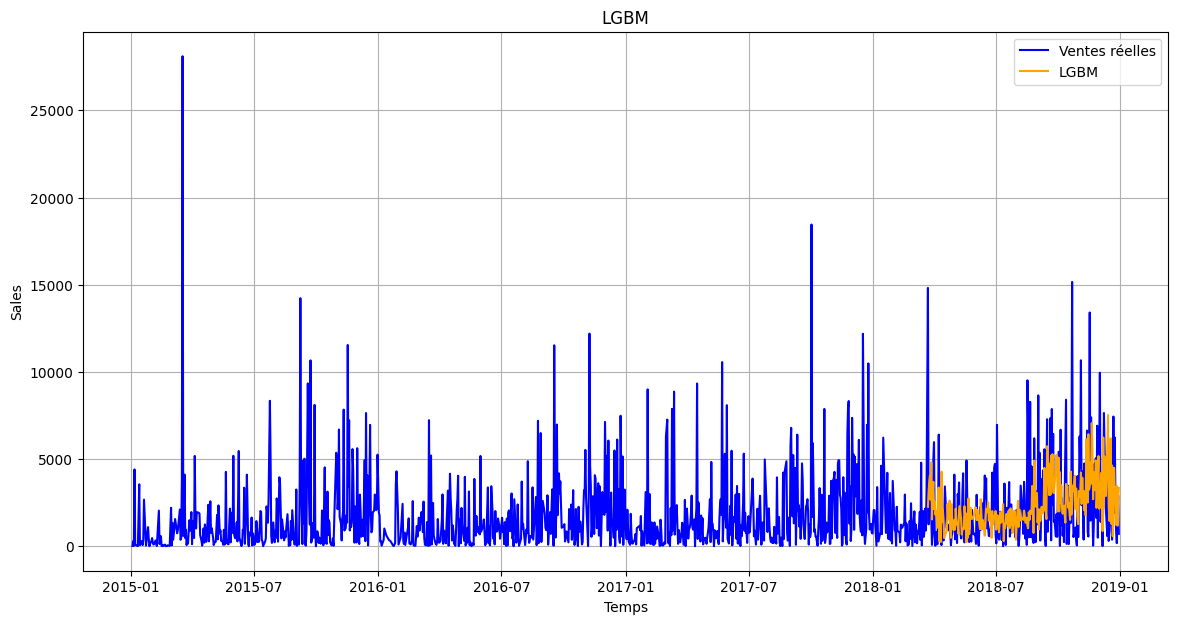

In [ ]:

lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train_lgb, y_train)


y_pred_lgb = lgb_model.predict(X_test_lgb)

# Calcul du MSE et du RMSE
MSE_lgb = mean_squared_error(y_test, y_pred_lgb)
RMSE_lgb = root_mean_squared_error(y_test, y_pred_lgb)

print("MSE LGBM = %.2f" % MSE_lgb)
print("RMSE LGBM = %.2f" % RMSE_lgb)

perf_mse['LGBM'] = MSE_lgb
perf_rmse['LGBM'] = RMSE_lgb

#Visualisation des résultats
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_lgb, label='LGBM', color='orange')
plt.xlabel('Temps')
plt.ylabel('Sales')
plt.title('LGBM')
plt.legend()
plt.grid(True)
plt.show()

## Comparaison des résultats

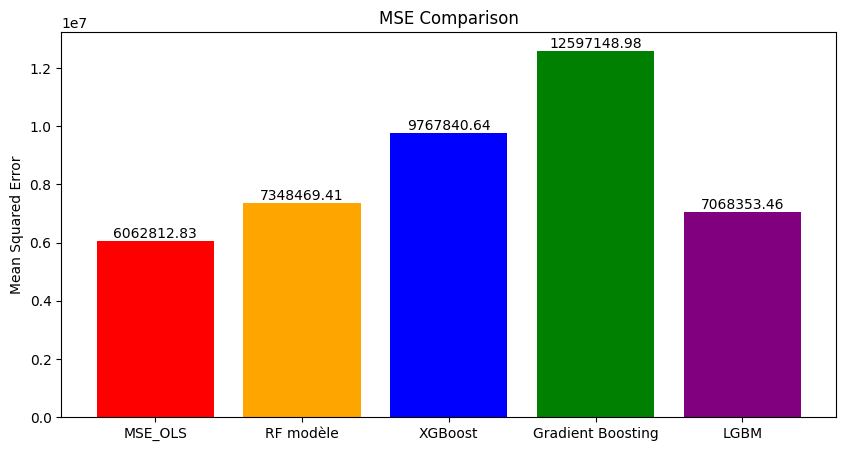

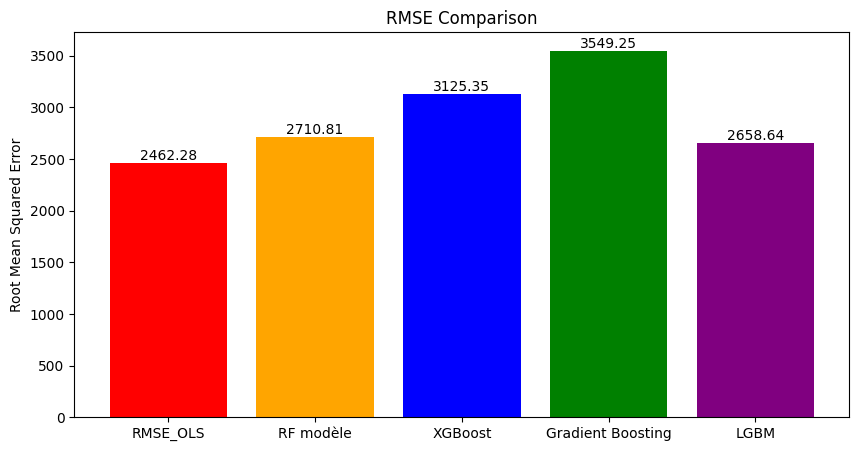

In [ ]:
# Visualisation des performances en barres pour MSE
last_5_entries_MSE = dict(list(perf_mse.items())[-5:])
plt.figure(figsize=(10, 5))
bars = plt.bar(last_5_entries_MSE.keys(), last_5_entries_MSE.values(), color=['red', 'orange', 'blue', 'green', 'purple'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

plt.show()

# Visualisation des performances en barres pour RMSE
last_5_entries_RMSE = dict(list(perf_rmse.items())[-5:])
plt.figure(figsize=(10, 5))
bars = plt.bar(last_5_entries_RMSE.keys(), last_5_entries_RMSE.values(), color=['red', 'orange', 'blue', 'green', 'purple'])
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')



plt.show()

## Stacking

Stacking est une approche ensembliste avancée qui combine plusieurs modèles de machine learning afin d’améliorer la précision des prévisions. Il exploite la complémentarité de plusieurs algorithmes pour obtenir un modèle final plus performant.

Le premier niveau est constitué de plusieurs modèles de machine learning qui sont entraînés indépendamment sur les mêmes données d’apprentissage. Chaque modèle va apprendre à prédire la variable cible en exploitant les patterns présents dans les données.

Les modèles utilisés dans cette approche peuvent être hétérogènes, c’est-à-dire basés sur des principes d’apprentissage différents. On utilise Random Forest, XGBoost, LGBM.

Une fois que chaque modèle de base a généré ses prédictions, celles-ci deviennent de nouvelles variables d’entrée. Un métamodèle est alors entraîné sur ces prédictions pour apprendre à combiner les sorties des modèles de base de manière optimale.

Le rôle du métamodèle est d’identifier quelles prédictions sont les plus fiables et comment les pondérer pour obtenir la meilleure estimation finale. On utilise la Régression linéaire.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4787
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 33
[LightGBM] [Info] Start training from score 1753.603132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4290
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 33
[LightGBM] [Info] Start training from score 1747.668593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

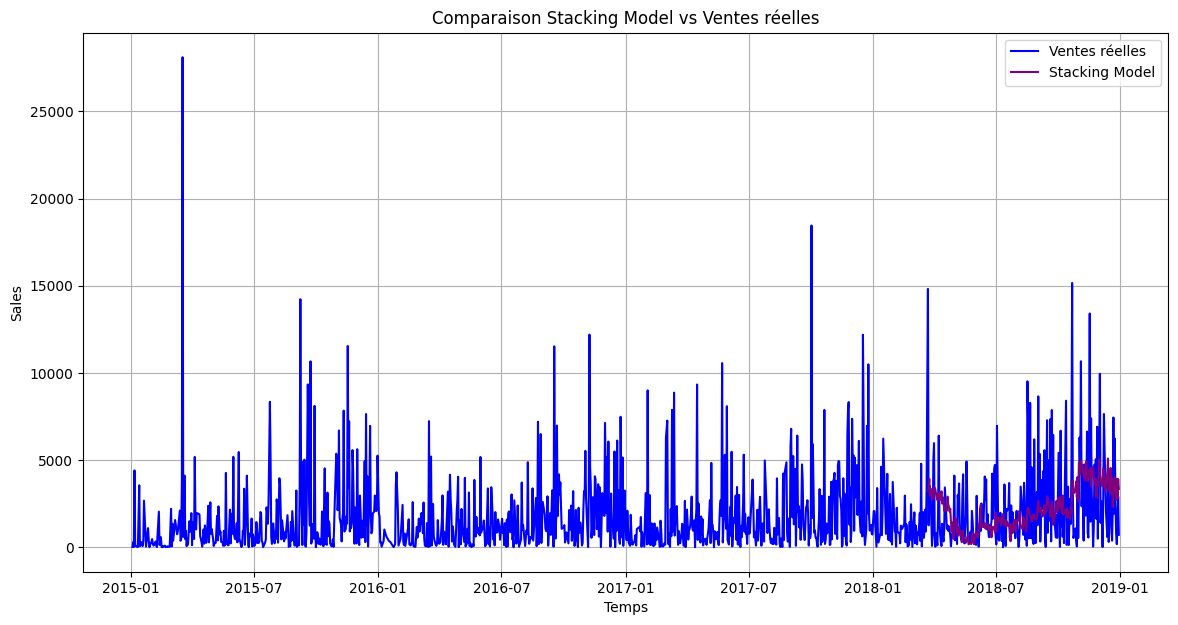

In [ ]:

# Sélection des modèles
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=100)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=100)),
    ('lgbm', lgb.LGBMRegressor(n_estimators=100, random_state=100)),
    ('ols', LinearRegression())
]

# Métamodèle : Régression linéaire
meta_model = LinearRegression()

# Construction du modèle de stacking
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, passthrough=True)


stacking_model.fit(X_train, y_train)

y_pred_stacking = stacking_model.predict(X_test)

# Calcul des métriques d’évaluation
MSE_stacking = mean_squared_error(y_test, y_pred_stacking)
RMSE_stacking = np.sqrt(MSE_stacking)

print("MSE Stacking = %.2f" % MSE_stacking)
print("RMSE Stacking = %.2f" % RMSE_stacking)

# Ajout aux performances globales
perf_mse['Stacking'] = MSE_stacking
perf_rmse['Stacking'] = RMSE_stacking

# Visualisation des résultats
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(X_test.index, y_pred_stacking, label='Stacking Model', color='purple')
plt.xlabel('Temps')
plt.ylabel('Sales')
plt.title('Comparaison Stacking Model vs Ventes réelles')
plt.legend()
plt.grid(True)
plt.show()

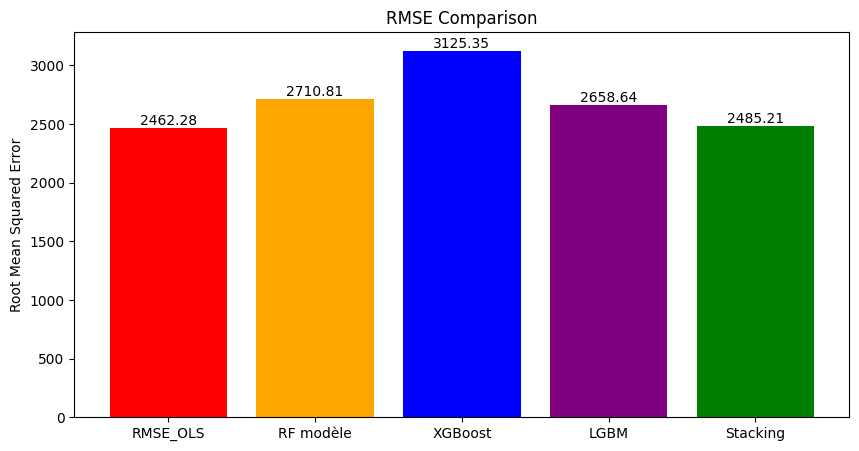

In [ ]:
filtered_perf_rmse = {key: value for key, value in perf_rmse.items() if key != "Gradient Boosting"}
# Visualisation des performances en barres pour RMSE
last_5_entries_RMSE = dict(list(filtered_perf_rmse.items())[-5:])
plt.figure(figsize=(10, 5))
bars = plt.bar(last_5_entries_RMSE.keys(), last_5_entries_RMSE.values(), color=['red', 'orange', 'blue', 'purple', 'green'])
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')



plt.show()

### Evaluation des modèles par fenêtre croissante

Après avoir évalué les modèles sur un jeu de test initial fixe, nous allons utiliser une approche plus robuste pour valider nos modèles : la méthode par fenêtre croissante (Expanding Window).

Cette technique consiste à augmenter progressivement la taille des données d'entraînement, tout en testant les performances du modèle sur des fenêtres de test de taille fixe.

À chaque itération nous ajoutons une nouvelle période de données d’entraînement. Puis, nous testons le modèle sur une période future fixe (30 jours). Ce processus est répété 7 fois, nous permettant ainsi de mieux évaluer la stabilité et la généralisation des modèles sur plusieurs périodes.

In [ ]:
# Code basique pour faire expanding window

# modèles
rf_model = RandomForestRegressor(random_state=200)
xgb_model = xgb.XGBRegressor(random_state=200)
lgb_model = lgb.LGBMRegressor(random_state=200)
gb_model = GradientBoostingRegressor(random_state=200)


rmse_scores_rf = []
rmse_scores_gb = []
rmse_scores_lgb = []
rmse_scores_xgb = []
rmse_scores_stacking = []

# les fenetres (on a 7)
X_test_6 = X_train.iloc[-30:]
y_test_6 = y_train.iloc[-30:]

X_train_6=X_train.iloc[:-30]
y_train_6=y_train.iloc[:-30]

X_test_5 = X_test_6.iloc[-30:]
y_test_5 = y_test_6.iloc[-30:]

X_train_5=X_train_6.iloc[:-30]
y_train_5=y_train_6.iloc[:-30]

X_test_4=X_test_5.iloc[-30:]
y_test_4=y_test_5.iloc[-30:]

X_train_4=X_train_5.iloc[:-30]
y_train_4=y_train_5.iloc[:-30]

X_test_3 = X_test_4.iloc[-30:]
y_test_3 = y_test_4.iloc[-30:]

X_train_3 = X_train_4.iloc[:-90]
y_train_3 = y_train_4.iloc[:-90]

X_test_2 = X_test_3.iloc[-30:]
y_test_2 = y_test_3.iloc[-30:]

X_train_2 = X_train_3.iloc[:-30]
y_train_2 = y_train_3.iloc[:-30]

X_test_1 = X_test_2.iloc[-30:]
y_test_1 = y_test_2.iloc[-30:]

X_train_1 = X_train_2.iloc[:-30]
y_train_1 = y_train_2.iloc[:-30]

X_test_0 = X_test_1.iloc[-30:]
y_test_0 = y_test_1.iloc[-30:]

X_train_0 = X_train_1.iloc[:-30]
y_train_0 = y_train_1.iloc[:-30]


X_tests = [X_test_0, X_test_1, X_test_2, X_test_3, X_test_4, X_test_5, X_test_6]
y_tests = [y_test_0, y_test_1, y_test_2, y_test_3, y_test_4, y_test_5, y_test_6]
X_trains = [X_train_0, X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_train_6]
y_trains = [y_train_0, y_train_1, y_train_2, y_train_3, y_train_4, y_train_5, y_train_6]


for i in range(0,7):
    print(f"Window {i+1}:")

    #Random Forest
    rf_model.fit(X_trains[i], y_trains[i])

    # Predict for the current test set
    y_pred_rf = rf_model.predict(X_tests[i])

    # Calculate RMSE for this window
    rmse_rf = np.sqrt(mean_squared_error(y_tests[i], y_pred_rf))
    rmse_scores_rf.append(rmse_rf)

    #GBoosting
    gb_model.fit(X_trains[i], y_trains[i])
    y_pred_gb = gb_model.predict(X_tests[i])
    rmse_gb = np.sqrt(mean_squared_error(y_tests[i], y_pred_gb))
    rmse_scores_gb.append(rmse_gb)

    #XGboost
    xgb_model.fit(X_trains[i], y_trains[i])
    y_pred_xgb = xgb_model.predict(X_tests[i])
    rmse_xgb = np.sqrt(mean_squared_error(y_tests[i], y_pred_xgb))
    rmse_scores_xgb.append(rmse_xgb)

    #LGBM
    lgb_model.fit(X_trains[i], y_trains[i])
    y_pred_lgb = lgb_model.predict(X_tests[i])
    rmse_lgb = np.sqrt(mean_squared_error(y_tests[i], y_pred_lgb))
    rmse_scores_lgb.append(rmse_lgb)

    #Stacking
    stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, passthrough=True)
    stacking_model.fit(X_trains[i], y_trains[i])
    y_pred_stacking = stacking_model.predict(X_tests[i])
    rmse_stacking = np.sqrt(mean_squared_error(y_tests[i], y_pred_stacking))
    rmse_scores_stacking.append(rmse_stacking)



    print(f"RMSE Random Forest Regressor: {rmse_scores_rf}")
    print(f"RMSE Gradient Boosting Regressor: {rmse_scores_gb}")
    print(f"RMSE LGBM: {rmse_scores_lgb}")
    print(f"RMSE XGBoost: {rmse_scores_xgb}")
    print(f"RMSE Stacking = {rmse_scores_xgb}")


# Calculate overall RMSE
overall_rmse_rf = np.mean(rmse_scores_rf)
overall_rmse_gb = np.mean(rmse_scores_gb)
overall_rmse_lgb = np.mean(rmse_scores_lgb)
overall_rmse_xgb = np.mean(rmse_scores_xgb)
overall_rmse_stacking = np.mean(rmse_scores_stacking)


print(f"Overall RMSE RF:{overall_rmse_rf}")
print(f"Overall RMSE GB:{overall_rmse_gb}")
print(f"Overall RMSE LGBM:{overall_rmse_lgb}")
print(f"Overall RMSE XGB:{overall_rmse_xgb}")
print(f"Overall RMSE Stacking:{overall_rmse_stacking}")



Window 1:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3705
[LightGBM] [Info] Number of data points in the train set: 591, number of used features: 32
[LightGBM] [Info] Start training from score 1635.772041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
overall_rmse={
    "RF": overall_rmse_rf,
    "XGB": overall_rmse_xgb,
    "GB": overall_rmse_gb,
    "LGBM": overall_rmse_lgb,
    "Stacking": overall_rmse_stacking

}


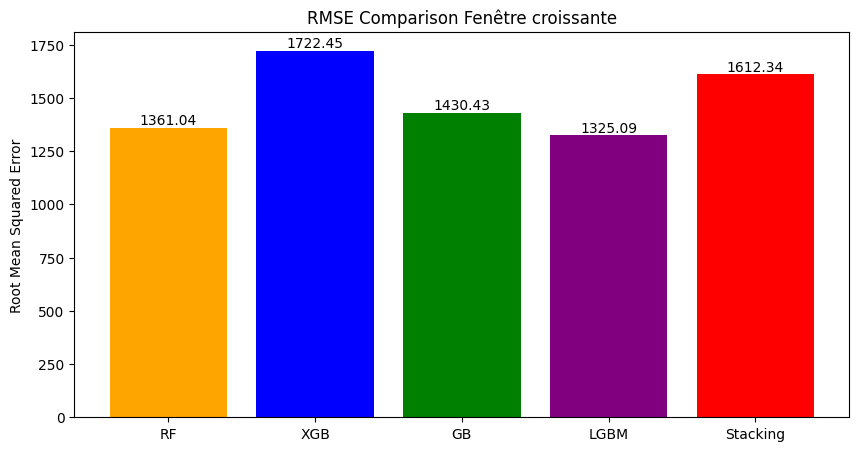

In [ ]:
plt.figure(figsize=(10, 5))
bars = plt.bar(overall_rmse.keys(), overall_rmse.values(), color=['orange', 'blue', 'green', 'purple', 'red'])
plt.title('RMSE Comparison Fenêtre croissante')
plt.ylabel('Root Mean Squared Error')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')



plt.show()

L’évaluation des modèles avec la méthode par fenêtre croissante a permis d’observer une amélioration générale des performances.

L’une des principales raisons de cette amélioration est que les modèles de machine learning bénéficient d’un volume croissant de données d’entraînement. En intégrant progressivement de nouvelles observations, ils s’adaptent mieux aux tendances et sont capables de mieux généraliser sur des horizons plus longs. Cela se traduit par une réduction du RMSE pour la majorité des modèles qui semblent bien tirer profit de cet apprentissage progressif.

Cependant, Gradient Boosting ne reste plus le modèle le moins performant dans les deux approches. Maintenant c'est XGBoost. Malgré une amélioration de son RMSE avec la méthode par fenêtre croissante, il affiche des erreurs plus élevées que les autres modèles. Cela pourrait s’expliquer par une trop grande sensibilité aux variations des données et un possible sur-apprentissage sur certaines périodes.


En conclusion, l’approche par fenêtre croissante semble favoriser les modèles qui s’adaptent bien à l’évolution progressive des données. Ces observations soulignent l’importance de bien choisir la méthode d’évaluation afin d’obtenir une mesure réaliste et robuste des performances des modèles de prévision.

## Approche hybride ARMA + LGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4787
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 33
[LightGBM] [Info] Start training from score 1753.603132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z

RMSE ARMA-LGBM = 2703.92


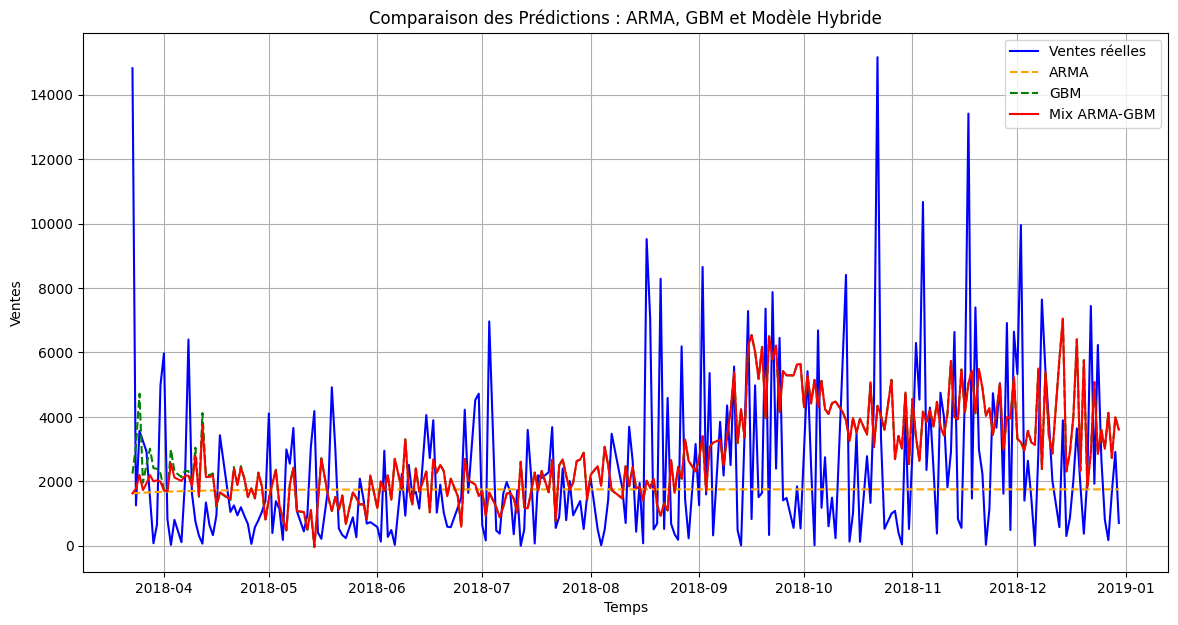

In [ ]:
lgb_model = lgb.LGBMRegressor(random_state=200)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

#ARMA
arma_model = ARIMA(y_train, order=(2, 0, 2))  # ARMA(p=2, q=2)
arma_result = arma_model.fit()

y_pred_arma = arma_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)


def alpha(t, lambd=10):
    return np.exp(-t / lambd)

# Combinaison pondérée des prédictions
t = np.arange(len(y_test))
y_pred_hybrid = alpha(t) * y_pred_arma + (1 - alpha(t)) * y_pred_lgb

RMSE_ARMA_LGBM = root_mean_squared_error(y_test, y_pred_hybrid)
perf_rmse["ARMA_LGBM"] = RMSE_ARMA_LGBM


print("RMSE ARMA-LGBM = %.2f" % RMSE_ARMA_LGBM)

# Visualisation
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Ventes réelles', color='b')
plt.plot(y_test.index, y_pred_arma, '--', label='ARMA', color='orange')
plt.plot(y_test.index, y_pred_lgb, '--', label='GBM', color='green')
plt.plot(y_test.index, y_pred_hybrid, label='Mix ARMA-GBM', color='red')
plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Comparaison des Prédictions : ARMA, GBM et Modèle Hybride')
plt.legend()
plt.grid(True)
plt.show()



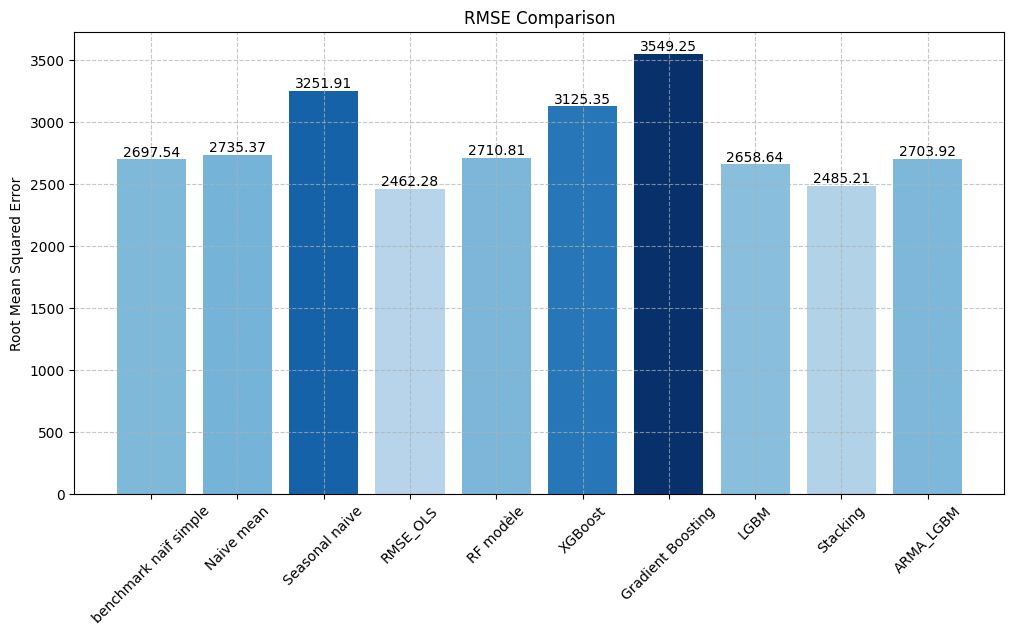

In [ ]:
# RMSE Comparison

rmse_values = np.array(list(perf_rmse.values()))
normalized_rmse = (rmse_values - rmse_values.min()) / (rmse_values.max() - rmse_values.min())
colors = plt.cm.Blues(0.3 + 0.7 * normalized_rmse)


plt.figure(figsize=(12, 6))
bars = plt.bar(perf_rmse.keys(), perf_rmse.values(), color=colors)
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


**Analyse des résultats**

Les performances des différents modèles montrent des écarts significatifs en termes d'erreur quadratique moyenne (RMSE) :

- Le modèle naïf basé sur la moyenne présente un RMSE de 2735.37, ce qui confirme qu'un modèle simple peut être une référence difficile à battre.

- Le modèle Seasonal Naïve affiche un RMSE plus élevé (3251.91), suggérant que la prise en compte de la saisonnalité seule n'est pas suffisante pour capturer efficacement les tendances de vente.

- Les modèles de machine learning comme XGBoost (3125.35) et Gradient Boosting (3596.32) montrent des performances inférieures par rapport aux modèles plus simples, ce qui peut indiquer un surajustement ou une difficulté à capturer certaines dynamiques sous-jacentes des ventes.

- Le modèle de régression linéaire OLS (2462.28) et le modèle Stacking (2472.40) obtiennent de meilleurs scores, prouvant que des approches plus interprétables peuvent parfois mieux fonctionner dans ce contexte.

- Le modèle hybride ARMA-LGBM (2703.92) améliore légèrement les performances, mais ne surpasse pas les modèles linéaires, ce qui montre que la combinaison de l'ARMA avec le LGBM n'apporte pas d'amélioration significative.


Les modèles de machine learning n’ont pas systématiquement dépassé les modèles statistiques et naïfs, ce qui peut indiquer un manque d'informations pertinentes dans les variables explicatives ou une sous-estimation des dynamiques temporelles.

L'incapacité à utiliser des lags courts (moins de 30 jours) peut avoir un impact majeur sur la performance, car cela empêche la capture des variations rapides et saisonnières.

L'effet du bruit des lags éloignés (> 30 jours) pourrait biaiser l'entraînement des modèles de machine learning, réduisant leur capacité d'adaptation aux variations rapides.

Le bon score des modèles simples indique une forte régularité des ventes sur une période donnée, difficile à modéliser pour des approches plus sophistiquées.

En conclusion, bien que les modèles avancés aient été testés, les approches plus simples (OLS, Stacking) restent compétitives, mettant en lumière l’importance de bien choisir les features temporelles et de tester différentes granularités d’analyse.


## Approche hybride (directe + recursive)

La méthode hybride de prévision des séries temporelles combine des éléments des stratégies directe et récursive pour fournir une approche plus robuste et cohérente de la prédiction à long terme. Contrairement à la stratégie directe, qui utilise une modèle distinct pour chaque horizon, ou à la stratégie récursive, qui enchaîne les prédictions en boucle, la stratégie hybride utilise les prédictions des modèles précédents comme nouvelles entrées pour les horizons suivants.

Principe de fonctionnement

Plutôt que d'utiliser un seul modèle pour prédire tous les horizons, cette stratégie entraîne un modèle distinct pour chaque horizon de prédiction (T+1, T+2, ..., T+30). Un modèle de ML est appliqué à chaque horizon afin d'adapter la prédiction à des variations spécifiques des données à chaque intervalle de temps.
Cela permet de capturer les tendances spécifiques à différents horizons sans forcer un modèle unique à s'adapter à l'ensemble du spectre temporel.

Calcul du RMSE global :

Les prédictions finales sont comparées aux valeurs réelles sur l'ensemble de test. Le RMSE est calculé sur l'ensemble des prédictions pour évaluer la performance.

**Avantages de la méthode hybride**

- Réduction de l'accumulation d'erreurs : Contrairement à la méthode récursive, les erreurs ne se propagent pas aussi fortement.

- Cohérence des prédictions : À la différence de la stratégie directe, la stratégie hybride assure une transition fluide entre les horizons.

La méthode hybride est un compromis idéal entre la stratégie directe et récursive, offrant une meilleure précision et une plus grande stabilité des prédictions. Elle est particulièrement utile pour des horizons moyens à longs et pour les problèmes où la cohérence temporelle est cruciale.

In [ ]:
df_ventes_jours=ventes_par_jour.copy()

In [ ]:
# feature engineering comme avant

df_ventes_jours['is_weekend'] = df_ventes_jours['Order Date'].dt.dayofweek.isin([5, 6]).astype(int)
df_ventes_jours['is_holiday'] = df_ventes_jours['Order Date'].apply(lambda x: 1 if x in us_holidays else 0)

df_ventes_jours.set_index('Order Date', inplace=True)
df_ventes_jours['Month'] = df_ventes_jours.index.month
df_ventes_jours['Year'] = df_ventes_jours.index.year
df_ventes_jours['Week']=df_ventes_jours.index.isocalendar().week

df_ventes_jours['Month_sin'] = np.sin(2 * np.pi * df_ventes_jours['Month'] / 12)

#lags
df_ventes_jours['Lag_34'] = df_ventes_jours.Sales.shift(34)
df_ventes_jours['Lag_39'] = df_ventes_jours.Sales.shift(39)
df_ventes_jours['Lag_50'] = df_ventes_jours.Sales.shift(50)
df_ventes_jours['Lag_70'] = df_ventes_jours.Sales.shift(70)
df_ventes_jours['Lag_89'] = df_ventes_jours.Sales.shift(89)
df_ventes_jours['Lag_104'] = df_ventes_jours.Sales.shift(104)
df_ventes_jours['Lag_109'] = df_ventes_jours.Sales.shift(109)

#fenetres
tailles_fenetre = [31, 38, 45, 60, 90]
df_fenetre = appliquer_fenetre_roulante(df_daily, colonne='Sales', tailles_fenetre=tailles_fenetre)

In [ ]:
# automatisation de la création des lags
for lag in np.arange(30,0,-1):
  df_ventes_jours['Lag_'+str(lag)] = df_ventes_jours.Sales.shift(lag)

df_ventes_jours.head()

Sales  is_weekend  is_holiday  Month  Year  Week  Month_sin  \
Order Date                                                                   
2015-01-03    16.448           1           0      1  2015     1        0.5   
2015-01-04   288.060           1           0      1  2015     1        0.5   
2015-01-05    19.536           0           0      1  2015     2        0.5   
2015-01-06  4407.100           0           0      1  2015     2        0.5   
2015-01-07    87.158           0           0      1  2015     2        0.5   

            Lag_34  Lag_39  Lag_50  ...  Lag_10  Lag_9  Lag_8  Lag_7  Lag_6  \
Order Date                          ...                                       
2015-01-03     NaN     NaN     NaN  ...     NaN    NaN    NaN    NaN    NaN   
2015-01-04     NaN     NaN     NaN  ...     NaN    NaN    NaN    NaN    NaN   
2015-01-05     NaN     NaN     NaN  ...     NaN    NaN    NaN    NaN    NaN   
2015-01-06     NaN     NaN     NaN  ...     NaN    NaN    NaN    NaN    NaN   
2015-01-07     NaN     NaN     NaN  ...     NaN    NaN    NaN    NaN    NaN   

            Lag_5   Lag_4    Lag_3    Lag_2     Lag_1  
Order Date                                             
2015-01-03    NaN     NaN      NaN      NaN       NaN  
2015-01-04    NaN     NaN      NaN      NaN    16.448  
2015-01-05    NaN     NaN      NaN   16.448   288.060  
2015-01-06    NaN     NaN   16.448  288.060    19.536  
2015-01-07    NaN  16.448  288.060   19.536  4407.100  

[5 rows x 44 columns]

In [ ]:
df_ventes_jours=df_ventes_jours.dropna()

In [ ]:
# Train/Test separation

num_rows = len(df_ventes_jours)

train_size = 0.7

# Indice de séparation
idx_train = int(num_rows * train_size)

# Découpage des données
df_train_final = df_ventes_jours.iloc[:idx_train]
df_test_final = df_ventes_jours.iloc[idx_train:]

features = [col for col in df_ventes_jours.columns if col not in ['Sales']]  # Toutes les colonnes sauf "Sales"
X_train_final = df_train_final[features]
y_train_final = df_train_final["Sales"]

X_test_final = df_test_final[features]
y_test_final = df_test_final["Sales"]

In [ ]:
# fonction pour approche hybride

def hybrid_forecasting(X_train, y_train, X_test, y_test, utilized_model, max_horizon=30):
    models = {}
    predictions = []

    X_test_h = X_test.copy()

    for h in range(1, max_horizon + 1):

        print(f"Entrainement du modèle {h}")
        X_train_h = X_train.copy()
        y_train_h = y_train.shift(-h).dropna()
        X_train_h = X_train_h.iloc[:len(y_train_h)]

        if len(X_test_h) < h:
            break

        model = utilized_model
        model.fit(X_train_h, y_train_h)
        models[h] = clone(model)

        y_pred = model.predict(X_test_h)
        predictions.append(y_pred)

        if h < max_horizon:
            X_test_h[f'Lag_1'] = y_pred  # Mise à jour de lag_1 avec les prédictions
            for lag in range(max_horizon - 1, 0, -1):
                X_test_h[f'Lag_{lag+1}'] = X_test_h[f'Lag_{lag}']  # Décalage des lags

    predictions = np.array(predictions).T
    y_test_eval_trimmed = y_test.iloc[:predictions.shape[0]].values
    min_samples = min(len(y_test_eval_trimmed), len(predictions))
    y_test_eval_trimmed = y_test_eval_trimmed[:min_samples]
    predictions_trimmed = predictions[:min_samples]

    rmse = sqrt(mean_squared_error(y_test_eval_trimmed, predictions_trimmed.mean(axis=1)))
    print(f"RMSE global pour 30% des données de test : {rmse:.2f}")

    return models, predictions, rmse, predictions_trimmed.mean(axis=1)



## OLS approche hybride

In [ ]:
models_hybrid_ols, predictions_hybrid_ols, rmse_hybrid_ols, predictions_final_ols = hybrid_forecasting(
    X_train_final, y_train_final, X_test_final, y_test_final, LinearRegression(), max_horizon=30
)

Entrainement du modèle 1
Entrainement du modèle 2
Entrainement du modèle 3
Entrainement du modèle 4
Entrainement du modèle 5
Entrainement du modèle 6
Entrainement du modèle 7
Entrainement du modèle 8
Entrainement du modèle 9
Entrainement du modèle 10
Entrainement du modèle 11
Entrainement du modèle 12
Entrainement du modèle 13
Entrainement du modèle 14
Entrainement du modèle 15
Entrainement du modèle 16
Entrainement du modèle 17
Entrainement du modèle 18
Entrainement du modèle 19
Entrainement du modèle 20
Entrainement du modèle 21
Entrainement du modèle 22
Entrainement du modèle 23
Entrainement du modèle 24
Entrainement du modèle 25
Entrainement du modèle 26
Entrainement du modèle 27
Entrainement du modèle 28
Entrainement du modèle 29
Entrainement du modèle 30
RMSE global pour 30% des données de test : 2420.91


In [ ]:
predictions_final_ols=pd.DataFrame(predictions_final_ols)
predictions_final_ols.index = df_test_final.index

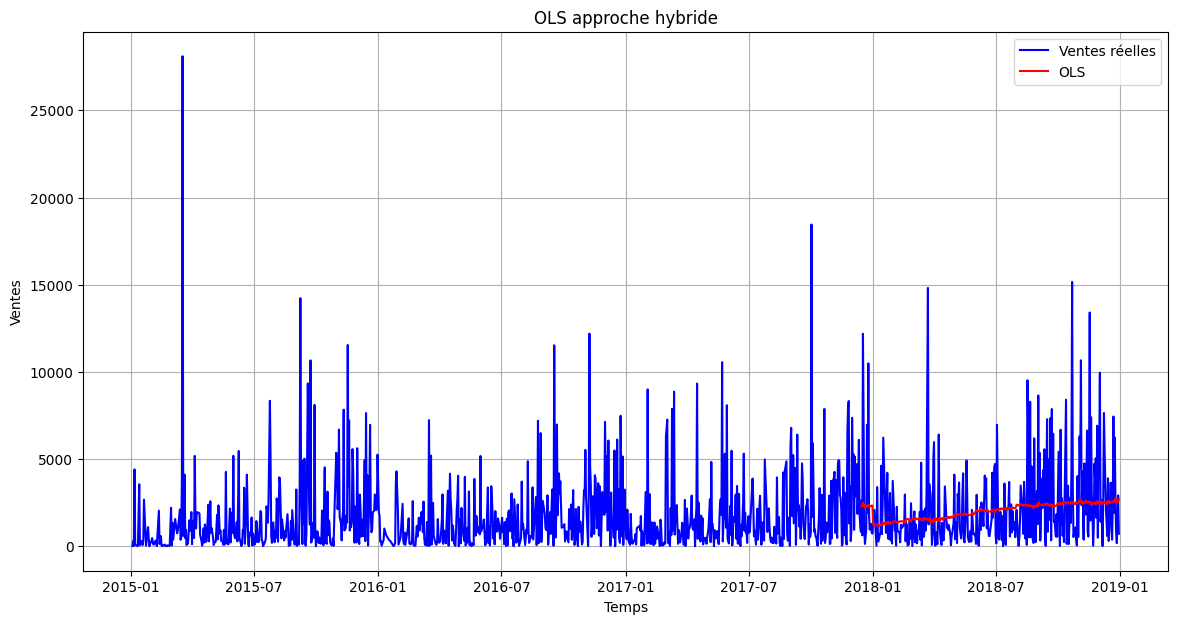

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(df_test_final.index, predictions_final_ols, c='r', label='OLS')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('OLS approche hybride')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest hybride

In [ ]:
models_hybrid_rf, predictions_hybrid_rf, rmse_hybrid_rf, predictions_final_rf = hybrid_forecasting(
    X_train_final, y_train_final, X_test_final, y_test_final, RandomForestRegressor(), max_horizon=30
)

Entrainement du modèle 1
Entrainement du modèle 2
Entrainement du modèle 3
Entrainement du modèle 4
Entrainement du modèle 5
Entrainement du modèle 6
Entrainement du modèle 7
Entrainement du modèle 8
Entrainement du modèle 9
Entrainement du modèle 10
Entrainement du modèle 11
Entrainement du modèle 12
Entrainement du modèle 13
Entrainement du modèle 14
Entrainement du modèle 15
Entrainement du modèle 16
Entrainement du modèle 17
Entrainement du modèle 18
Entrainement du modèle 19
Entrainement du modèle 20
Entrainement du modèle 21
Entrainement du modèle 22
Entrainement du modèle 23
Entrainement du modèle 24
Entrainement du modèle 25
Entrainement du modèle 26
Entrainement du modèle 27
Entrainement du modèle 28
Entrainement du modèle 29
Entrainement du modèle 30
RMSE global pour 30% des données de test : 2529.43


In [ ]:
predictions_final_rf=pd.DataFrame(predictions_final_rf)
predictions_final_rf.index = df_test_final.index

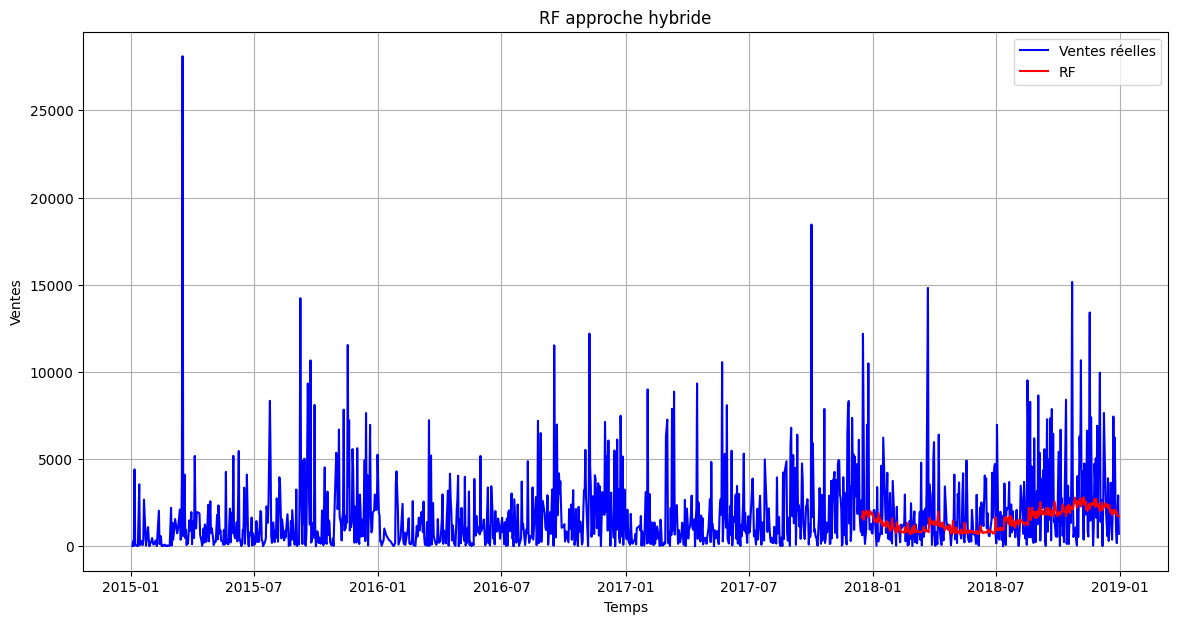

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(df_test_final.index, predictions_final_rf, c='r', label='RF')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('RF approche hybride')
plt.legend()
plt.grid(True)
plt.show()

## Gradient Bosting hybride

In [ ]:
models_hybrid_gb, predictions_hybrid_gb, rmse_hybrid_gb, predictions_final_gb = hybrid_forecasting(
    X_train_final, y_train_final, X_test_final, y_test_final, GradientBoostingRegressor(), max_horizon=30
)

Entrainement du modèle 1
Entrainement du modèle 2
Entrainement du modèle 3
Entrainement du modèle 4
Entrainement du modèle 5
Entrainement du modèle 6
Entrainement du modèle 7
Entrainement du modèle 8
Entrainement du modèle 9
Entrainement du modèle 10
Entrainement du modèle 11
Entrainement du modèle 12
Entrainement du modèle 13
Entrainement du modèle 14
Entrainement du modèle 15
Entrainement du modèle 16
Entrainement du modèle 17
Entrainement du modèle 18
Entrainement du modèle 19
Entrainement du modèle 20
Entrainement du modèle 21
Entrainement du modèle 22
Entrainement du modèle 23
Entrainement du modèle 24
Entrainement du modèle 25
Entrainement du modèle 26
Entrainement du modèle 27
Entrainement du modèle 28
Entrainement du modèle 29
Entrainement du modèle 30
RMSE global pour 30% des données de test : 2473.10


In [ ]:
predictions_final_gb=pd.DataFrame(predictions_final_gb)
predictions_final_gb.index = df_test_final.index

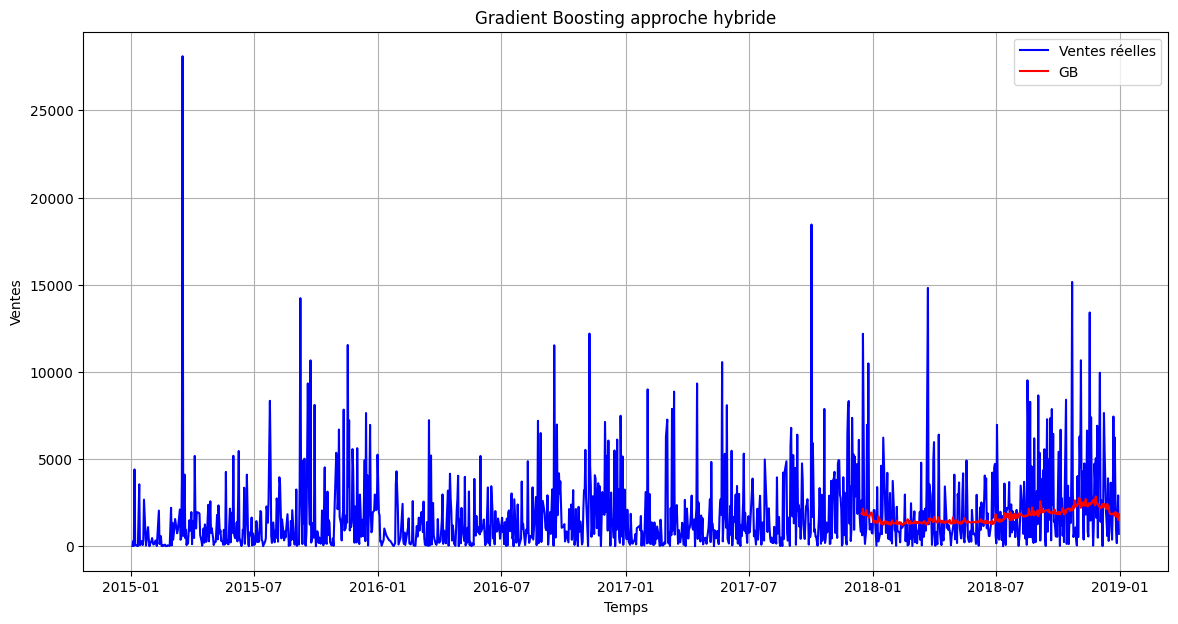

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(df_test_final.index, predictions_final_gb, c='r', label='GB')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Gradient Boosting approche hybride')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost hybride

In [ ]:
models_hybrid_xb, predictions_hybrid_xb, rmse_hybrid_xb, predictions_final_xb = hybrid_forecasting(
    X_train_final, y_train_final, X_test_final, y_test_final, xgb.XGBRegressor(), max_horizon=30
)

Entrainement du modèle 1
Entrainement du modèle 2
Entrainement du modèle 3
Entrainement du modèle 4
Entrainement du modèle 5
Entrainement du modèle 6
Entrainement du modèle 7
Entrainement du modèle 8
Entrainement du modèle 9
Entrainement du modèle 10
Entrainement du modèle 11
Entrainement du modèle 12
Entrainement du modèle 13
Entrainement du modèle 14
Entrainement du modèle 15
Entrainement du modèle 16
Entrainement du modèle 17
Entrainement du modèle 18
Entrainement du modèle 19
Entrainement du modèle 20
Entrainement du modèle 21
Entrainement du modèle 22
Entrainement du modèle 23
Entrainement du modèle 24
Entrainement du modèle 25
Entrainement du modèle 26
Entrainement du modèle 27
Entrainement du modèle 28
Entrainement du modèle 29
Entrainement du modèle 30
RMSE global pour 30% des données de test : 2493.01


In [ ]:
predictions_final_xb=pd.DataFrame(predictions_final_xb)
predictions_final_xb.index = df_test_final.index

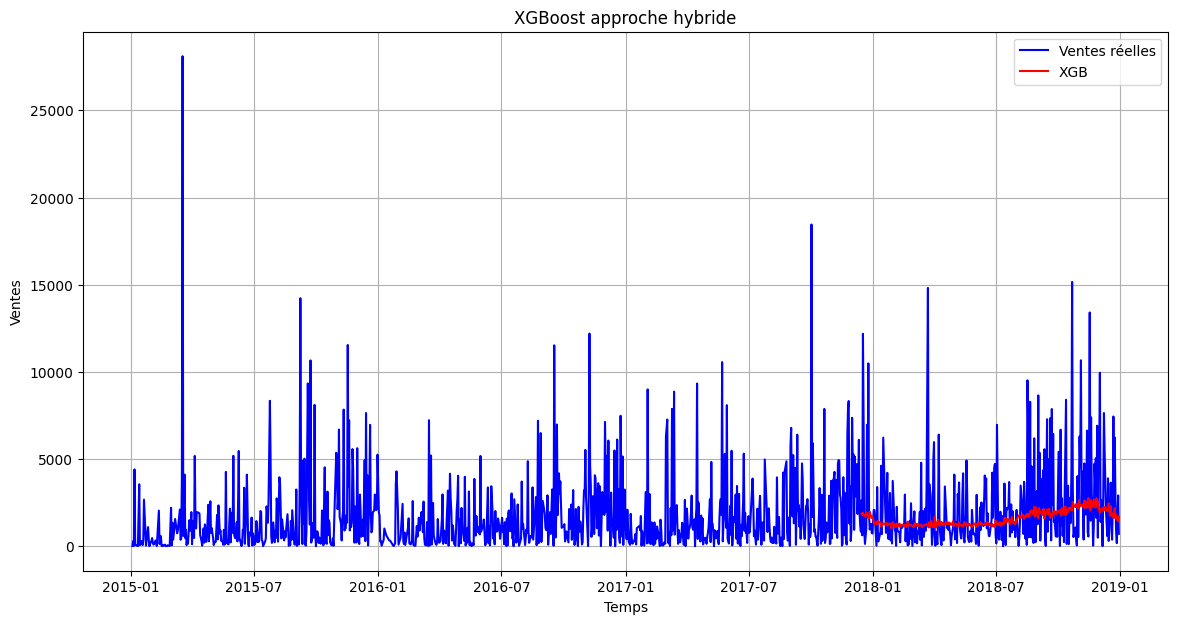

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(df_test_final.index, predictions_final_xb, c='r', label='XGB')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('XGBoost approche hybride')
plt.legend()
plt.grid(True)
plt.show()

## LGBM hybride

In [ ]:
models_hybrid_lgbm, predictions_hybrid_lgbm, rmse_hybrid_lgbm, predictions_final_lgbm = hybrid_forecasting(
    X_train_final, y_train_final, X_test_final, y_test_final, lgb.LGBMRegressor(), max_horizon=30
)

Entrainement du modèle 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9521
[LightGBM] [Info] Number of data points in the train set: 783, number of used features: 43
[LightGBM] [Info] Start training from score 1751.042459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
predictions_final_lgbm=pd.DataFrame(predictions_final_lgbm)
predictions_final_lgbm.index = df_test_final.index

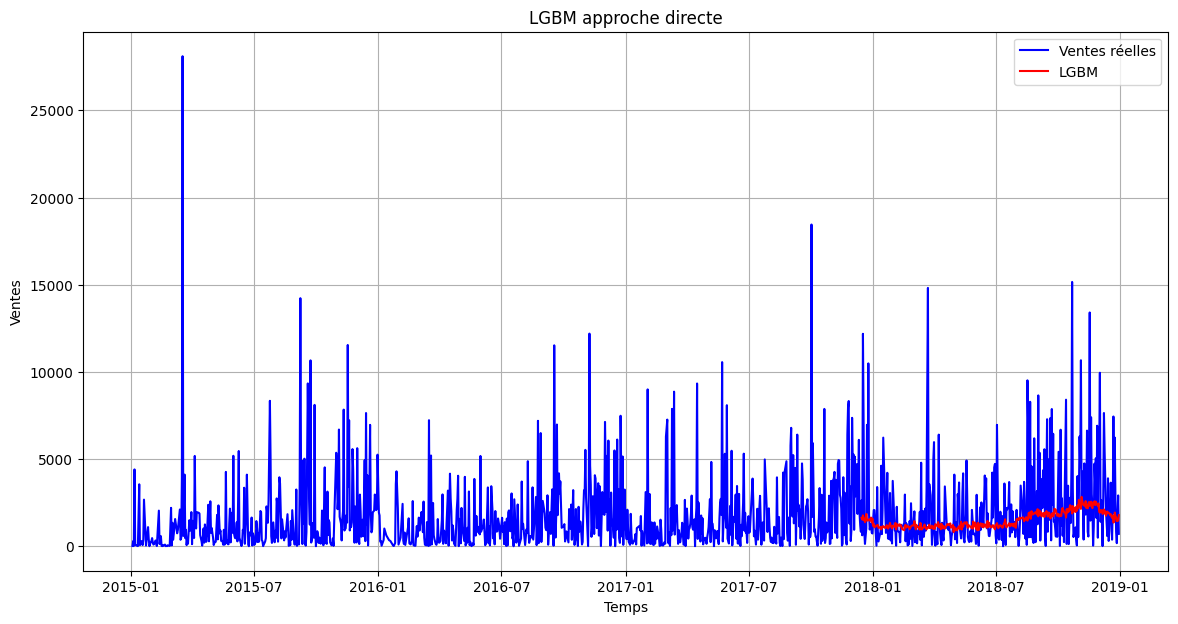

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], c='b', label='Ventes réelles')
plt.plot(df_test_final.index, predictions_final_lgbm, c='r', label='LGBM')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('LGBM approche directe')
plt.legend()
plt.grid(True)
plt.show()

## Comparaison des résultats

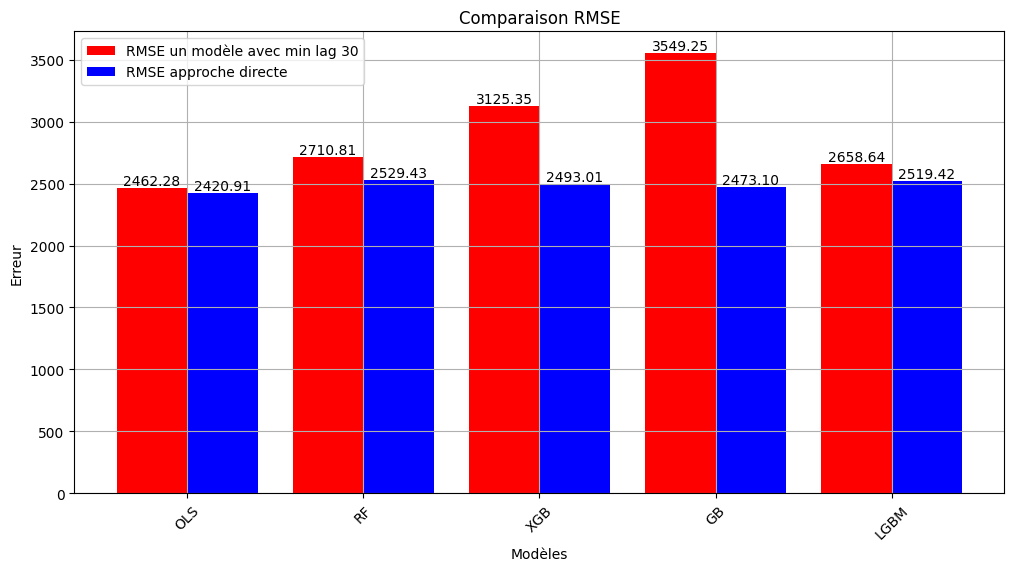

In [ ]:
#RMSE

rmse_hybride = {}

rmse_hybride["OLS"] = rmse_hybrid_ols
rmse_hybride["RF"] = rmse_hybrid_rf
rmse_hybride["XGB"] = rmse_hybrid_xb
rmse_hybride["GB"] = rmse_hybrid_gb
rmse_hybride["LGBM"] = rmse_hybrid_lgbm

# Préparation des données
models_to_keep = {'RMSE_OLS', 'RF modèle', 'XGBoost', 'Gradient Boosting', 'LGBM'}

# Filtrer le dictionnaire
perf_rmse_filtered = {k: v for k, v in perf_rmse.items() if k in models_to_keep}

rmse_values_1 = list(perf_rmse_filtered.values())
rmse_values_2 = list(rmse_hybride.values())

labels = ["OLS", "RF", "XGB", "GB", "LGBM"]
x = np.arange(len(labels))  # Position des groupes

# Tracer les barres côte à côte
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, rmse_values_1, width=0.4, label='RMSE un modèle avec min lag 30', color='red')
plt.bar(x + 0.2, rmse_values_2, width=0.4, label='RMSE approche directe', color='blue')

# Ajouter des labels et des titres
plt.title('Comparaison RMSE')
plt.xlabel('Modèles')
plt.ylabel('Erreur')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.grid(True)

# Ajouter les valeurs au-dessus des barres
for i in range(len(x)):
    plt.text(x[i] - 0.2, rmse_values_1[i] + 0.05, f'{rmse_values_1[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i] + 0.2, rmse_values_2[i] + 0.05, f'{rmse_values_2[i]:.2f}', ha='center', va='bottom')

plt.show()

**Analyse des résultats**

Les résultats montrent une amélioration significative des performances pour presque certains modèles lorsque nous passons à une approche hybride combinée à la prévision des lags récents. Tous les modèles enregistrent une baisse notable du RMSE par rapport à l’approche globale, ce qui prouve l’efficacité de l’approche hybride dans la capture des dynamiques temporelles.

Le modèle de régression linéaire (OLS), déjà performant dans l’approche globale, continue de fournir de bons résultats, réduisant son RMSE de 2462 à 2420, donnant des meilleurs résultats.

Les modèles de machine learning (Random Forest, XGBoost, Gradient Boosting, LGBM) bénéficient particulièrement de cette approche.

XGBoost passe de 3125 à 2493, une réduction substantielle du RMSE.

LGBM, également performant, atteint un RMSE plus petit.

Contrairement à l’approche globale, l’approche hybride permet d’intégrer les lags à court terme (< 30 jours), essentiels pour capturer les fluctuations rapides et les pics de demande. Chaque modèle est optimisé pour prédire un horizon particulier (T+1, T+2…), ce qui réduit les erreurs d’accumulation sur les longues périodes. Cela améliore les prévisions à court et moyen terme.

Cette approche offre une meilleure réactivité aux changements brusques dans les données, permettant aux modèles de machine learning de mieux capturer les fluctuations complexes et non linéaires.

L’approche hybride, combinée à l’utilisation des lags récents, permet aux modèles de machine learning de dépasser les modèles statistiques tout en améliorant considérablement leur capacité à prédire les variations. Cela justifie pleinement son adoption pour des prévisions précises et robustes.

## Deep Learning

Les GRU (Gated Recurrent Units) sont un type de réseau de neurones récurrents optimisé pour capturer les dépendances temporelles dans des séries de données séquentielles. Grâce à leur structure simplifiée par rapport aux LSTM, ils offrent une bonne capacité de mémorisation tout en étant plus rapides à entraîner.

Il y a quand même plusieurs limites liés à notre cas :

- Données insuffisantes : les GRU nécessitent un volume de données suffisant pour apprendre correctement les patterns temporels  

- Séries trop bruitées ou avec des outliers : les GRU ont tendance à lisser les prédictions et peuvent ignorer les variations soudaines (si la série contient de nombreux pics extrêmes ou outliers, le modèle peut avoir du mal à les apprendre)
- ⁠Séries trop stationnaires ou sans tendance claire : les GRU sont plus efficaces sur des données avec des tendances ou des structures temporelles marquées (si la série est trop stationnaire (pas d’évolution significative dans le temps), le modèle peut ne pas extraire d’informations utiles)

- Données non adaptées aux GRU : si chaque point est presque indépendant du passé, un modèle plus simple (régression linéaire, moyenne mobile) peut être plus efficace, ce qui a été notre cas. En conséquence, on peut observer que les prévisions à l'aide du GRU ne sont pas aussi performantes, étant moins bonnes que celles des modèles simples.

### Annexe GRU

In [ ]:
# On reprend les données agrégées par jour
#df = pd.read_csv("/content/drive/MyDrive/PROJET_TIME_SERIES/train.csv")

df['Order Date']= pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
ventes_par_jour = df.groupby('Order Date')['Sales'].sum().reset_index()
ventes_par_jour.set_index("Order Date", inplace=True)
ventes_par_jour.head()

KeyError: 'Order Date'

In [ ]:
# On choisit les dates de cutoff pour la validation et pour le test
valid_st_data_sales = "2017-11-12 00:00:00"
test_st_data_sales = "2018-04-07 00:00:00"

In [ ]:
# On visualise les données de train, validation et de test sur l'ensemble de nos données

ventes_par_jour[ventes_par_jour.index < valid_st_data_sales][["Sales"]].rename(columns={"Sales": "train"}).join(
    ventes_par_jour[(ventes_par_jour.index >= valid_st_data_sales) & (ventes_par_jour.index < test_st_data_sales)][
        ["Sales"]
    ].rename(columns={"Sales": "validation"}),
    how="outer",
).join(
    ventes_par_jour[test_st_data_sales:][["Sales"]].rename(columns={"Sales": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

### TRAIN


In [ ]:
T = 7  #lags
HORIZON = 30 #horizon de prévision
train = ventes_par_jour.copy()[ventes_par_jour.index < valid_st_data_sales][["Sales"]]

# Normalisation
scaler = MinMaxScaler()
train["Sales"] = scaler.fit_transform(train)
train_shifted = train.copy()

# 30 valeurs futures
for h in range(1, HORIZON + 1):
    train_shifted[f"y_t+{h}"] = train_shifted["Sales"].shift(-h)

# Lags
for t in range(1, T + 1):
    train_shifted[f"Sales_t-{t}"] = train_shifted["Sales"].shift(t)

# target et features
y_cols = [f"y_t+{h}" for h in range(1, HORIZON + 1)]
X_cols = [f"Sales_t-{t}" for t in range(1, T+1)]

# on élimine les valeurs manquantes
train_shifted = train_shifted.dropna()

# conversion en numpy
X_train = train_shifted[X_cols].to_numpy()
y_train = train_shifted[y_cols].to_numpy()

print("X_train shape:", X_train.shape)  # (samples, T)
print("y_train shape:", y_train.shape)  # (samples, HORIZON)

# Création du tenseur pour ingestion dans Keras, au format (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], T, 1)


### VALIDATION

In [ ]:
# donées de validation
valid = ventes_par_jour.copy()[(ventes_par_jour.index >= valid_st_data_sales) & (ventes_par_jour.index < test_st_data_sales)][["Sales"]]

# normalisation
valid["Sales"] = scaler.transform(valid)

valid_shifted = valid.copy()

# y_t+1 jusqu'à y_t+30
for h in range(1, HORIZON + 1):
    valid_shifted[f"y_t+{h}"] = valid_shifted["Sales"].shift(-h)

# Sales_t-1 jusqu'à Sales_t-7
for t in range(1, T + 1):
    valid_shifted[f"Sales_t-{t}"] = valid_shifted["Sales"].shift(t)

# target et features
y_cols_valid = [f"y_t+{h}" for h in range(1, HORIZON + 1)]
X_cols_valid = [f"Sales_t-{t}" for t in range(1, T + 1)]

# on enlève les valeurs manquantes
valid_shifted = valid_shifted.dropna()

# NumPy
X_valid = valid_shifted[X_cols_valid].to_numpy()
y_valid = valid_shifted[y_cols_valid].to_numpy()


print("X_valid shape:", X_valid.shape)  # Expected: (samples, T)
print("y_valid shape:", y_valid.shape)  # Expected: (samples, HORIZON)

X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

### GRU

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
learning_rate = 0.01

optimizer = Adam(learning_rate=learning_rate)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


model = Sequential([
    GRU(256, input_shape=(T, 1), return_sequences=True),
    Dropout(0.3),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(HORIZON)
])

model.compile(optimizer=optimizer, loss='huber')

In [ ]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop, lr_reducer],
    verbose=1
)

In [ ]:
#learning curves
pd.DataFrame(model_history.history).plot(figsize=(8, 4))
plt.grid(True)
plt.xlabel('# epoch')
plt.ylabel('Loss')
plt.show()

### TEST

In [ ]:
# le test set
test = ventes_par_jour.copy()[ventes_par_jour.index >= test_st_data_sales][["Sales"]]

# normalisation
test["Sales"] = scaler.transform(test)
test_shifted = test.copy()

# y_t+1 jusqu'à y_t+30
for h in range(1, HORIZON + 1):
    test_shifted[f"y_t+{h}"] = test_shifted["Sales"].shift(-h)

# Sales_t-1 jusqu'à Sales_t-7
for t in range(1, T + 1):
    test_shifted[f"Sales_t-{t}"] = test_shifted["Sales"].shift(t)

# Define target and features
y_cols_test = [f"y_t+{h}" for h in range(1, HORIZON + 1)]
X_cols_test = [f"Sales_t-{t}" for t in range(1, T + 1)]

# on enlève les valeurs manquantes
test_shifted = test_shifted.dropna()

# conversion en numpy
X_test = test_shifted[X_cols_test].values
y_test = test_shifted[y_cols_test].values

X_test = X_test.reshape(X_test.shape[0], T, 1)
print("X_test shape:", X_test.shape)  # Expected: (samples, T, 1)
print("y_test shape:", y_test.shape)  # Expected: (samples, HORIZON)

test_shifted.head(3)


In [ ]:
ts_predictions = model.predict(X_test)
ev_ts_data = pd.DataFrame(ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)])
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(ev_ts_data[["prediction", "actual"]])
ev_ts_data.tail()

In [ ]:
#RMSE
error = root_mean_squared_error(ev_ts_data["prediction"], ev_ts_data["actual"])
print("RMSE:", error)

In [ ]:
# On représente uniquement les `t+30`
t30_ev_ts_data = ev_ts_data[ev_ts_data["h"] == "t+30"]

plt.figure(figsize=(15, 8))
plt.plot(t30_ev_ts_data["timestamp"], t30_ev_ts_data["actual"], label="Actual Sales (t+30)", color="b")
plt.plot(t30_ev_ts_data["timestamp"], t30_ev_ts_data["prediction"], label="Predicted Sales (t+30)", color="r")

plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("Predictions for Horizon t+30")
plt.legend()
plt.show()


### LSTM

Le **LSTM** est une variante des **RNN** conçue pour mieux capturer les dépendances à long terme dans les séquences de données. Proposé par *Hochreiter & Schmidhuber (1997)*, il permet d'atténuer les problèmes de disparition et d'explosion du gradient rencontrés dans les RNN classiques.

Le *problème de disparition et d’explosion du gradient* concerne l’entraînement des **RNN** et des réseaux profonds :  

- **Disparition du gradient** : Les gradients deviennent trop petits (\(<1\)), ralentissant l’apprentissage des premieres couches. Resultat : le réseau **oublie** les informations lointaines. Pour résoudre ce problème, on peut utiliser LSTM ou GRU ou changer la fonction d'activation (ReLU).
- **Explosion du gradient** : Les gradients deviennent trop grands (\(>1\)), rendant l’apprentissage **instable** et empêchant la convergence. Pour résoudre ce problème on peut réduire le learning rate ou utiliser des optimiseurs avancés comme Adam ou RMSprop.

### Fonctionnement du LSTM
Un LSTM est composé de **cellules mémoire** qui régulent le flux d'information grâce à trois **portes** :
- **Porte d'oubli** : Détermine la quantité d'information de l'état précédent à oublier.
- **Porte d'entrée** : Décide quelles nouvelles informations ajouter à la cellule mémoire.
- **Porte de sortie** : Contrôle quelles informations de la cellule mémoire seront utilisées pour produire la sortie actuelle.

### Avantages du LSTM
- **Capture des dépendances à long terme** : Grâce à la cellule mémoire, il peut stocker et récupérer des informations sur des séquences longues.
- **Atténuation du problème de gradient** : Contrairement aux RNN standards, le LSTM préserve mieux l’information sur plusieurs étapes temporelles.
- **Flexibilité** : Utilisé en traitement du langage naturel (NLP), séries temporelles, reconnaissance vocale, etc.

### Comparaison avec d'autres modèles

#### LSTM vs RNN classique
| Critère            | RNN Classique       | LSTM              |
|--------------------|--------------------|-------------------|
| Mémorisation      | Courte              | Longue           |
| Problème de gradient | Présent            | Atténué          |
| Performance sur longues séquences | Faible | Meilleure |

#### LSTM vs GRU (Gated Recurrent Unit)
| Critère        | LSTM                 | GRU                   |
|---------------|---------------------|-----------------------|
| Nombre de portes | 3 (oubli, entrée, sortie) | 2 (réinitialisation, mise à jour) |
| Complexité     | Plus élevée         | Moins élevée         |
| Capacité de mémorisation | Meilleure pour longues séquences | Suffisante pour séquences courtes et moyennes |
| Temps de calcul | Plus lent           | Plus rapide |

Le **GRU** est une simplification du LSTM, souvent plus efficace lorsque les longues dépendances ne sont pas essentielles.

#### LSTM vs ConvLSTM
Le **ConvLSTM** est une extension du LSTM adaptée aux données spatiales (ex : vidéos, images en séquence). Contrairement au LSTM classique, il remplace les multiplications matricielles par des **convolutions**, ce qui est plus adapté pour extraire des motifs spatiaux dans les séquences.

| Critère          | LSTM                  | ConvLSTM               |
|-----------------|----------------------|------------------------|
| Type de données | Séquences générales  | Séquences spatiales (ex: vidéo) |
| Calcul         | Matriciel (MLP)       | Convolutif (CNN)       |
| Applications   | NLP, séries temporelles | Prédiction vidéo, segmentation temporelle |

In [ ]:
def create_sequences(X, y, sequence_length, prediction_days=30):
    """Création des séquences pour le LSTM avec prédiction sur plusieurs jours"""
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length - prediction_days + 1):
        X_seq.append(X[i:(i + sequence_length)])
        y_seq.append(y[i + sequence_length:i + sequence_length + prediction_days])
    return np.array(X_seq), np.array(y_seq)


def create_model(input_shape, units=50, layers=1, dropout_rate=0.2, learning_rate=0.001, prediction_days=30):
    """Création du modèle LSTM pour prédiction de plusieurs jours"""
    model = Sequential()

    # Première couche LSTM
    model.add(LSTM(units=units, return_sequences=layers > 1,
                  input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Couches LSTM supplémentaires si nécessaire
    for i in range(layers - 1):
        model.add(LSTM(units=units, return_sequences=i < layers-2))
        model.add(Dropout(dropout_rate))

    # Couche de sortie : prédire 'prediction_days' jours
    model.add(Dense(prediction_days))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='mse', metrics=['mae'])
    return model


# Normalisation des données
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Paramètres pour la recherche d'hyperparamètres
param_grid = {
    'sequence_length': [30, 60, 90],
    'units': [32, 64],
    'layers': [1, 2],
    'dropout_rate': [0.3, 0.4],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50],
    'early_stopping_patience': [5, 10],  # Early stopping pour éviter l'overfitting
    'restore_best_weights': [True, False],  # Restaurer les meilleurs poids après early stopping
    'l2_reg': [0.001, 0.01]  # Régularisation L2
}


# Création des séquences (sera fait pour chaque sequence_length dans la grille)
best_score = float('inf')
best_params = None
results = []

# Recherche d'hyperparamètres
for params in ParameterGrid(param_grid):
    print(f"\nTesting parameters: {params}")

    # Création des séquences
    X_seq_train, y_seq_train = create_sequences(
        X_train_scaled, y_train_scaled, params['sequence_length'], prediction_days=30
    )
    X_seq_test, y_seq_test = create_sequences(
        X_test_scaled, y_test_scaled, params['sequence_length'], prediction_days=30
    )


    # Création et entraînement du modèle
    model = create_model(
        input_shape=(params['sequence_length'], X_train.shape[1]),
        units=params['units'],
        layers=params['layers'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    history = model.fit(
        X_seq_train, y_seq_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=0.1,
        verbose=0
    )

    # Évaluation
    y_pred = model.predict(X_seq_test)
    y_pred = scaler_y.inverse_transform(y_pred)
    y_true = scaler_y.inverse_transform(y_seq_test)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    results.append({
        'params': params,
        'mse': mse,
        'mae': mae
    })


    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = model

# Affichage des résultats
results_df = pd.DataFrame(results)
print("\nBest parameters:")
print(best_params)
print(f"\nBest MSE: {best_score:.2f}")

# Prédictions avec les meilleurs paramètres
X_seq_test_best, y_seq_test_best = create_sequences(
    X_test_scaled, y_test_scaled, best_params['sequence_length']
)
y_pred_best = best_model.predict(X_seq_test_best)
y_pred_best = scaler_y.inverse_transform(y_pred_best)
y_true_best = scaler_y.inverse_transform(y_seq_test_best)

# Calcul des métriques finales
final_mse = mean_squared_error(y_true_best, y_pred_best)
final_mae = mean_absolute_error(y_true_best, y_pred_best)
print(f"\nFinal Results:")
print(f"MSE: {final_mse:.2f}")
print(f"MAE: {final_mae:.2f}")

In [ ]:
from datetime import datetime, timedelta

def plot_predictions_with_history(y_true_history, y_true_future, y_pred_future, date_index=None):
    """
    Crée un graphique montrant:
    - Les 90 derniers jours d'historique
    - Les prédictions vs réalité sur 30 jours

    Parameters:
    -----------
    y_true_history : array-like
        Les 90 derniers jours d'historique
    y_true_future : array-like
        Les valeurs réelles des 30 jours de prédiction
    y_pred_future : array-like
        Les prédictions pour les 30 jours
    date_index : array-like, optional
        Index des dates pour l'axe x
    """

    plt.figure(figsize=(15, 8))

    # Création de l'index si non fourni
    if date_index is None:
        total_days = len(y_true_history) + len(y_true_future)
        date_index = pd.date_range(end=datetime.now(), periods=total_days)

    # Index pour le plotting
    history_index = date_index[:len(y_true_history)]
    future_index = date_index[len(y_true_history):]

    # Tracer l'historique
    plt.plot(history_index, y_true_history,
             label='Historique', color='blue', linewidth=2)

    # Tracer les valeurs réelles futures
    plt.plot(future_index, y_true_future,
             label='Réalité', color='green', linewidth=2)

    # Tracer les prédictions
    plt.plot(future_index, y_pred_future,
             label='Prédictions', color='red',
             linestyle='--', linewidth=2)

    # Ajouter une ligne verticale séparant l'historique des prédictions
    plt.axvline(x=history_index[-1], color='gray',
                linestyle=':', label='Début prédictions')

    # Personnalisation du graphique
    plt.title('Prédictions des ventes vs Réalité',
              fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Ventes', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=10)

    # Rotation des dates sur l'axe x
    plt.xticks(rotation=45)

    # Ajustement automatique de la mise en page
    plt.tight_layout()

    return plt.gcf()

# Extraction des données nécessaires
# Les 90 derniers jours d'historique
history_data = y_train[-90:] if len(y_train) >= 90 else y_train

# Préparer les données pour le graphique
fig = plot_predictions_with_history(
    y_true_history=history_data,
    y_true_future=y_true_best.flatten(),  # Les vraies valeurs des 30 jours
    y_pred_future=y_pred_best.flatten(),  # Nos prédictions
    date_index=pd.date_range(end=test.index[-1],
                            periods=len(history_data) + len(y_true_best))
)

# Calcul des métriques d'erreur pour la période de prédiction
from sklearn.metrics import mean_squared_error

# Calcul des métriques d'erreur pour la période de prédiction
mse = mean_squared_error(y_true_best, y_pred_best)
rmse = np.sqrt(mse)  # Ajout de la RMSE
mae = mean_absolute_error(y_true_best, y_pred_best)
mape = np.mean(np.abs((y_true_best - y_pred_best) / y_true_best)) * 100

# Affichage des métriques
print(f"Métriques sur la période de prédiction (30 jours):")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")  # Affichage de la RMSE
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.show()

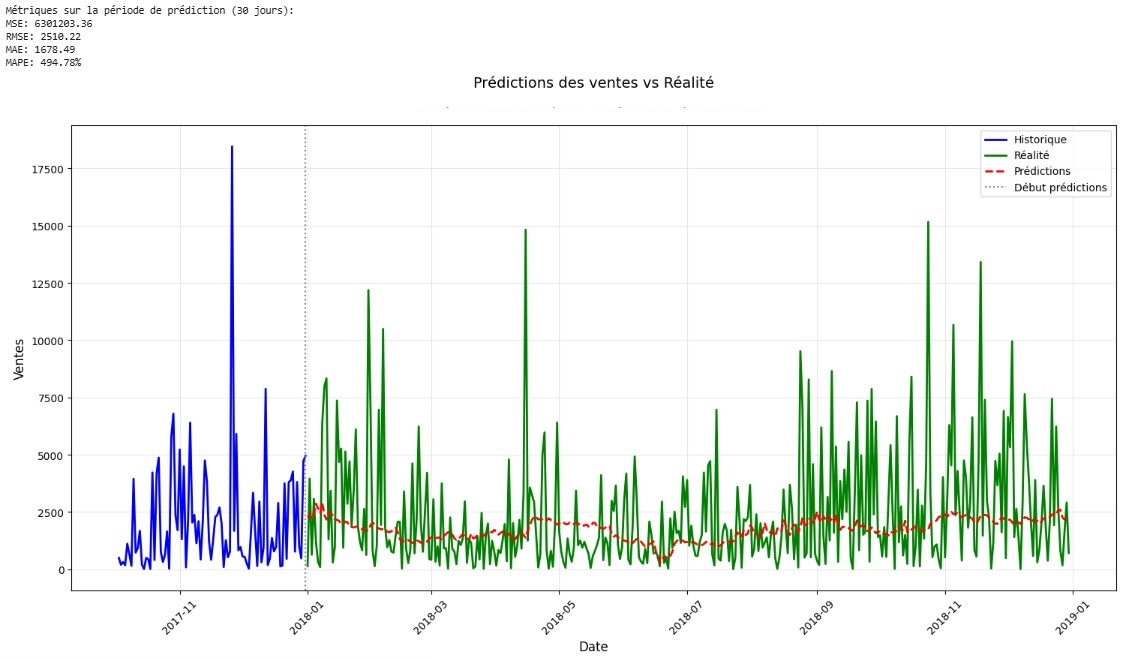

La prédiction des ventes semble ne pas capturer la volatilité réelle des données historiques. Le modèle produit une tendance relativement lissée (ligne rouge pointillée), tandis que les ventes réelles (ligne verte) présentent des variations importantes et des pics marqués.

Les métriques d'évaluation indiquent une erreur significative :

MSE (erreur quadratique moyenne) : 6301203.36
RMSE (erreur quadratique moyenne racine) : 2510.22
MAE (erreur absolue moyenne) : 1678.49
MAPE (erreur en pourcentage) : 494.78%
Une MAPE élevée suggère que le modèle est peu performant, notamment pour les prévisions de forte variabilité. Des ajustements du modèle pourraient être nécessaires, comme l'intégration de variables explicatives supplémentaires, un affinement des paramètres ou l'utilisation d’un modèle plus adapté aux séries temporelles irrégulières.

# Conclusion

Les résultats obtenus dans cette étude mettent en évidence des limitations significatives liées à la qualité des données de vente utilisées, ce qui a directement impacté les performances des modèles testés. L’un des constats les plus frappants est l’incapacité des modèles avancés de machine learning et d’apprentissage profond à surpasser des méthodes plus simples, ce qui souligne la faiblesse structurelle des données et leur inadéquation avec des approches complexes.

Dès l’analyse des performances, il est apparu que les modèles de régression linéaire (OLS) et LightGBM figuraient parmi les plus performants, alors même que des modèles considérés comme plus sophistiqués, tels que XGBoost, Gradient Boosting ou encore les architectures de deep learning, ont largement échoué à produire des résultats probants. Le modèle OLS, malgré sa simplicité apparente, a affiché des performances très compétitives, démontrant ainsi que la dynamique des ventes pouvait être efficacement capturée à travers des relations linéaires et des interactions relativement basiques. LGBM, quant à lui, a également fourni des résultats corrects, bien que son apport ne se soit pas révélé significativement supérieur à celui de la régression linéaire, ce qui tend à montrer que la capacité d’apprentissage des modèles plus complexes était entravée par la nature des données disponibles.

L’échec des approches de deep learning est particulièrement notable. Alors que ces méthodes sont généralement reconnues pour leur efficacité dans des contextes où les données sont volumineuses, structurées et porteuses d’informations riches, elles n’ont ici apporté aucun avantage tangible. Cela peut s’expliquer par plusieurs facteurs, notamment un manque de régularité dans les séries temporelles utilisées, une absence de tendances marquées sur le long terme, ou encore une mauvaise qualité des variables explicatives intégrées dans le modèle. En effet, les réseaux de neurones nécessitent généralement des données à forte dimensionnalité, contenant des motifs complexes et des relations non triviales entre les variables. Or, dans notre cas, l’information contenue dans les données de ventes s’est révélée insuffisante pour exploiter pleinement le potentiel des modèles de deep learning, conduisant à des performances souvent inférieures à celles des modèles statistiques de base.

Une autre explication majeure de ces résultats tient à la structure même des données et aux choix méthodologiques imposés par leur faible qualité. L’impossibilité d’exploiter des lags courts (moins de 30 jours) dans les modèles a privé ces derniers d’informations essentielles sur les fluctuations à court terme des ventes, limitant ainsi leur capacité à capturer les variations soudaines et les pics de demande. Par ailleurs, l’utilisation de lags plus éloignés a introduit un bruit supplémentaire sans véritablement contribuer à améliorer la performance des modèles. En conséquence, les modèles de machine learning, qui sont particulièrement sensibles à la qualité et à la pertinence des features, ont été pénalisés par cette structuration déficiente des données temporelles.

L’analyse des erreurs de prédiction révèle également que les modèles de machine learning et de deep learning ont eu des difficultés à s’adapter aux fluctuations erratiques des ventes, souvent caractérisées par un fort niveau d’aléa et un manque de régularité dans les tendances. Contrairement aux hypothèses initiales selon lesquelles ces modèles avancés pourraient détecter des relations non linéaires subtiles et améliorer la précision des prévisions, les résultats montrent qu’ils ont été largement dépassés par des approches plus simples, en raison d’un environnement de données trop bruité et peu informatif.

En conclusion, cette étude met en lumière la nécessité de disposer de données de meilleure qualité avant d’envisager l’application de modèles avancés. L’incapacité des modèles de deep learning et de boosting à surpasser des méthodes classiques comme la régression linéaire ou LightGBM démontre que la sophistication algorithmique ne peut compenser une structuration défaillante des données. Ces résultats rappellent que l’efficacité d’un modèle repose avant tout sur la pertinence et la richesse des données utilisées, et non sur la complexité de l’algorithme employé. Tant que les données ne contiendront pas une information exploitable plus riche, il est illusoire d’espérer qu’un modèle sophistiqué puisse apporter une amélioration significative des performances prédictives.
